In [177]:
import os 
import time
import joblib
import pickle
import numpy as np
import pandas as pd
import seaborn as sns 
from matplotlib import gridspec
from matplotlib import pyplot as plt
from plotly.subplots import make_subplots
from plotly import graph_objects as go, express as px, offline as pyo

from sklearn.metrics import mean_absolute_error as MAE, mean_absolute_percentage_error as MAPE

# 优化算法
import bayes_opt
from bayes_opt import BayesianOptimization
from hyperopt import fmin, hp, early_stop, Trials, tpe

from xgboost import XGBRegressor as XGB
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, KFold, cross_validate

# 导入数据及相关函数定义

## 相关函数定义

In [2]:
def data_split(x, y, distri_comp, test_size = 0.2, rand_ = 72):
    """
    函数功能：实现训练集和测试集的划分
    distri_comp:是否绘制数据分布对比图；
    """
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = test_size, random_state = rand_)
    x_train.index, x_test.index, y_train.index, y_test.index = range(len(x_train)), range(len(x_test)), range(len(y_train)), range(len(y_test))
    if distri_comp:
        plt.figure(figsize = (10, 6))
        colors = ["red", "blue", "limegreen"]
        labels = ["y_full", "y_train", "y_test"]

        for i, dat in enumerate([y, y_train, y_test]):
            shade = False
            if i == 0:
                shade = True
            sns.kdeplot(dat, shade = shade, color = colors[i], label = labels[i])
        plt.legend(fontsize = 12)
        plt.title("Data Distribution Comparison", fontsize = 25)
        
        plt.show()
    
    return x_train, x_test, y_train, y_test

In [3]:
def draw_plot(data, fig = (20, 35), draw_box = True):
    """
    函数功能：根据传入的data来绘制各个特征的箱线图/核密度图以观察各特征的离散情况/数据分布；
    fig:设置画布的大小---只绘制一幅图像时无需设置；
    draw_box:选择是绘制箱线图还是核密度图，默认是箱线图；
    """
    # 先将数据转为dataframe格式
    data = pd.DataFrame(data)
    feature_names = data.columns.tolist()
    current_palette1 = sns.color_palette("YlOrRd", 20)
    current_palette2 = sns.color_palette("YlOrRd_r", 20)

    # 只绘制一副图时
    if len(feature_names) == 1:
        plt.figure(figsize = (12, 8))     
        # 绘制箱线图
        if draw_box:
            sns.boxplot(data = data.loc[:, feature_names[0]], orient = "V")
            plt.xlabel(feature_names[0], fontsize = 15)
            plt.xticks([])
        # 绘制核密度图
        else:
            sns.kdeplot(data.loc[:, feature_names[0]].astype("float"), shade = True)
            plt.title(feature_names[0], fontsize = 15)
            plt.xlabel("")
            plt.ylabel("")
            
     # 绘制多幅子图时
    else:
        # 调整子图间距
        cols = 3
        rows = int(np.ceil(len(feature_names) / cols))
        plt.subplots_adjust(hspace = 3, wspace = .8)
        plt.figure(figsize = fig, dpi = 200)
        
        # 使用箱线图查看各特征的离散情况
        for i, feature in enumerate(feature_names):
            plt.subplot(rows, cols, i + 1)
            
            try:
                if draw_box:
                    sns.boxplot(data = data.loc[:, feature], orient = "V", color=current_palette1[i])
                    plt.xlabel(feature_names[i], fontsize = 15)
                    plt.xticks([])
                else:
                    sns.kdeplot(data.loc[:, feature].astype("float"), shade = True, color=current_palette2[i])
                    plt.title(feature_names[i], fontsize = 15)    
                    plt.xlabel("")
                    plt.ylabel("")
                    
            except UserWarning:
                continue

    plt.show()
    
    return

In [4]:
def train_validate_comp(train_df, validate_df, dataset_name):
    """
    函数功能：根据各模型在交叉验证中的训练和验证结果绘制对比图，分别是在MAE，MAPE和R^2上的训练验证对比；
    Params:
        tarin_df、validate_df：训练及验证集的结果，三列分别对应MAE，MAPE，R^2；
        dataset_name：图的标题；
    """
    fig = plt.figure(figsize = (16, 9))
    gs = gridspec.GridSpec(2, 2)
    ax1 = plt.subplot(gs[0, :])
    ax2 = plt.subplot(gs[1, 0])
    ax3 = plt.subplot(gs[1, 1])
    labels = ["Train", "Validate"]
    score_names = ["MAE", "MAPE", "R^2"]

    for i, ax in enumerate([ax2, ax3, ax1]):
        for j, dat in enumerate([train_df, validate_df]):
            ax.plot(dat.iloc[:, i], label = labels[j] + "_" + score_names[i])
            if i == 2:
                # 标记R2最大值点
                idx = dat.iloc[:, i].tolist().index(dat.iloc[:, i].max())
                y_max = dat.iloc[:, i].max()
                ax.plot(idx, y_max, marker = "*", color = "red", markersize = 12, alpha = .7)
                if j == 0:
                    ax.text(idx-0.2, y_max+0.05, round(y_max, 7), fontsize = 14)
                else:
                    ax.text(idx-0.2, y_max-0.1, round(y_max, 7), fontsize = 14)
                ax.tick_params("x", labelsize = 12)
            else:
                # 标记最小值点---MAE、MAPE
                idx = dat.iloc[:, i].tolist().index(dat.iloc[:, i].min())
                ax.plot(idx, dat.iloc[:, i].min(), marker = "*", color = "red", markersize = 11, alpha = .7)
                if i == 0:
                    ax.text(idx - 0.8, dat.iloc[:, i].min() + 0.3, round(dat.iloc[:, i].min(),7), fontsize = 12)
                else:
                    ax.text(idx - 0.45, dat.iloc[:, i].min() + 0.005, round(dat.iloc[:, i].min(),7), fontsize = 12)
        if i != 2:
            ax.tick_params("x", rotation = 45, labelsize = 11)
        ax.legend(fontsize = 16)
    plt.suptitle(dataset_name, fontsize = 20)
    plt.show()
    
    return 

In [5]:
def cv_score(x, y, model, rand_ = 72, label = None):
    """
    func:根据传入的数据和模型计算其在5折交叉验证中训练集和验证集上的得分并返回在训练集和验证集上的结果---3列对应
    分别为MAE，MAPE，R^2;
    params:
        x, y:特征矩阵和标签；
        model:模型；
        label:标签y的名称，可不填；
    """
    cv_train = []
    cv_validate = []
    
    cv = KFold(n_splits = 5, shuffle = True, random_state = rand_)
    res = cross_validate(estimator = model
                        , X = x
                        , y = y
                        , cv = cv
                        , n_jobs = 32
                        , scoring = ["neg_mean_absolute_error", "neg_mean_absolute_percentage_error", "r2"]
                        , return_train_score = True
                        , error_score = "raise")
    cv_train.append([abs(res["train_neg_mean_absolute_error"].mean()), 
                     abs(res["train_neg_mean_absolute_percentage_error"].mean()), 
                     res["train_r2"].mean()
                    ])
    cv_validate.append([abs(res["test_neg_mean_absolute_error"].mean()), 
                        abs(res["test_neg_mean_absolute_percentage_error"].mean()), 
                        res["test_r2"].mean()
                      ])
    columns = ["MAE", "MAPE", "R^2"]
    idx1 = "CV_Train"
    idx2 = "CV_Validate"
    if label:
        idx1 = label + "_CV_Train"
        idx2 = label + "_CV_Validate"
    df1 = pd.DataFrame(cv_train, columns = columns, index = [idx1])
    df2 = pd.DataFrame(cv_validate, columns = columns, index = [idx2])
    df = pd.concat([df1, df2])
    
    return df

In [6]:
def test_score(x_train, x_test, y_train, y_test, model, label = None):
    """
    func:返回模型在测试集上的结果---MAE、MAPE
    Params:
        label:标签y的名称，可不填；
    """
    predict = model.fit(x_train, y_train).predict(x_test)
    mae = MAE(y_test, predict)
    mape = MAPE(y_test, predict)
    columns = ["Test_MAE", "MAPE"]
    if label:
        columns = [label + "_Test_MAE", "MAPE"]
    df = pd.DataFrame([mae, mape]).T
    df.columns = columns
    
    return df

In [119]:
def opt_model_comp(train_df, validate_df, dataset_name):
    """
    函数功能：根据使用不同优化手段得到的模型在交叉验证中的训练和验证结果绘制对比图，分别是在MAE，MAPE和R^2上的
    训练验证对比；
    Params:
        tarin_df、validate_df：训练及验证集的结果，三列分别对应MAE，MAPE，R^2；
        dataset_name：图的标题；
    """
    fig = plt.figure(figsize = (16, 9))
    # 设置背景色
    fig.patch.set_facecolor("lavender")
    
    gs = gridspec.GridSpec(2, 2)
    ax1 = plt.subplot(gs[0, :])
    ax2 = plt.subplot(gs[1, 0])
    ax3 = plt.subplot(gs[1, 1])
    
    labels = ["Train", "Validate"]
    score_names = ["MAE", "MAPE", "R^2"]

    for i, ax in enumerate([ax2, ax3, ax1]):
        for j, dat in enumerate([train_df, validate_df]):
            ax.plot(dat.iloc[:, i], label = labels[j] + "_" + score_names[i])
            if i == 2:
                # R2：训练集找最小，测试集找最大
                if j == 1: 
                    # 标记R2最大值点
                    idx = dat.iloc[:, i].tolist().index(dat.iloc[:, i].max())
                    y = dat.iloc[:, i].max()
                else:
                    idx = dat.iloc[:, i].tolist().index(dat.iloc[:, i].min())
                    y = dat.iloc[:, i].min()
                ax.plot(idx, y, marker = "*", color = "red", markersize = 12, alpha = .7)

                if j == 0:
                    ax.text(idx - 0.25, y + 0.004, "(Min) " + str(round(y, 7)), fontsize = 14)
                else:
                    ax.text(idx - 0.25, y + 0.004, "(Max) " + str(round(y, 7)), fontsize = 14)
                ax.tick_params("x", labelsize = 12)
            else:
                # 标记最小值点---MAE、MAPE
                # 训练集找最大，验证集找最小
                if j == 1: # 验证集
                    idx = dat.iloc[:, i].tolist().index(dat.iloc[:, i].min())
                    y = dat.iloc[:, i].min()
                else: # 训练集
                    idx = dat.iloc[:, i].tolist().index(dat.iloc[:, i].max())
                    y = dat.iloc[:, i].max()
                ax.plot(idx, y, marker = "*", color = "red", markersize = 11, alpha = .7)
                if i != 2:
                    s = "(Min) "
                    if j == 0:
                        s = "(Max) "
                    d = 0.55 if i == 0 else 0.0005
                    ax.text(idx - 0.5, y + d, s + str(round(y,7)), fontsize = 12)
                else:
                    ax.text(idx - 0.5, y + 0.001, s + str(round(y,7)), fontsize = 12)
        labelsize = 13
        rotation = None
        if i != 2:
            labelsize = 11
            rotation = 45
        ax.tick_params("x", rotation = rotation, labelsize = labelsize)
        ax.legend(fontsize = 16)
        
    plt.suptitle(dataset_name, fontsize = 20)
    plt.show()
    
    return 

## 导入数据

In [7]:
plt.rcParams["font.sans-serif"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False
plt.style.use("seaborn-darkgrid")

In [8]:
path = r"C:\Users\Research Center\Desktop\learning\PW770建模\对标签YS&IACS建模分析\1.建模数据处理\data_ys_reg.xlsx"
data = pd.read_excel(path)
data

,Cr,Fe,Ti,Si,Ni,固溶温度,固溶时间min,1级冷轧变形率,1级时效温度,1级时效时间h,2级冷轧变形率,2级时效温度,2级时效时间h,YS
0,0.2257,0.40155,0.2362,0.0369,0.174642,1000,2.0,0.625,450,3.0,0.500,350,0.0,557.613333
1,0.2257,0.40155,0.2362,0.0369,0.174642,1000,2.0,0.625,450,3.0,0.500,350,1.0,562.146667
2,0.2257,0.40155,0.2362,0.0369,0.174300,1000,2.0,0.625,450,3.0,0.500,350,3.0,519.933333
3,0.2257,0.40155,0.2362,0.0369,0.174471,1000,2.0,0.625,450,8.0,0.500,350,0.0,541.740000
4,0.2257,0.40155,0.2362,0.0369,0.174300,1000,2.0,0.625,450,8.0,0.500,300,4.0,529.466667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,0.8505,0.33460,0.1950,0.0289,0.005569,1045,2.5,0.750,450,9.0,0.667,350,9.0,686.000000
394,0.8505,0.33460,0.1950,0.0289,0.005569,1045,2.5,0.750,450,9.0,0.667,350,11.0,667.000000
395,0.8505,0.33460,0.1950,0.0289,0.005569,1045,2.5,0.667,450,9.0,0.667,350,7.0,680.000000
396,0.8505,0.33460,0.1950,0.0289,0.005569,1045,2.5,0.667,450,9.0,0.667,350,9.0,669.000000


## 数据探索

<Figure size 432x288 with 0 Axes>

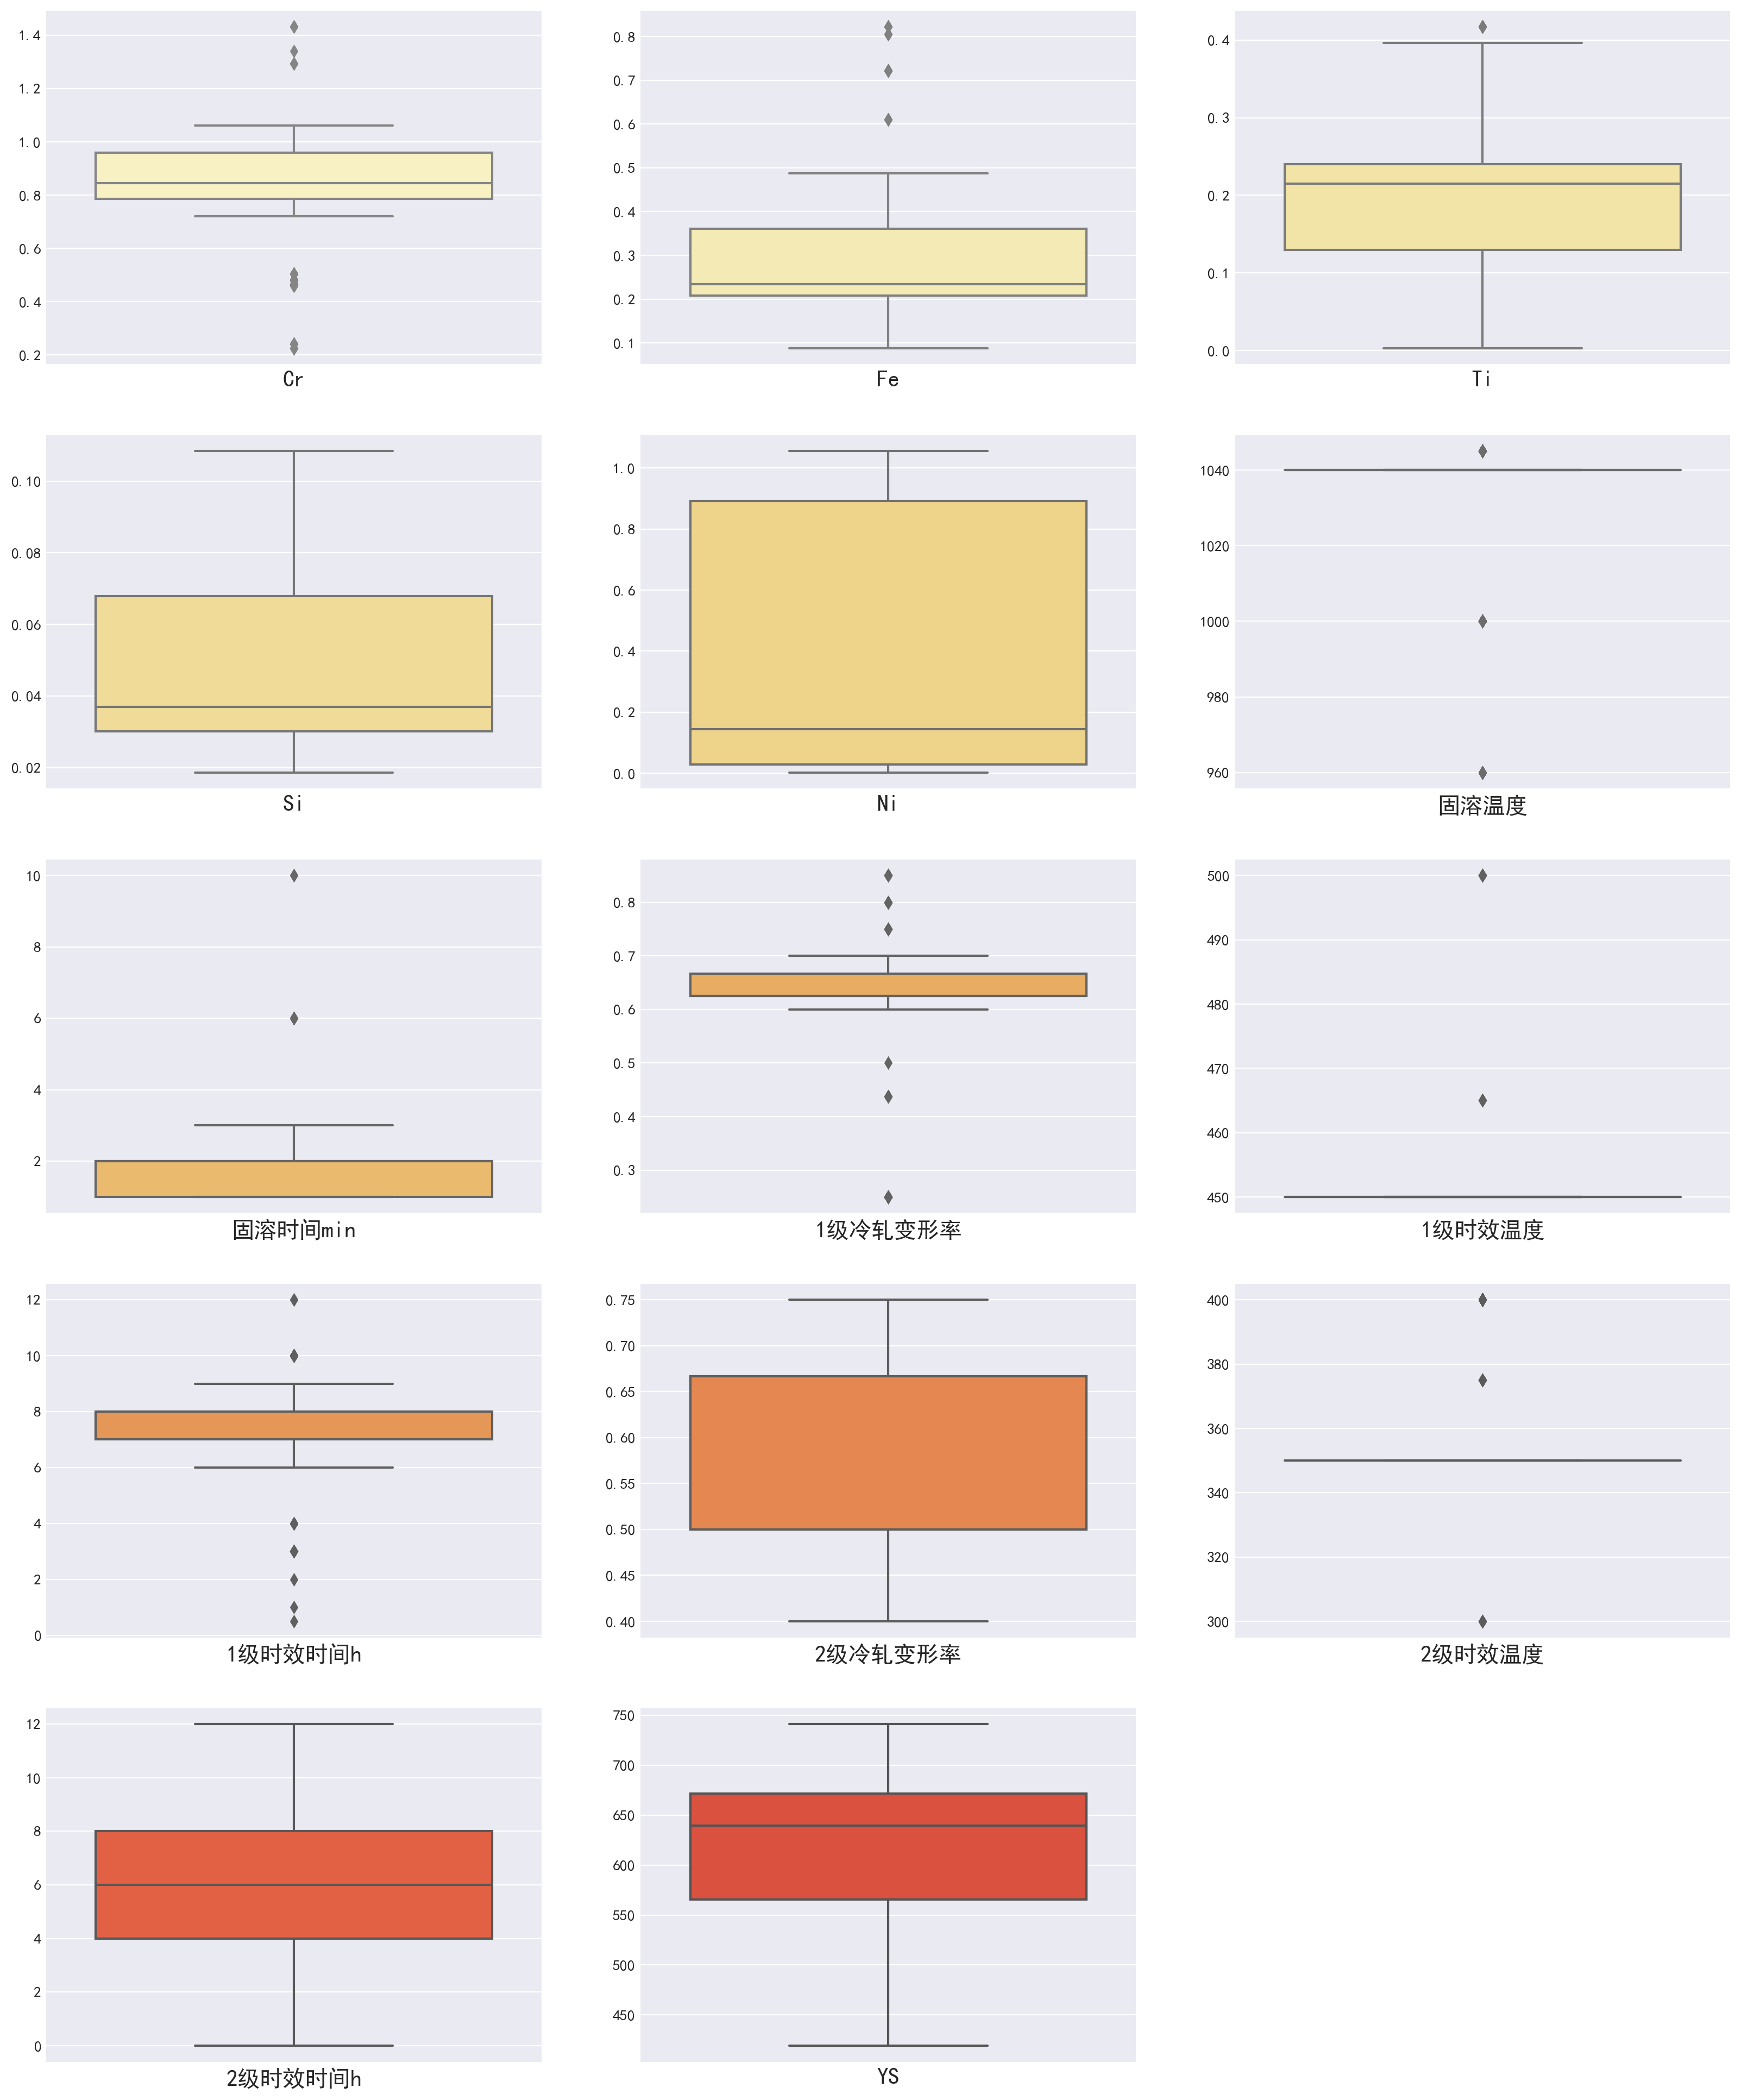

In [13]:
draw_plot(data, fig = (20, 25))

<Figure size 432x288 with 0 Axes>

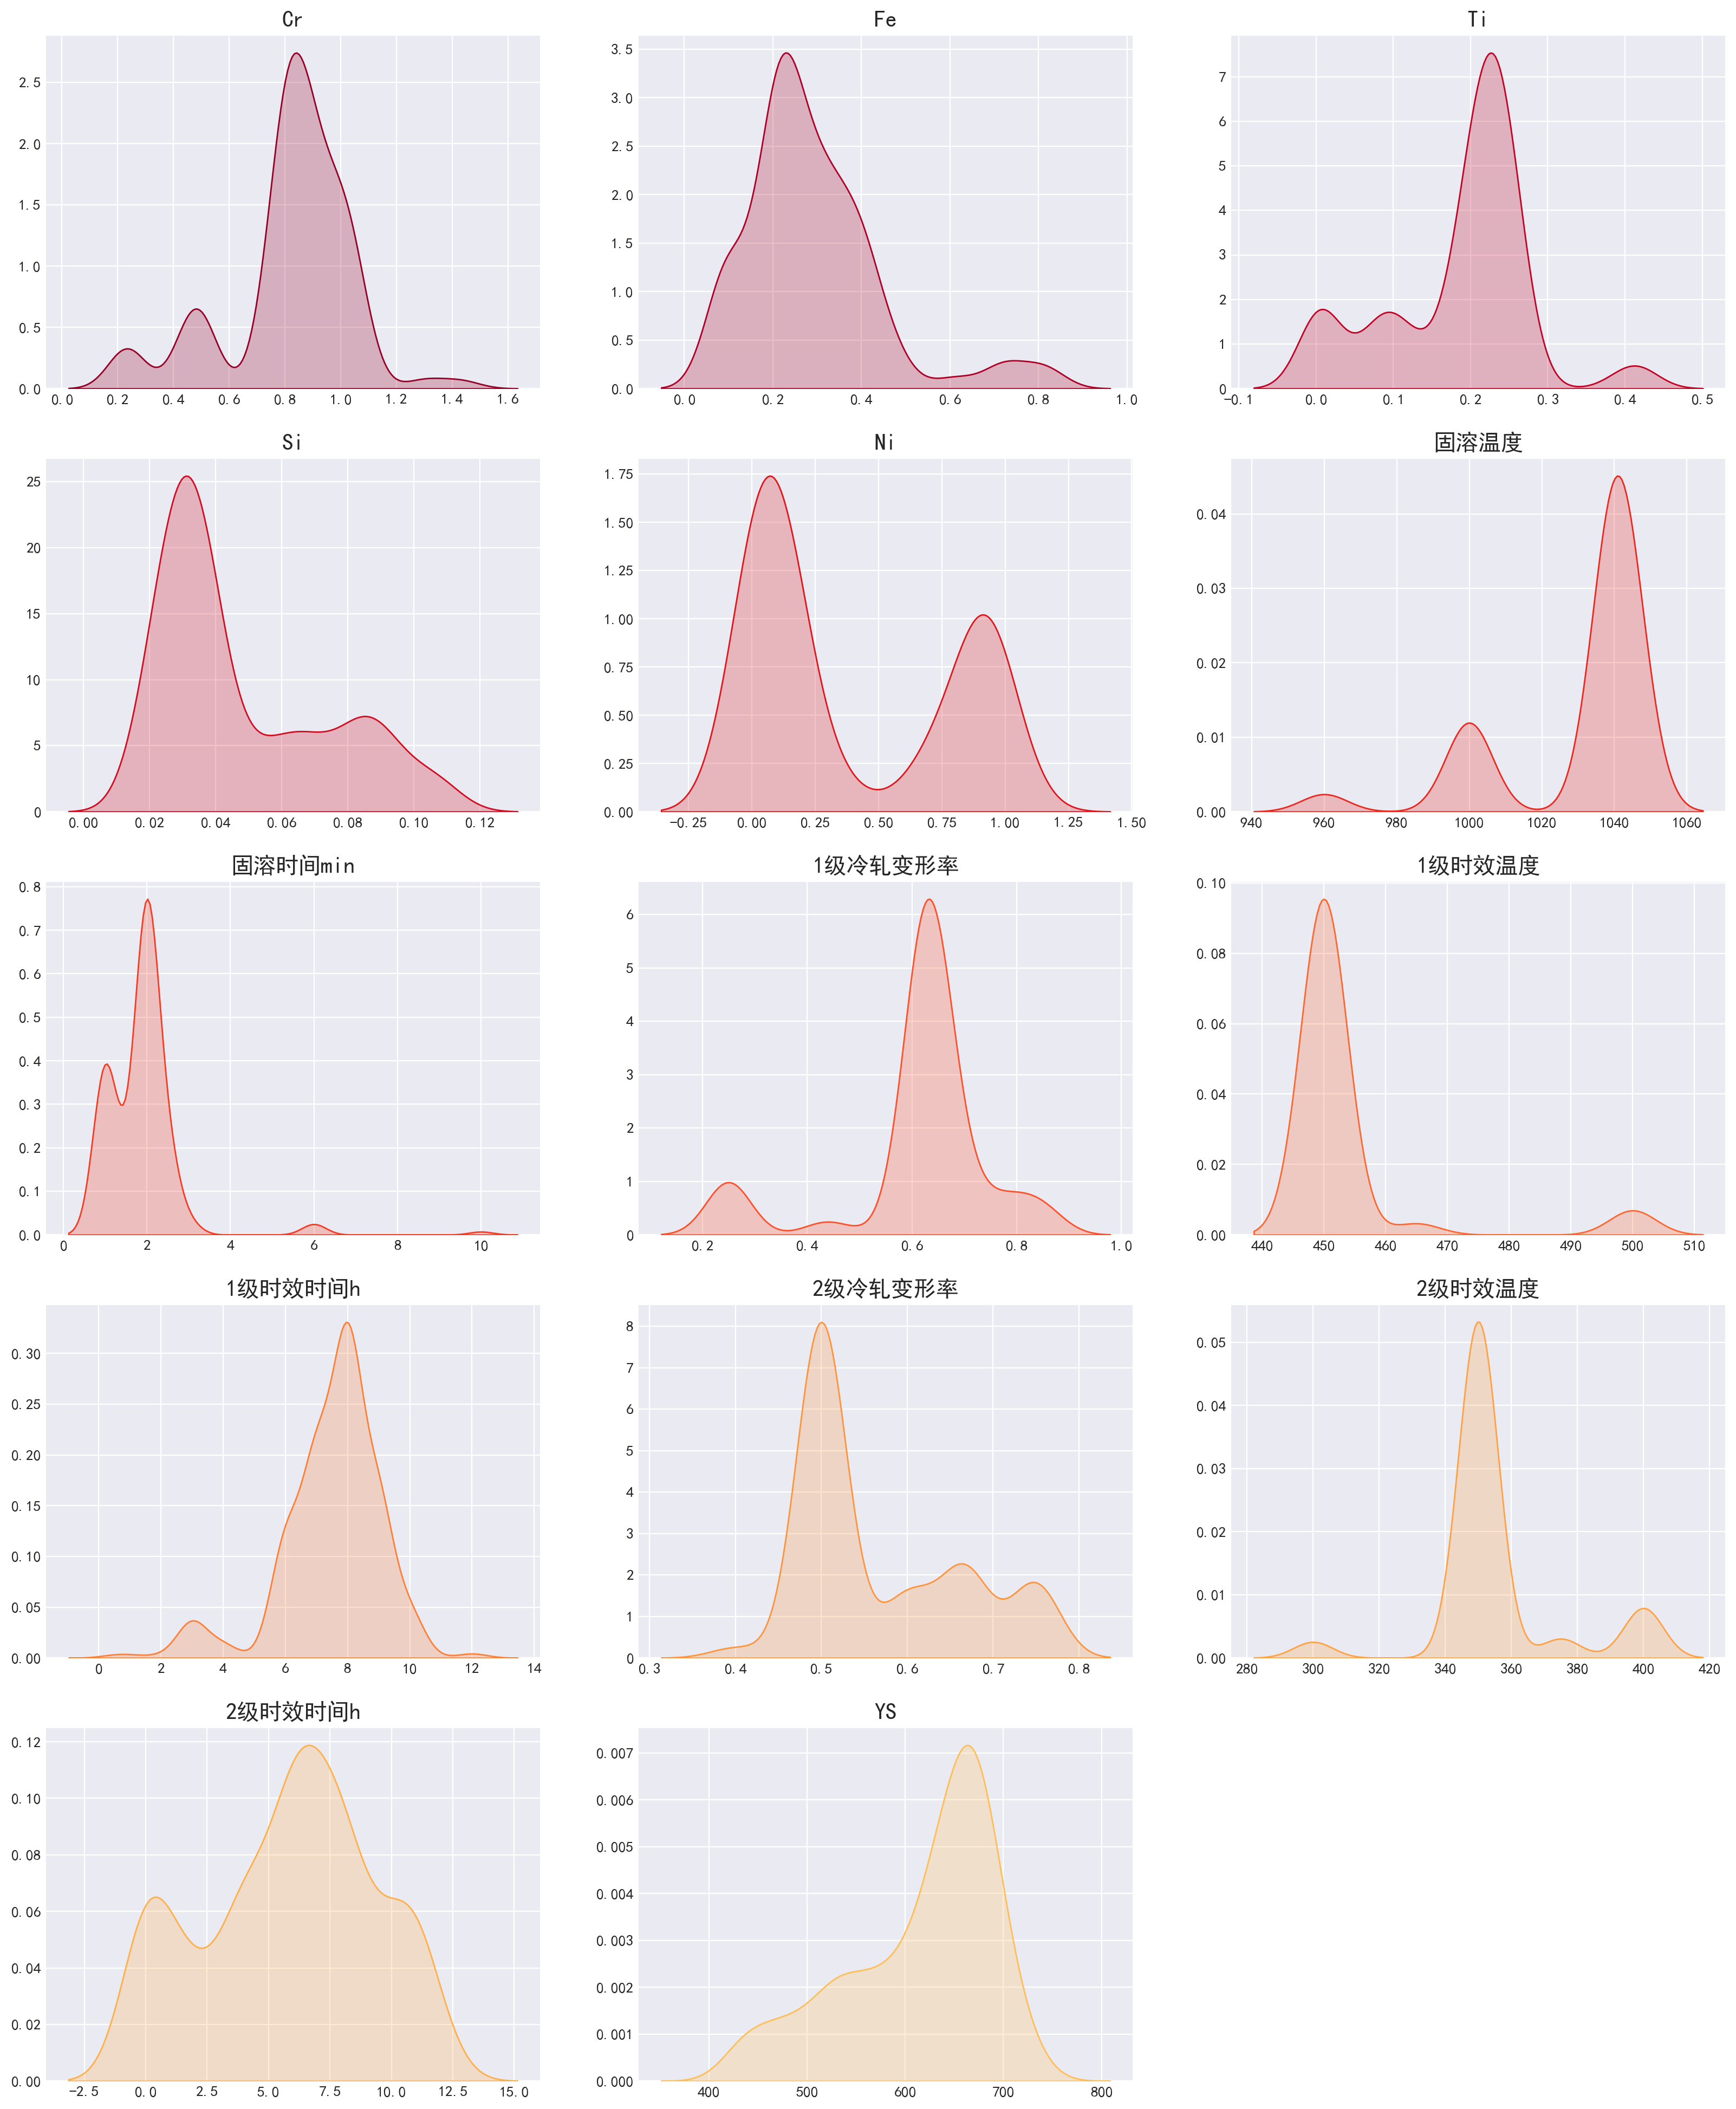

In [14]:
draw_plot(data, fig = (20, 25), draw_box = False)

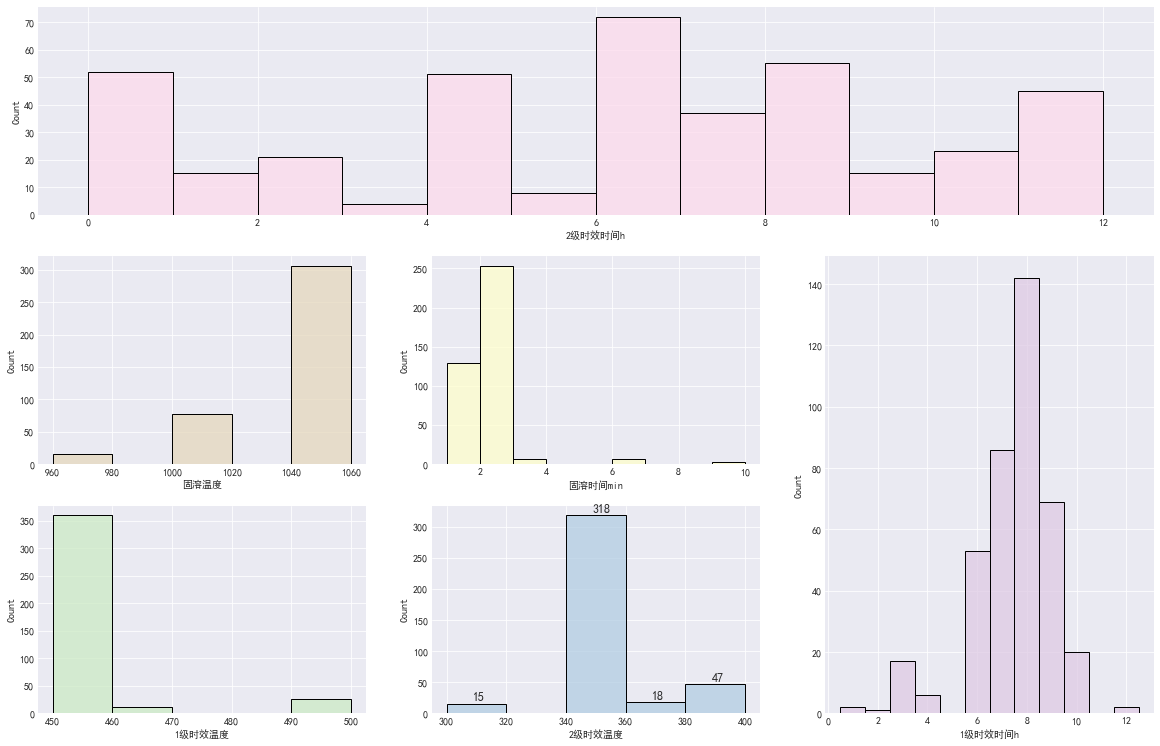

In [17]:
plt.figure(figsize = (20, 13))
ax1 = plt.subplot2grid((3, 3), (0, 0), colspan = 3)
ax2 = plt.subplot2grid((3, 3), (1, 0))
ax3 = plt.subplot2grid((3, 3), (1, 1))
ax4 = plt.subplot2grid((3, 3), (1, 2), rowspan = 2)
ax5 = plt.subplot2grid((3, 3), (2, 0))
ax6 = plt.subplot2grid((3, 3), (2, 1))
# 设置调色板
current_palette = sns.color_palette("Pastel1_r", 6)#coolwarm

for i, (ax, col) in enumerate(zip([ax1, ax2, ax3, ax4, ax5, ax6], 
                   ["2级时效时间h", "固溶温度", "固溶时间min", "1级时效时间h", "1级时效温度", "2级时效温度"])):
    # 画柱状图
    bins = len(data[col].unique())
    width = 1
    if i == 1 or i == 5:
        width = 20
    if i == 4:
        width = 10
    sns.histplot(data[col], ax = ax, bins = bins, color = current_palette[i], binwidth=width)
    
    # 标记数值
    axes = plt.gca()
    for ax_ in axes.patches:
        if ax_.get_height() > 0:
            x, y = ax_.get_x(), ax_.get_height()
            s = 1
            if i == 1 or i == 4 or i == 5:
                s = 9
            plt.annotate(f"{y}", (x+s, y+5), fontsize = 12)
plt.show()

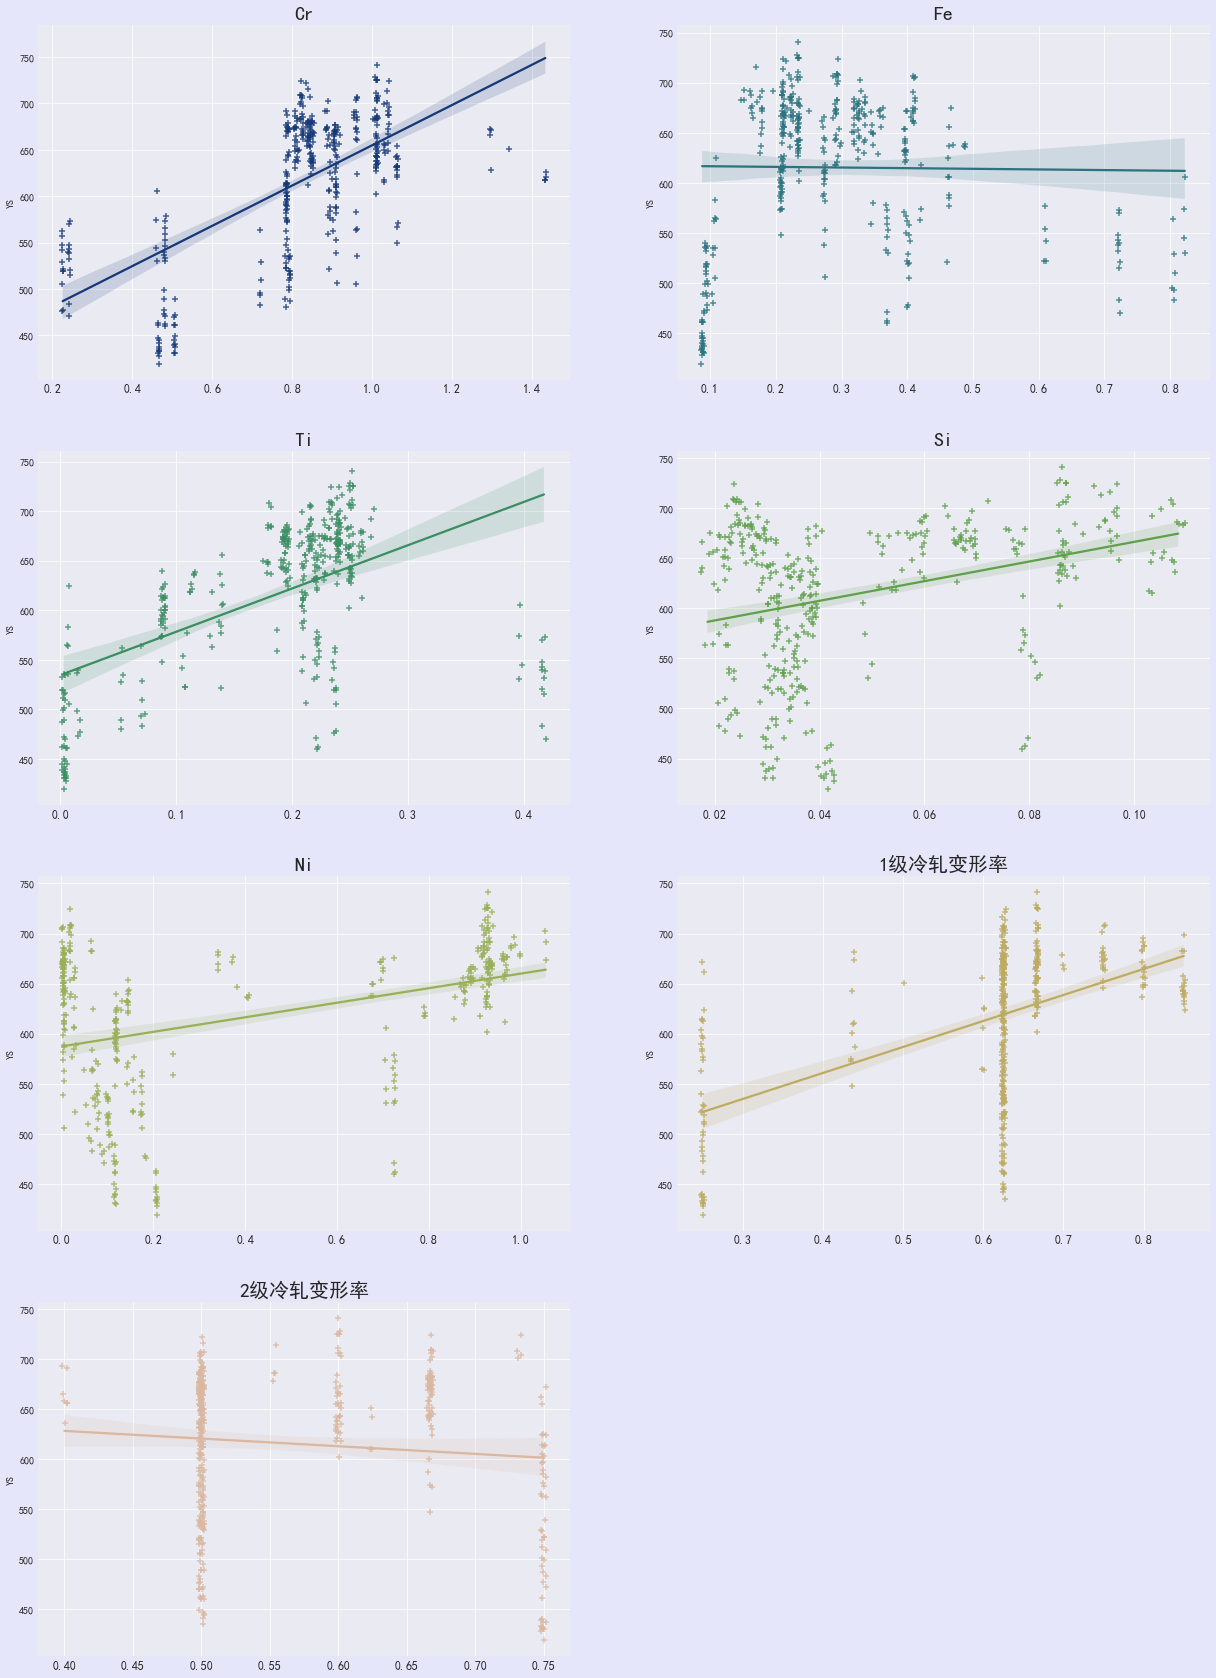

In [101]:
fig = plt.figure(figsize = (21, 30))
fig.patch.set_facecolor("lavender")
current_palette = sns.color_palette("gist_earth", 7)#plasma

#current_palette = sns.color_palette("coolwarm")
for i, col in enumerate(['Cr', 'Fe', 'Ti', 'Si', 'Ni', '1级冷轧变形率', '2级冷轧变形率']):
    ax = plt.subplot(4, 2, i+1)
    sns.regplot(x = col
                , y = "YS"
                , data = data
                , x_jitter = 0.002
                , ax = ax
                , marker = "+"
                , color = current_palette[i])
    ax.set_xlabel("")
    ax.set_title(col, fontsize = 20)
    ax.tick_params("x", labelsize = 12)

plt.show()

# 对标签YS建模

## 划分数据集

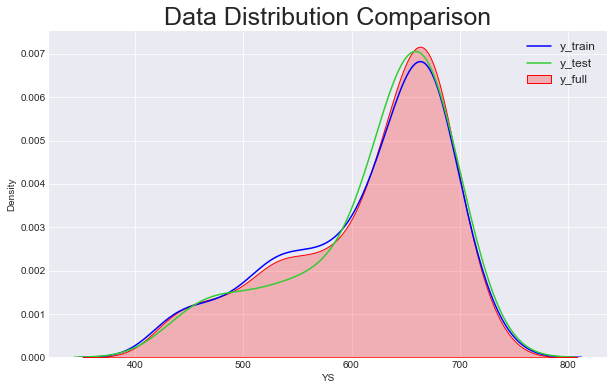

In [9]:
x_train, x_test, y_train, y_test = data_split(x = data.iloc[:, :-1], y = data.iloc[:, -1], distri_comp = True)

In [10]:
len(x_train), len(x_test)

(318, 80)

## 模型初始情况

In [11]:
rand_ = 72
init_xgb = XGB(random_state = rand_)
init_cv_df = cv_score(x_train, y_train, init_xgb, label = "YS")
init_test_df = test_score(x_train, x_test, y_train, y_test, init_xgb, label = "YS")

In [12]:
init_cv_df

,MAE,MAPE,R^2
YS_CV_Train,0.583123,0.000974,0.999854
YS_CV_Validate,13.473442,0.022411,0.941605


In [13]:
init_test_df

,YS_Test_MAE,MAPE
0,11.913167,0.019749


## 网格搜索调参

In [54]:
param_grid = {
    "n_estimators": range(50, 501, 50)
     , "learning_rate": np.arange(0.1, 0.34, 0.1)
     , "max_depth": range(2, 60, 10)
   #  , "subsample": np.linspace(0.4, 0.8, 9)
   #  , "reg_alpha": np.arange(1, 10, 0.2)
     , "reg_lambda": np.arange(1, 10, 1)
   #  , "colsample_bytree": np.linspace(0.4, 0.85, 9)
             }
cv = KFold(n_splits = 5, shuffle = True, random_state = rand_)
start = time.time()
search = GridSearchCV(estimator = init_xgb
                     , param_grid = param_grid
                     , cv = cv
                     , verbose = 2
                     , n_jobs = 32
                     , scoring = "r2"
                     , error_score = "raise").fit(x_train, y_train)
t = time.time() - start

print("【best_score: {}】".format(search.best_score_))
print("【共耗时：%dh:%dmin:%ds】" % (t/3600, (t%3600)/60, t%60))

Fitting 5 folds for each of 1620 candidates, totalling 8100 fits
【best_score: 0.9481335700292972】
【共耗时：0h:37min:6s】


In [56]:
param_grid = {
    "colsample_bytree": np.arange(0.3, 0.8, 0.1)
    , "colsample_bylevel": np.arange(0.3, 0.8, 0.1)
    , "reg_lambda": range(1, 10, 1)
}
xgb = XGB(n_estimators = 378
         , learning_rate = 0.31
         , max_depth = 2
         , random_state = rand_)
start = time.time()
search = GridSearchCV(estimator = xgb
                     , param_grid = param_grid
                     , cv = cv
                     , verbose = 2
                     , n_jobs = 32
                     , scoring = "r2"
                     , error_score = "raise").fit(x_train, y_train)
t = time.time() - start

print("【best_score: {}】".format(search.best_score_))
print("【共耗时：%dh:%dmin:%ds】" % (t/3600, (t%3600)/60, t%60))

Fitting 5 folds for each of 225 candidates, totalling 1125 fits
【best_score: 0.9512159993834242】
【共耗时：0h:0min:58s】


In [57]:
search.best_params_

{'colsample_bylevel': 0.7000000000000002,
 'colsample_bytree': 0.3,
 'reg_lambda': 1}

In [60]:
param_grid = {
    "colsample_bytree": np.arange(0.2, 0.4, 0.05)
    , "colsample_bylevel": np.arange(0.6, 0.8, 0.05)
    , "reg_lambda": np.arange(1, 3, 0.25)
}
xgb = XGB(n_estimators = 378
         , learning_rate = 0.31
         , max_depth = 2
         , random_state = rand_)
start = time.time()
search = GridSearchCV(estimator = xgb
                     , param_grid = param_grid
                     , cv = cv
                     , verbose = 2
                     , n_jobs = 32
                     , scoring = "r2"
                     , error_score = "raise").fit(x_train, y_train)
t = time.time() - start

print("【best_score: {}】".format(search.best_score_))
print("【共耗时：%dh:%dmin:%ds】" % (t/3600, (t%3600)/60, t%60))

Fitting 5 folds for each of 160 candidates, totalling 800 fits
【best_score: 0.9532136371449111】
【共耗时：0h:0min:36s】


In [61]:
search.best_params_

{'colsample_bylevel': 0.7500000000000001,
 'colsample_bytree': 0.35,
 'reg_lambda': 1.25}

In [73]:
param_grid = {
    #"subsample": np.arange(0.6, 0.85, 0.01)
    "gamma": np.arange(1, 5, 0.1)
    , "reg_alpha": np.arange(0, 2, 0.5)
}
xgb = XGB(n_estimators = 378
         , learning_rate = 0.31
         , max_depth = 2
         , colsample_bytree = 0.35
         , colsample_bylevel = 0.7500000000000001
         , reg_lambda = 1.25
         , random_state = rand_)
start = time.time()
search = GridSearchCV(estimator = xgb
                     , param_grid = param_grid
                     , cv = cv
                     , verbose = 2
                     , n_jobs = 32
                     , scoring = "r2"
                     , error_score = "raise").fit(x_train, y_train)
t = time.time() - start

print("【best_score: {}】".format(search.best_score_))
print("【共耗时：%dh:%dmin:%ds】" % (t/3600, (t%3600)/60, t%60))

Fitting 5 folds for each of 160 candidates, totalling 800 fits
【best_score: 0.9542871828775542】
【共耗时：0h:0min:36s】


In [74]:
search.best_params_

{'gamma': 3.8000000000000025, 'reg_alpha': 0.5}

In [78]:
grid_search_xgb = XGB(n_estimators = 378
                     , learning_rate = 0.31
                     , max_depth = 2
                     , colsample_bytree = 0.35
                     , colsample_bylevel = 0.7500000000000001
                     , reg_lambda = 1.25
                     , gamma = 3.8000000000000025
                     , reg_alpha = 0.5
                     , random_state = rand_)

grid_cv_df = cv_score(x_train, y_train, grid_search_xgb, label = "YS")
grid_test_df = test_score(x_train, x_test, y_train, y_test, grid_search_xgb, label = "YS")

### 网格搜索调参结果 

In [79]:
grid_res_df = init_cv_df.append(grid_cv_df)
grid_res_df.index = ["(Init) YS_CV_Train", "(Init) YS_CV_Test", 
                     "(Grid_Search) YS_CV_Train", "(Grid_Search) YS_CV_Test"]
grid_res_df

,MAE,MAPE,R^2
(Init) YS_CV_Train,0.583123,0.000974,0.999854
(Init) YS_CV_Test,13.473442,0.022411,0.941605
(Grid_Search) YS_CV_Train,5.295659,0.008950,0.991364
(Grid_Search) YS_CV_Test,12.095910,0.020248,0.954287


In [80]:
grid_res_test_df = init_test_df.append(grid_test_df)
grid_res_test_df.index = ["Init_Model", "Grid_Search_Model"]
grid_res_test_df

,YS_Test_MAE,MAPE
Init_Model,11.913167,0.019749
Grid_Search_Model,12.356586,0.020182


## 随机搜索调参

In [200]:
param_grid = {"n_estimators": range(375, 395, 1)
              , "learning_rate": np.linspace(0.16, 0.25, 15)
              , "max_depth": range(18, 25, 1)
              , "gamma": np.linspace(6.5, 7.5, 10)
              , "subsample": np.linspace(0.65, 0.75, 10)
              , "colsample_bytree": np.linspace(0.7, 0.8, 10)
              , "colsample_bylevel": np.arange(0.45, 0.55, 0.025)
              , "colsample_bynode": np.linspace(0.35, 0.45, 10)
              , "reg_lambda": np.arange(5, 6, 0.25)
              , "reg_alpha": np.arange(13, 14, 0.25)
             }

scores = []
cv = KFold(n_splits = 5, shuffle = True, random_state = rand_)
start = time.time()
for i in range(7):
    search = RandomizedSearchCV(estimator = init_xgb
                               , param_distributions = param_grid
                               , cv = cv
                               , n_jobs = 32
                               , verbose = 2
                               , scoring = "r2" 
                               , error_score = "raise").fit(x_train, y_train)
    scores.append((search.best_score_, search.best_params_))
t = time.time() - start

print("【best_score: {}】".format(search.best_score_))
print("【共耗时：%dmin:%ds】" % (t/60, t%60))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
【best_score: 0.9540486843558906】
【共耗时：0min:51s】


In [201]:
max(scores)

(0.9540486843558906,
 {'subsample': 0.7055555555555556,
  'reg_lambda': 5.25,
  'reg_alpha': 13.25,
  'n_estimators': 386,
  'max_depth': 21,
  'learning_rate': 0.19857142857142857,
  'gamma': 7.166666666666667,
  'colsample_bytree': 0.7444444444444445,
  'colsample_bynode': 0.45,
  'colsample_bylevel': 0.5250000000000001})

In [197]:
max(scores)

(0.9541275359878731,
 {'subsample': 0.7055555555555556,
  'reg_lambda': 5.25,
  'reg_alpha': 13.5,
  'n_estimators': 376,
  'max_depth': 23,
  'learning_rate': 0.19857142857142857,
  'gamma': 7.166666666666667,
  'colsample_bytree': 0.7666666666666667,
  'colsample_bynode': 0.3833333333333333,
  'colsample_bylevel': 0.47500000000000003})

In [155]:
# ==================== 调random_state ===================
max_score = 0
model = None

cv = KFold(n_splits = 5, shuffle = True, random_state = rand_)

for i in range(100):
    random_search_xgb = XGB(n_estimators = 385
                           , learning_rate = 0.2
                           , max_depth = 22
                           , gamma = 7
                           , subsample = 0.7000000000000001
                           , colsample_bytree = 0.75
                           , colsample_bynode = 0.4
                           , colsample_bylevel = 0.5
                           , reg_alpha = 13.5
                           , reg_lambda = 5.5
                           , random_state = np.random.choice(90000, replace = False))
    
    res = cross_validate(estimator = random_search_xgb
                        , X = x_train
                        , y = y_train
                        , cv = cv
                        , n_jobs = 32
                        , scoring = "r2")
    if max_score < res["test_score"].mean():
        max_score = res["test_score"].mean()
        model = random_search_xgb
        print("当前R^2最大值：【{}】".format(res["test_score"].mean()))
    if i%10 == 0 and i != 0:
        print("\t已完成({}%)...".format(i))

当前R^2最大值：【0.948229411749189】
当前R^2最大值：【0.9509112162489618】
当前R^2最大值：【0.9514869106924936】
	已完成(10%)...
当前R^2最大值：【0.9515177287234435】
当前R^2最大值：【0.9535401595565732】
	已完成(20%)...
	已完成(30%)...
	已完成(40%)...
	已完成(50%)...
	已完成(60%)...
	已完成(70%)...
	已完成(80%)...
	已完成(90%)...


In [153]:
model

XGBRegressor(base_score=None, booster=None, colsample_bylevel=0.5,
             colsample_bynode=0.4, colsample_bytree=0.75, gamma=7, gpu_id=None,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.2, max_delta_step=None, max_depth=22,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=385, n_jobs=None, num_parallel_tree=None,
             random_state=4978, reg_alpha=13.5, reg_lambda=5.5,
             scale_pos_weight=None, subsample=0.7000000000000001,
             tree_method=None, validate_parameters=None, verbosity=None)

In [14]:
random_search_xgb = XGB(n_estimators = 376
                       , learning_rate = 0.19857142857142857
                       , max_depth = 23
                       , subsample = 0.7055555555555556
                       , gamma = 7.166666666666667
                       , colsample_bytree = 0.7666666666666667
                       , colsample_bylevel = 0.47500000000000003
                       , colsample_bynode = 0.3833333333333333
                       , reg_alpha = 13.5
                       , reg_lambda = 5.25
                       , random_state = 4978)
random_cv_df = cv_score(x_train, y_train, random_search_xgb, label = "YS")
random_test_df = test_score(x_train, x_test, y_train, y_test, random_search_xgb, label = "YS")

### 随机搜索调参结果 

In [51]:
random_res_df = init_cv_df.append(random_cv_df)
random_res_df.index = ["(Init) YS_CV_Train", "(Init) YS_CV_Test", 
                     "(Ranom_Search) YS_CV_Train", "(Random_Search) YS_CV_Test"]
random_res_df

,MAE,MAPE,R^2
(Init) YS_CV_Train,0.583123,0.000974,0.999854
(Init) YS_CV_Test,13.473442,0.022411,0.941605
(Ranom_Search) YS_CV_Train,5.300038,0.008850,0.991663
(Random_Search) YS_CV_Test,12.135721,0.020173,0.952439


In [52]:
random_res_test_df = init_test_df.append(random_test_df)
random_res_test_df.index = ["Init_Model", "Random_Search_Model"]
random_res_test_df

,YS_Test_MAE,MAPE
Init_Model,11.913167,0.019749
Random_Search_Model,11.256978,0.018676


## 基于GP的贝叶斯优化

In [17]:
# step1:定义目标函数
def bayes_opt_objective(n_estimators, learning_rate, max_depth, subsample, colsample_bytree,  
                       colsample_bylevel, colsample_bynode, gamma, reg_alpha, reg_lambda):
    # 定义回归器
    xgb = XGB(n_estimators = int(n_estimators)
             , learning_rate = learning_rate
             , max_depth = int(max_depth)
             , subsample = subsample
             , colsample_bytree = colsample_bytree
             , colsample_bylevel = colsample_bylevel
             , colsample_bynode = colsample_bynode
             , gamma = gamma
             , reg_alpha = reg_alpha
             , reg_lambda = reg_lambda
             , random_state = rand_)
    # 交叉验证
    cv = KFold(n_splits = 5, shuffle = True, random_state = rand_)
    res = cross_validate(estimator = xgb
                        , X = x_train
                        , y = y_train
                        , cv = cv
                        , n_jobs = 32
                        , scoring = "r2"
                        , error_score = "raise")
    # 最大化R^2值
    return res["test_score"].mean()

# step2:定义优化流程
def param_bayes_opt(init_points = 30, n_iter = 300):
    # 定义优化器
    opt = BayesianOptimization(bayes_opt_objective # 优化的目标函数
                              , param_grid # 参数空间
                              , random_state = rand_)
    # 使用优化器求解目标函数最大值
    opt.maximize(init_points = init_points # 初始样本点的个数
                , n_iter = n_iter) # 最大迭代次数
    # 取出最优参数组合及得分
    best_params = opt.max["params"]
    best_score = opt.max["target"]
    
    print("【最佳参数组合为】", best_params)
    print("【最大R^2值】", best_score)
    
    return best_params, best_score

# step3:定义最优参数验证
def bayes_opt_validation(best_params):
    xgb = XGB(n_estimators = int(best_params["n_estimators"])
             , learning_rate = best_params["learning_rate"]
             , max_depth = int(best_params["max_depth"])
             , subsample = best_params["subsample"]
             , colsample_bytree = best_params["colsample_bytree"]
             , colsample_bylevel = best_params["colsample_bylevel"]
             , colsample_bynode = best_params["colsample_bynode"]
             , gamma = best_params["gamma"]
             , reg_alpha = best_params["reg_alpha"]
             , reg_lambda = best_params["reg_lambda"]
             , random_state = rand_)
    # 交叉验证
    cv = KFold(n_splits = 5, shuffle = True, random_state = rand_)
    res = cross_validate(estimator = xgb
                        , X = x_train
                        , y = y_train
                        , cv = cv
                        , n_jobs = 32
                        , scoring = "r2"
                        , error_score = "raise")
    
    return res["test_score"].mean()

In [203]:
# 定义参数空间
param_grid = {
    "n_estimators": (20, 600)
    , "learning_rate": (0.1, 0.45)
    , "max_depth": (2, 80)
    , "subsample": (0.3, 0.91)
    , "colsample_bytree": (0.4, 0.8)
    , "colsample_bylevel": (0.4, 0.8)
    , "colsample_bynode": (0.4, 0.8)
    , "gamma": (0.1, 4)
    , "reg_alpha": (0.1, 10)
    , "reg_lambda": (0.1, 15)
}
best_params, best_score = param_bayes_opt()

|   iter    |  target   | colsam... | colsam... | colsam... |   gamma   | learni... | max_depth | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.9418   |  0.4427   |  0.6737   |  0.614    |  1.54     |  0.2444   |  47.85    |  435.3    |  1.816    |  1.094    |  0.6054   |
|  2        |  0.9485   |  0.5729   |  0.7787   |  0.5665   |  1.065    |  0.2414   |  51.47    |  358.6    |  7.843    |  9.291    |  0.6829   |
|  3        |  0.9439   |  0.5479   |  0.4674   |  0.6981   |  1.642    |  0.3312   |  26.85    |  60.29    |  0.5841   |  6.681    |  0.7279   |
|  4        |  0.9478   |  0.7153   |  0.4949   |  0.6604   |  3.495    |  0.1737   |  12.13    |  487.2    |  0.4967   |  5.48     |  0.7125   |
|  5        |  0.9445   |  0.7309   |  0.5746   |  0.4316   |  0.4648   |  0.3423   |  64.0     |  207.0    |  3.836    |  1

|  34       |  0.9412   |  0.4      |  0.8      |  0.4607   |  4.0      |  0.1      |  36.07    |  582.7    |  10.0     |  10.18    |  0.3012   |
|  35       |  0.9492   |  0.6508   |  0.5404   |  0.4677   |  2.243    |  0.3625   |  46.84    |  550.3    |  6.023    |  8.961    |  0.7328   |
|  36       |  0.9532   |  0.4819   |  0.5206   |  0.6477   |  1.064    |  0.1966   |  59.68    |  586.3    |  9.549    |  10.91    |  0.4067   |
|  37       |  0.9436   |  0.4358   |  0.5098   |  0.7664   |  0.197    |  0.1859   |  61.77    |  545.4    |  4.345    |  1.404    |  0.379    |
|  38       |  0.9457   |  0.7381   |  0.5405   |  0.6464   |  0.782    |  0.2681   |  58.24    |  585.1    |  8.221    |  11.13    |  0.5528   |
|  39       |  0.9454   |  0.501    |  0.5494   |  0.7588   |  0.5783   |  0.414    |  60.26    |  586.2    |  7.398    |  10.51    |  0.5114   |
|  40       |  0.9408   |  0.646    |  0.7177   |  0.5319   |  1.969    |  0.3945   |  12.61    |  486.4    |  0.8282   |  3

|  68       |  0.941    |  0.4894   |  0.5216   |  0.6943   |  2.767    |  0.3249   |  47.44    |  548.2    |  4.314    |  9.641    |  0.6886   |
|  69       |  0.9498   |  0.577    |  0.5596   |  0.5953   |  2.388    |  0.3535   |  68.14    |  539.4    |  5.485    |  11.05    |  0.8276   |
|  70       |  0.943    |  0.6458   |  0.7803   |  0.6321   |  0.5787   |  0.3047   |  40.11    |  449.4    |  2.897    |  4.565    |  0.7131   |
|  71       |  0.9348   |  0.5291   |  0.7071   |  0.7328   |  2.406    |  0.4233   |  39.78    |  445.7    |  2.318    |  3.168    |  0.3691   |
|  72       |  0.9455   |  0.6734   |  0.6819   |  0.7482   |  0.8962   |  0.2344   |  42.23    |  503.6    |  7.603    |  12.74    |  0.3895   |
|  73       |  0.9453   |  0.728    |  0.7955   |  0.7229   |  0.1035   |  0.135    |  73.04    |  418.4    |  9.763    |  2.785    |  0.3329   |
|  74       |  0.9362   |  0.4153   |  0.7316   |  0.4346   |  2.247    |  0.2922   |  24.36    |  144.5    |  1.304    |  7

|  102      |  0.9494   |  0.4      |  0.4      |  0.4      |  4.0      |  0.1      |  37.29    |  460.9    |  0.1      |  11.72    |  0.91     |
|  103      |  0.9494   |  0.6466   |  0.6405   |  0.6193   |  3.962    |  0.1226   |  4.046    |  494.5    |  5.282    |  10.43    |  0.7094   |
|  104      |  0.9477   |  0.5008   |  0.4787   |  0.6232   |  1.02     |  0.1001   |  5.269    |  484.6    |  4.61     |  14.68    |  0.6585   |
|  105      |  0.9459   |  0.5171   |  0.744    |  0.6074   |  1.008    |  0.2392   |  61.83    |  593.9    |  9.65     |  3.118    |  0.7924   |
|  106      |  0.9418   |  0.4      |  0.4      |  0.4      |  4.0      |  0.1      |  70.5     |  568.1    |  9.103    |  15.0     |  0.3      |
|  107      |  0.9441   |  0.5276   |  0.7194   |  0.5875   |  3.251    |  0.4072   |  52.46    |  348.4    |  0.4434   |  11.13    |  0.8255   |
|  108      |  0.9403   |  0.6492   |  0.4014   |  0.7951   |  0.6555   |  0.2967   |  70.87    |  298.8    |  1.603    |  1

|  136      |  0.9462   |  0.7811   |  0.6595   |  0.4891   |  3.357    |  0.171    |  79.04    |  279.0    |  3.615    |  0.7459   |  0.5168   |
|  137      |  0.9427   |  0.7208   |  0.7661   |  0.4522   |  0.1274   |  0.4222   |  11.44    |  450.1    |  8.739    |  2.67     |  0.5347   |
|  138      |  0.9438   |  0.8      |  0.8      |  0.8      |  0.1      |  0.1      |  54.6     |  365.8    |  0.1      |  8.966    |  0.91     |
|  139      |  0.9504   |  0.4      |  0.4      |  0.4      |  4.0      |  0.1      |  50.07    |  564.6    |  0.1      |  15.0     |  0.91     |
|  140      |  0.9433   |  0.7556   |  0.4739   |  0.5959   |  1.831    |  0.4025   |  41.31    |  471.7    |  0.5734   |  12.28    |  0.8837   |
|  141      |  0.9473   |  0.4519   |  0.7829   |  0.4598   |  1.559    |  0.2876   |  34.85    |  491.4    |  1.381    |  10.79    |  0.3841   |
|  142      |  0.9473   |  0.4807   |  0.5461   |  0.5995   |  3.864    |  0.1742   |  50.0     |  571.3    |  0.1706   |  5

|  170      |  0.9427   |  0.6883   |  0.5462   |  0.6842   |  0.2514   |  0.3996   |  20.01    |  321.9    |  9.927    |  10.65    |  0.4707   |
|  171      |  0.9482   |  0.4      |  0.4      |  0.4      |  4.0      |  0.1      |  42.46    |  455.2    |  10.0     |  4.795    |  0.91     |
|  172      |  0.9323   |  0.4291   |  0.4534   |  0.5168   |  3.042    |  0.1092   |  2.132    |  313.6    |  1.416    |  6.646    |  0.694    |
|  173      |  0.9101   |  0.8      |  0.8      |  0.4      |  4.0      |  0.45     |  63.68    |  284.4    |  0.1      |  0.1      |  0.3      |
|  174      |  0.9423   |  0.5256   |  0.7591   |  0.4168   |  3.191    |  0.3882   |  77.9     |  291.1    |  5.12     |  12.47    |  0.3376   |
|  175      |  0.937    |  0.6064   |  0.6185   |  0.4605   |  2.019    |  0.4359   |  7.873    |  335.2    |  5.605    |  2.179    |  0.4736   |
|  176      |  0.9355   |  0.4766   |  0.6055   |  0.6061   |  2.397    |  0.1545   |  36.36    |  477.5    |  9.941    |  1

|  204      |  0.9469   |  0.739    |  0.4014   |  0.7559   |  3.677    |  0.2297   |  31.81    |  358.0    |  3.545    |  0.6702   |  0.7319   |
|  205      |  0.9477   |  0.8      |  0.8      |  0.8      |  0.1      |  0.1839   |  32.03    |  361.3    |  10.0     |  10.36    |  0.3      |
|  206      |  0.9485   |  0.8      |  0.4      |  0.8      |  0.1      |  0.1      |  45.19    |  486.1    |  0.1      |  6.55     |  0.3      |
|  207      |  0.9466   |  0.6443   |  0.7246   |  0.4      |  3.829    |  0.4038   |  5.524    |  504.6    |  4.971    |  15.0     |  0.91     |
|  208      |  0.938    |  0.8      |  0.4021   |  0.8      |  0.1      |  0.45     |  67.11    |  571.6    |  0.1      |  7.83     |  0.3      |
|  209      |  0.9462   |  0.4512   |  0.6528   |  0.56     |  2.467    |  0.2781   |  30.24    |  370.4    |  4.482    |  4.356    |  0.8259   |
|  210      |  0.9424   |  0.4      |  0.4      |  0.4      |  0.1      |  0.1      |  56.22    |  597.0    |  10.0     |  1

|  238      |  0.9479   |  0.6442   |  0.6875   |  0.4414   |  3.45     |  0.1208   |  18.35    |  596.4    |  0.107    |  9.166    |  0.7694   |
|  239      |  0.946    |  0.8      |  0.8      |  0.4      |  0.1      |  0.1      |  18.78    |  467.7    |  0.1      |  7.096    |  0.91     |
|  240      |  0.9391   |  0.515    |  0.5179   |  0.5652   |  0.6481   |  0.4433   |  49.31    |  572.6    |  0.1757   |  14.19    |  0.3386   |
|  241      |  0.9468   |  0.4638   |  0.4677   |  0.4834   |  3.231    |  0.3733   |  8.783    |  465.5    |  8.366    |  10.7     |  0.8202   |
|  242      |  0.9418   |  0.4421   |  0.6392   |  0.7277   |  3.353    |  0.3204   |  23.65    |  599.9    |  8.849    |  3.342    |  0.323    |
|  243      |  0.9431   |  0.472    |  0.6524   |  0.798    |  3.947    |  0.3532   |  12.92    |  490.6    |  9.402    |  6.868    |  0.3559   |
|  244      |  0.9224   |  0.4      |  0.4      |  0.4      |  0.1      |  0.1      |  2.0      |  327.0    |  10.0     |  1

|  272      |  0.9444   |  0.6168   |  0.5023   |  0.4141   |  1.778    |  0.1807   |  44.72    |  349.0    |  9.271    |  13.47    |  0.4793   |
|  273      |  0.9494   |  0.4      |  0.4      |  0.4      |  0.1      |  0.1      |  26.3     |  436.0    |  6.904    |  4.295    |  0.91     |
|  274      |  0.9487   |  0.7766   |  0.6607   |  0.7505   |  2.512    |  0.1571   |  20.07    |  441.4    |  9.518    |  14.56    |  0.5915   |
|  275      |  0.9462   |  0.5933   |  0.5628   |  0.4353   |  2.008    |  0.2486   |  25.14    |  429.4    |  1.512    |  5.792    |  0.3964   |
|  276      |  0.9499   |  0.5311   |  0.7288   |  0.6127   |  0.9568   |  0.1975   |  39.24    |  365.1    |  9.725    |  11.06    |  0.6984   |
|  277      |  0.9461   |  0.4801   |  0.5762   |  0.5189   |  1.342    |  0.3459   |  17.76    |  436.6    |  8.909    |  6.272    |  0.8665   |
|  278      |  0.9364   |  0.4076   |  0.751    |  0.5094   |  0.2229   |  0.4161   |  23.89    |  443.5    |  0.8755   |  1

|  306      |  0.937    |  0.8      |  0.8      |  0.4      |  0.1      |  0.1      |  2.0      |  570.3    |  0.1      |  15.0     |  0.3      |
|  307      |  0.9447   |  0.4111   |  0.6105   |  0.736    |  3.844    |  0.4414   |  34.07    |  344.2    |  0.3304   |  8.259    |  0.5977   |
|  308      |  0.9448   |  0.8      |  0.4      |  0.8      |  0.1      |  0.1      |  24.56    |  568.4    |  10.0     |  10.66    |  0.91     |
|  309      |  0.938    |  0.8      |  0.4      |  0.4      |  0.1      |  0.45     |  2.0      |  583.4    |  10.0     |  6.615    |  0.3      |
|  310      |  0.948    |  0.4      |  0.8      |  0.8      |  4.0      |  0.1      |  6.25     |  470.2    |  10.0     |  0.1      |  0.3      |
|  311      |  0.9471   |  0.4941   |  0.5021   |  0.4992   |  0.5796   |  0.2838   |  37.82    |  492.6    |  9.942    |  14.75    |  0.4833   |
|  312      |  0.9481   |  0.8      |  0.8      |  0.4      |  4.0      |  0.1      |  50.48    |  555.1    |  10.0     |  7

In [204]:
# 定义参数空间
param_grid = {
    "n_estimators": (420, 500)
    , "learning_rate": (0.08, 0.25)
    , "max_depth": (33, 50)
    , "subsample": (0.77, 0.91)
    , "colsample_bytree": (0.55, 0.7)
    , "colsample_bylevel": (0.3, 0.55)
    , "colsample_bynode": (0.45, 0.65)
    , "gamma": (1, 2.9)
    , "reg_alpha": (1, 3)
    , "reg_lambda": (2, 4.5)
}
best_params, best_score = param_bayes_opt(init_points = 50, n_iter = 500)

|   iter    |  target   | colsam... | colsam... | colsam... |   gamma   | learni... | max_depth | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.9484   |  0.3267   |  0.5869   |  0.6302   |  1.701    |  0.1501   |  42.99    |  477.3    |  1.347    |  2.167    |  0.8401   |
|  2        |  0.9492   |  0.408    |  0.6393   |  0.6124   |  1.47     |  0.1487   |  43.78    |  466.7    |  2.564    |  3.542    |  0.8579   |
|  3        |  0.9486   |  0.3925   |  0.4837   |  0.6618   |  1.751    |  0.1923   |  38.42    |  425.6    |  1.098    |  3.104    |  0.8682   |
|  4        |  0.953    |  0.4971   |  0.4975   |  0.6477   |  2.654    |  0.1158   |  35.21    |  484.4    |  1.08     |  2.903    |  0.8647   |
|  5        |  0.951    |  0.5068   |  0.5373   |  0.5619   |  1.178    |  0.1977   |  46.51    |  445.8    |  1.755    |  3

|  34       |  0.9501   |  0.4151   |  0.5466   |  0.6647   |  1.945    |  0.1564   |  41.33    |  454.7    |  2.581    |  3.233    |  0.8589   |
|  35       |  0.9477   |  0.482    |  0.562    |  0.5682   |  1.693    |  0.2083   |  42.84    |  449.9    |  1.735    |  2.531    |  0.9098   |
|  36       |  0.9495   |  0.3168   |  0.5021   |  0.6906   |  2.495    |  0.1975   |  47.39    |  437.9    |  1.165    |  4.324    |  0.8276   |
|  37       |  0.9463   |  0.4334   |  0.4617   |  0.6958   |  1.883    |  0.1986   |  33.05    |  428.2    |  1.198    |  2.482    |  0.818    |
|  38       |  0.9433   |  0.3299   |  0.5772   |  0.6881   |  2.058    |  0.2118   |  37.7     |  457.4    |  1.523    |  3.778    |  0.8423   |
|  39       |  0.9496   |  0.3964   |  0.6001   |  0.6659   |  1.418    |  0.1315   |  49.73    |  481.5    |  1.524    |  2.018    |  0.8921   |
|  40       |  0.9532   |  0.373    |  0.5796   |  0.6175   |  2.249    |  0.09957  |  35.31    |  489.0    |  2.077    |  2

|  68       |  0.9499   |  0.3102   |  0.4831   |  0.5998   |  2.237    |  0.1803   |  38.89    |  423.3    |  2.763    |  2.407    |  0.7937   |
|  69       |  0.9479   |  0.4586   |  0.5766   |  0.6225   |  2.096    |  0.2102   |  48.26    |  437.8    |  1.243    |  2.921    |  0.9053   |
|  70       |  0.9477   |  0.5001   |  0.5874   |  0.5707   |  2.033    |  0.1541   |  38.89    |  464.6    |  1.308    |  2.176    |  0.821    |
|  71       |  0.9495   |  0.5438   |  0.5145   |  0.5701   |  2.384    |  0.1262   |  49.32    |  443.0    |  2.809    |  2.323    |  0.8737   |
|  72       |  0.9524   |  0.4696   |  0.4815   |  0.6856   |  2.819    |  0.09021  |  40.99    |  465.8    |  1.205    |  2.404    |  0.8439   |
|  73       |  0.9498   |  0.3086   |  0.5483   |  0.598    |  2.15     |  0.174    |  44.19    |  483.9    |  2.176    |  2.884    |  0.883    |
|  74       |  0.9519   |  0.3956   |  0.5598   |  0.6852   |  2.772    |  0.1242   |  46.56    |  466.5    |  1.087    |  2

|  102      |  0.9493   |  0.4897   |  0.5356   |  0.6324   |  1.178    |  0.2003   |  42.29    |  461.9    |  2.307    |  3.722    |  0.8953   |
|  103      |  0.9518   |  0.5243   |  0.5799   |  0.6725   |  1.337    |  0.08833  |  35.71    |  460.1    |  1.664    |  4.269    |  0.7785   |
|  104      |  0.9514   |  0.4672   |  0.5589   |  0.6244   |  2.894    |  0.1619   |  48.24    |  456.9    |  1.843    |  2.725    |  0.8537   |
|  105      |  0.9502   |  0.4117   |  0.5632   |  0.6773   |  2.538    |  0.1205   |  39.92    |  472.0    |  2.867    |  2.142    |  0.8434   |
|  106      |  0.946    |  0.3043   |  0.5556   |  0.6521   |  2.269    |  0.2017   |  49.95    |  427.8    |  1.515    |  3.591    |  0.8316   |
|  107      |  0.9537   |  0.3662   |  0.6078   |  0.5659   |  2.037    |  0.1009   |  34.72    |  432.5    |  1.051    |  2.9      |  0.7734   |
|  108      |  0.9521   |  0.3668   |  0.5122   |  0.6052   |  2.678    |  0.1338   |  45.57    |  496.0    |  1.571    |  4

|  136      |  0.9502   |  0.4747   |  0.5429   |  0.5685   |  1.896    |  0.1095   |  44.72    |  459.2    |  1.05     |  2.311    |  0.7884   |
|  137      |  0.9502   |  0.5221   |  0.463    |  0.6962   |  2.234    |  0.155    |  40.48    |  451.0    |  2.292    |  3.298    |  0.8813   |
|  138      |  0.9474   |  0.3573   |  0.6014   |  0.6965   |  2.121    |  0.1741   |  47.25    |  474.2    |  1.753    |  2.889    |  0.8014   |
|  139      |  0.9515   |  0.3298   |  0.4994   |  0.5829   |  2.519    |  0.08696  |  49.14    |  486.1    |  2.843    |  3.325    |  0.8122   |
|  140      |  0.9497   |  0.5378   |  0.5839   |  0.6262   |  1.995    |  0.1021   |  48.43    |  459.0    |  2.733    |  2.667    |  0.8931   |
|  141      |  0.9448   |  0.5262   |  0.4796   |  0.5991   |  2.371    |  0.2313   |  40.39    |  498.9    |  2.061    |  2.959    |  0.8864   |
|  142      |  0.952    |  0.3273   |  0.5605   |  0.5768   |  2.229    |  0.1133   |  35.02    |  454.1    |  1.67     |  3

|  170      |  0.9464   |  0.3654   |  0.6261   |  0.6079   |  2.644    |  0.2154   |  40.8     |  442.7    |  2.281    |  2.439    |  0.8559   |
|  171      |  0.9509   |  0.5232   |  0.4598   |  0.5605   |  2.639    |  0.1797   |  41.79    |  476.4    |  2.384    |  3.41     |  0.8022   |
|  172      |  0.9494   |  0.528    |  0.6354   |  0.5773   |  2.393    |  0.08611  |  39.27    |  481.0    |  1.349    |  2.483    |  0.8839   |
|  173      |  0.9521   |  0.329    |  0.5721   |  0.5663   |  2.315    |  0.1037   |  36.59    |  489.5    |  1.757    |  3.724    |  0.7972   |
|  174      |  0.9398   |  0.5473   |  0.6043   |  0.693    |  1.956    |  0.2141   |  48.69    |  452.4    |  2.306    |  3.094    |  0.8831   |
|  175      |  0.9462   |  0.3596   |  0.5923   |  0.5682   |  1.86     |  0.2303   |  41.98    |  436.4    |  1.66     |  3.455    |  0.7772   |
|  176      |  0.947    |  0.5478   |  0.5588   |  0.6771   |  2.896    |  0.1449   |  37.2     |  427.9    |  2.721    |  3

|  204      |  0.9499   |  0.546    |  0.6443   |  0.6578   |  2.507    |  0.1074   |  45.02    |  494.5    |  1.228    |  3.472    |  0.8663   |
|  205      |  0.9486   |  0.308    |  0.5734   |  0.5785   |  2.894    |  0.2044   |  46.57    |  434.9    |  1.002    |  3.901    |  0.8647   |
|  206      |  0.9451   |  0.4437   |  0.538    |  0.5936   |  1.507    |  0.2377   |  46.52    |  437.2    |  2.185    |  3.316    |  0.789    |
|  207      |  0.9486   |  0.4053   |  0.5134   |  0.6359   |  1.269    |  0.1748   |  37.04    |  485.6    |  2.609    |  2.74     |  0.7815   |
|  208      |  0.9519   |  0.4123   |  0.6043   |  0.5745   |  2.266    |  0.1083   |  46.78    |  448.5    |  1.017    |  4.261    |  0.7948   |
|  209      |  0.9515   |  0.3761   |  0.5186   |  0.5828   |  2.804    |  0.1202   |  34.08    |  484.2    |  2.895    |  2.451    |  0.8165   |
|  210      |  0.9508   |  0.3627   |  0.4941   |  0.6519   |  1.119    |  0.18     |  43.83    |  495.4    |  2.134    |  4

|  238      |  0.95     |  0.4318   |  0.4682   |  0.6419   |  1.768    |  0.1389   |  48.44    |  445.2    |  1.746    |  2.404    |  0.8328   |
|  239      |  0.9528   |  0.3376   |  0.519    |  0.667    |  2.741    |  0.1705   |  41.15    |  455.2    |  2.819    |  3.92     |  0.8175   |
|  240      |  0.9495   |  0.4412   |  0.5832   |  0.6664   |  2.289    |  0.147    |  35.86    |  438.5    |  2.71     |  2.9      |  0.7895   |
|  241      |  0.9469   |  0.3835   |  0.6277   |  0.6305   |  2.771    |  0.2023   |  45.42    |  424.9    |  1.434    |  4.387    |  0.9042   |
|  242      |  0.9493   |  0.5429   |  0.4672   |  0.5895   |  1.425    |  0.1817   |  40.35    |  449.1    |  2.994    |  2.947    |  0.9053   |
|  243      |  0.9489   |  0.4528   |  0.516    |  0.6567   |  2.308    |  0.1723   |  38.96    |  444.0    |  2.435    |  3.587    |  0.8293   |
|  244      |  0.9495   |  0.5464   |  0.5358   |  0.6674   |  2.277    |  0.08651  |  33.66    |  449.0    |  1.233    |  2

|  272      |  0.9524   |  0.3125   |  0.4667   |  0.692    |  2.455    |  0.1348   |  36.56    |  429.9    |  2.514    |  4.208    |  0.8251   |
|  273      |  0.9466   |  0.322    |  0.5885   |  0.6468   |  2.447    |  0.2142   |  37.7     |  479.4    |  2.85     |  3.625    |  0.864    |
|  274      |  0.9534   |  0.3421   |  0.6329   |  0.6645   |  2.586    |  0.08797  |  37.97    |  425.4    |  2.918    |  2.576    |  0.8388   |
|  275      |  0.9477   |  0.4027   |  0.5043   |  0.577    |  2.212    |  0.2388   |  39.03    |  475.7    |  1.256    |  3.982    |  0.7878   |
|  276      |  0.9511   |  0.3229   |  0.508    |  0.5912   |  1.939    |  0.08815  |  45.83    |  464.2    |  2.282    |  3.623    |  0.8304   |
|  277      |  0.9503   |  0.3892   |  0.5462   |  0.5875   |  1.561    |  0.1316   |  46.97    |  471.7    |  1.819    |  3.91     |  0.898    |
|  278      |  0.9473   |  0.5048   |  0.464    |  0.5985   |  2.316    |  0.09156  |  43.63    |  465.1    |  2.125    |  3

|  306      |  0.9503   |  0.5096   |  0.5349   |  0.6248   |  1.077    |  0.1213   |  34.14    |  461.4    |  2.648    |  4.337    |  0.8563   |
|  307      |  0.9475   |  0.3658   |  0.4835   |  0.6307   |  2.501    |  0.1808   |  36.78    |  438.4    |  2.63     |  2.076    |  0.8612   |
|  308      |  0.9524   |  0.3786   |  0.5221   |  0.601    |  1.447    |  0.1186   |  33.79    |  478.7    |  1.39     |  3.518    |  0.7887   |
|  309      |  0.9504   |  0.4892   |  0.5214   |  0.5536   |  1.227    |  0.2105   |  47.33    |  431.7    |  2.525    |  3.002    |  0.7956   |
|  310      |  0.9478   |  0.4772   |  0.5004   |  0.5947   |  2.888    |  0.1101   |  47.22    |  485.3    |  2.906    |  4.061    |  0.9018   |
|  311      |  0.9497   |  0.5221   |  0.5326   |  0.5682   |  1.786    |  0.184    |  36.2     |  489.5    |  1.29     |  3.981    |  0.9017   |
|  312      |  0.9476   |  0.4423   |  0.5526   |  0.599    |  2.681    |  0.2046   |  37.17    |  472.2    |  1.899    |  2

|  340      |  0.9519   |  0.4762   |  0.5376   |  0.6507   |  1.998    |  0.09108  |  47.97    |  476.9    |  2.564    |  2.063    |  0.9007   |
|  341      |  0.9502   |  0.3275   |  0.6457   |  0.5932   |  2.401    |  0.1224   |  47.32    |  468.6    |  2.093    |  2.183    |  0.8925   |
|  342      |  0.9496   |  0.4796   |  0.6184   |  0.5933   |  2.582    |  0.168    |  38.15    |  461.4    |  2.851    |  4.025    |  0.8881   |
|  343      |  0.9491   |  0.5185   |  0.528    |  0.6851   |  2.732    |  0.09221  |  40.67    |  463.7    |  2.587    |  2.516    |  0.9048   |
|  344      |  0.9488   |  0.4676   |  0.5988   |  0.6698   |  1.644    |  0.2082   |  39.49    |  490.6    |  2.901    |  4.245    |  0.9045   |
|  345      |  0.9512   |  0.395    |  0.6401   |  0.6724   |  1.428    |  0.1847   |  37.53    |  470.2    |  1.555    |  3.682    |  0.8497   |
|  346      |  0.9528   |  0.3375   |  0.5371   |  0.6243   |  2.45     |  0.1549   |  39.76    |  434.1    |  1.227    |  3

|  374      |  0.951    |  0.3519   |  0.6119   |  0.6009   |  2.869    |  0.08053  |  48.82    |  495.8    |  1.991    |  4.249    |  0.8147   |
|  375      |  0.9522   |  0.3261   |  0.6188   |  0.6215   |  1.974    |  0.1625   |  42.03    |  475.6    |  1.574    |  3.318    |  0.8749   |
|  376      |  0.949    |  0.5325   |  0.6233   |  0.5987   |  1.726    |  0.1658   |  36.41    |  425.6    |  1.332    |  2.126    |  0.8955   |
|  377      |  0.9538   |  0.4389   |  0.5576   |  0.6242   |  2.093    |  0.08567  |  38.58    |  475.7    |  1.91     |  3.108    |  0.832    |
|  378      |  0.9496   |  0.3077   |  0.5708   |  0.693    |  1.352    |  0.1863   |  41.94    |  471.6    |  2.566    |  2.374    |  0.8436   |
|  379      |  0.953    |  0.4106   |  0.5483   |  0.6481   |  1.024    |  0.09946  |  49.8     |  483.8    |  2.054    |  3.805    |  0.8186   |
|  380      |  0.9483   |  0.3339   |  0.557    |  0.5506   |  1.4      |  0.2447   |  46.33    |  473.9    |  1.768    |  2

|  408      |  0.949    |  0.3379   |  0.6485   |  0.5584   |  1.558    |  0.1977   |  35.45    |  443.0    |  1.111    |  3.651    |  0.8807   |
|  409      |  0.9453   |  0.5337   |  0.5439   |  0.6175   |  2.764    |  0.1655   |  34.98    |  464.3    |  1.0      |  4.336    |  0.8869   |
|  410      |  0.9496   |  0.4956   |  0.6492   |  0.5912   |  1.331    |  0.1459   |  48.7     |  471.8    |  1.257    |  2.555    |  0.8867   |
|  411      |  0.9476   |  0.4547   |  0.5293   |  0.5923   |  1.073    |  0.2361   |  36.34    |  436.7    |  1.864    |  4.264    |  0.7976   |
|  412      |  0.9503   |  0.4383   |  0.5197   |  0.5631   |  2.524    |  0.1838   |  38.9     |  435.0    |  1.154    |  4.412    |  0.9054   |
|  413      |  0.9494   |  0.4295   |  0.5346   |  0.6754   |  1.673    |  0.1788   |  37.63    |  440.7    |  2.061    |  2.581    |  0.7984   |
|  414      |  0.9453   |  0.5303   |  0.5478   |  0.689    |  2.574    |  0.2439   |  38.07    |  475.3    |  1.242    |  2

|  442      |  0.9496   |  0.5141   |  0.6081   |  0.6018   |  1.183    |  0.1754   |  39.76    |  467.8    |  2.827    |  3.757    |  0.8317   |
|  443      |  0.9522   |  0.4195   |  0.4532   |  0.583    |  1.661    |  0.1197   |  39.07    |  438.8    |  1.996    |  3.868    |  0.8007   |
|  444      |  0.9504   |  0.4254   |  0.5689   |  0.623    |  2.493    |  0.1378   |  41.65    |  447.2    |  1.372    |  2.831    |  0.8765   |
|  445      |  0.9506   |  0.349    |  0.5132   |  0.6408   |  2.241    |  0.1337   |  35.13    |  462.4    |  1.534    |  2.221    |  0.8595   |
|  446      |  0.9494   |  0.4618   |  0.6213   |  0.6401   |  1.829    |  0.2056   |  49.42    |  443.2    |  2.314    |  2.29     |  0.8965   |
|  447      |  0.9487   |  0.4751   |  0.5391   |  0.5868   |  1.677    |  0.08214  |  44.86    |  467.8    |  2.928    |  4.47     |  0.8799   |
|  448      |  0.9533   |  0.3793   |  0.5638   |  0.6897   |  2.899    |  0.1221   |  38.35    |  433.4    |  2.951    |  3

|  476      |  0.9481   |  0.3988   |  0.527    |  0.6959   |  2.108    |  0.1474   |  38.71    |  475.5    |  2.139    |  3.079    |  0.8959   |
|  477      |  0.9507   |  0.4076   |  0.484    |  0.6803   |  2.023    |  0.1313   |  34.83    |  462.4    |  1.638    |  2.494    |  0.7797   |
|  478      |  0.9498   |  0.4671   |  0.5987   |  0.5935   |  1.352    |  0.2205   |  39.38    |  427.1    |  1.247    |  4.3      |  0.8815   |
|  479      |  0.9502   |  0.4812   |  0.6464   |  0.657    |  1.904    |  0.1922   |  41.43    |  435.2    |  2.844    |  3.639    |  0.8562   |
|  480      |  0.9495   |  0.4717   |  0.5517   |  0.557    |  2.748    |  0.1246   |  35.67    |  457.8    |  2.615    |  3.138    |  0.7917   |
|  481      |  0.947    |  0.5078   |  0.4899   |  0.5795   |  2.572    |  0.2189   |  37.22    |  423.7    |  1.835    |  2.237    |  0.806    |
|  482      |  0.9506   |  0.5275   |  0.4841   |  0.6712   |  2.887    |  0.1302   |  33.38    |  445.9    |  2.156    |  4

|  510      |  0.9445   |  0.5397   |  0.5018   |  0.6912   |  1.328    |  0.2216   |  39.27    |  482.8    |  1.999    |  2.819    |  0.8701   |
|  511      |  0.9468   |  0.3689   |  0.4934   |  0.6405   |  2.664    |  0.2252   |  37.86    |  470.0    |  2.769    |  4.008    |  0.8697   |
|  512      |  0.9501   |  0.4924   |  0.635    |  0.6093   |  1.68     |  0.199    |  36.47    |  444.9    |  2.739    |  2.645    |  0.7823   |
|  513      |  0.9501   |  0.429    |  0.618    |  0.5975   |  1.463    |  0.1336   |  45.83    |  457.7    |  1.492    |  4.464    |  0.7854   |
|  514      |  0.9517   |  0.3416   |  0.5271   |  0.6689   |  1.366    |  0.1763   |  34.88    |  493.8    |  1.747    |  2.956    |  0.819    |
|  515      |  0.9481   |  0.46     |  0.5538   |  0.6104   |  1.384    |  0.1293   |  36.65    |  436.5    |  1.896    |  4.185    |  0.8399   |
|  516      |  0.9473   |  0.3647   |  0.5489   |  0.6647   |  2.888    |  0.1894   |  46.65    |  466.3    |  1.314    |  2

|  544      |  0.9504   |  0.4565   |  0.5688   |  0.6434   |  1.086    |  0.1662   |  33.74    |  478.8    |  1.184    |  3.451    |  0.8742   |
|  545      |  0.9482   |  0.4238   |  0.5367   |  0.6692   |  2.624    |  0.1676   |  33.92    |  449.4    |  2.971    |  3.67     |  0.8173   |
|  546      |  0.9496   |  0.5273   |  0.5627   |  0.6109   |  2.037    |  0.1352   |  34.9     |  426.2    |  1.477    |  3.221    |  0.7986   |
|  547      |  0.9496   |  0.5106   |  0.6036   |  0.6085   |  1.5      |  0.2014   |  37.45    |  440.6    |  2.004    |  2.677    |  0.8042   |
|  548      |  0.9528   |  0.4607   |  0.6347   |  0.648    |  1.107    |  0.08597  |  38.44    |  457.2    |  1.579    |  3.531    |  0.9034   |
|  549      |  0.9444   |  0.5208   |  0.5071   |  0.6454   |  1.445    |  0.1754   |  41.83    |  422.9    |  1.723    |  4.038    |  0.8428   |
|  550      |  0.9449   |  0.3732   |  0.5417   |  0.6782   |  2.115    |  0.2457   |  49.61    |  463.5    |  1.159    |  4

In [206]:
# 定义参数空间
param_grid = {
    "n_estimators": (420, 460)
    , "learning_rate": (0.09, 0.19)
    , "max_depth": (40, 52)
    , "subsample": (0.75, 0.81)
    , "colsample_bytree": (0.63, 0.73)
    , "colsample_bylevel": (0.378, 0.47)
    , "colsample_bynode": (0.5, 0.6)
    , "gamma": (0.9, 1.8)
    , "reg_alpha": (2, 3)
    , "reg_lambda": (2.8, 4)
}
best_params, best_score = param_bayes_opt(init_points = 90, n_iter = 1000)

|   iter    |  target   | colsam... | colsam... | colsam... |   gamma   | learni... | max_depth | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.9503   |  0.3878   |  0.5684   |  0.6835   |  1.232    |  0.1313   |  47.05    |  448.6    |  2.173    |  2.88     |  0.78     |
|  2        |  0.9539   |  0.4178   |  0.5947   |  0.6716   |  1.123    |  0.1304   |  47.61    |  443.4    |  2.782    |  3.54     |  0.7877   |
|  3        |  0.9471   |  0.412    |  0.5168   |  0.7045   |  1.256    |  0.1561   |  43.82    |  422.8    |  2.049    |  3.33     |  0.7921   |
|  4        |  0.9497   |  0.4505   |  0.5237   |  0.6951   |  1.683    |  0.111    |  41.56    |  452.2    |  2.04     |  3.233    |  0.7906   |
|  5        |  0.9505   |  0.4541   |  0.5436   |  0.6379   |  0.9842   |  0.1592   |  49.54    |  432.9    |  2.377    |  3

|  34       |  0.9491   |  0.4203   |  0.5483   |  0.7065   |  1.348    |  0.1349   |  45.88    |  437.4    |  2.79     |  3.392    |  0.7881   |
|  35       |  0.9495   |  0.445    |  0.556    |  0.6421   |  1.228    |  0.1655   |  46.94    |  435.0    |  2.368    |  3.055    |  0.8099   |
|  36       |  0.946    |  0.3842   |  0.5261   |  0.7237   |  1.608    |  0.1591   |  50.16    |  428.9    |  2.083    |  3.915    |  0.7747   |
|  37       |  0.9461   |  0.4271   |  0.5059   |  0.7272   |  1.318    |  0.1597   |  40.04    |  424.1    |  2.099    |  3.031    |  0.7706   |
|  38       |  0.9468   |  0.389    |  0.5636   |  0.722    |  1.401    |  0.1675   |  43.32    |  438.7    |  2.262    |  3.654    |  0.781    |
|  39       |  0.9502   |  0.4135   |  0.575    |  0.7072   |  1.098    |  0.1203   |  51.81    |  450.8    |  2.262    |  2.808    |  0.8023   |
|  40       |  0.9536   |  0.4049   |  0.5648   |  0.675    |  1.492    |  0.1015   |  41.63    |  454.5    |  2.538    |  3

|  68       |  0.9534   |  0.421    |  0.5864   |  0.6591   |  0.9464   |  0.13     |  43.64    |  444.9    |  2.681    |  3.42     |  0.8066   |
|  69       |  0.9497   |  0.4271   |  0.5596   |  0.6623   |  1.769    |  0.1826   |  51.0     |  445.1    |  2.644    |  3.421    |  0.7987   |
|  70       |  0.9529   |  0.4305   |  0.5245   |  0.6572   |  1.488    |  0.1204   |  42.35    |  459.8    |  2.305    |  3.428    |  0.7569   |
|  71       |  0.9491   |  0.4533   |  0.5205   |  0.7149   |  1.447    |  0.1175   |  45.68    |  449.9    |  2.417    |  3.283    |  0.7554   |
|  72       |  0.9524   |  0.4323   |  0.5992   |  0.6605   |  1.013    |  0.139    |  51.87    |  431.1    |  2.504    |  3.021    |  0.7984   |
|  73       |  0.9503   |  0.4508   |  0.5181   |  0.6334   |  1.256    |  0.1645   |  48.4     |  437.4    |  2.062    |  3.088    |  0.7583   |
|  74       |  0.9482   |  0.4551   |  0.5104   |  0.6807   |  1.515    |  0.1863   |  51.04    |  429.7    |  2.305    |  3

|  102      |  0.9531   |  0.4074   |  0.5489   |  0.6614   |  1.232    |  0.1307   |  46.77    |  456.2    |  2.586    |  3.032    |  0.7622   |
|  103      |  0.9469   |  0.4681   |  0.5915   |  0.6955   |  1.569    |  0.1683   |  48.14    |  434.8    |  2.832    |  2.83     |  0.8006   |
|  104      |  0.9461   |  0.3847   |  0.5228   |  0.72     |  1.642    |  0.1815   |  42.87    |  425.4    |  2.149    |  3.137    |  0.7959   |
|  105      |  0.95     |  0.399    |  0.5807   |  0.6969   |  1.354    |  0.1048   |  48.76    |  424.7    |  2.592    |  3.409    |  0.8077   |
|  106      |  0.9462   |  0.4291   |  0.5368   |  0.6998   |  1.285    |  0.176    |  44.09    |  440.2    |  2.243    |  3.749    |  0.7722   |
|  107      |  0.949    |  0.428    |  0.5414   |  0.7273   |  1.436    |  0.1514   |  42.07    |  430.4    |  2.821    |  3.58     |  0.7906   |
|  108      |  0.952    |  0.3818   |  0.5165   |  0.6632   |  1.486    |  0.149    |  44.16    |  421.6    |  2.881    |  2

|  136      |  0.9511   |  0.4487   |  0.535    |  0.6457   |  1.252    |  0.1347   |  46.63    |  446.3    |  2.265    |  3.116    |  0.7834   |
|  137      |  0.9503   |  0.4624   |  0.5799   |  0.7169   |  1.257    |  0.1106   |  46.05    |  433.5    |  2.756    |  3.621    |  0.777    |
|  138      |  0.9463   |  0.4672   |  0.581    |  0.7248   |  1.181    |  0.1768   |  40.77    |  455.4    |  2.911    |  3.585    |  0.776    |
|  139      |  0.9498   |  0.4548   |  0.5128   |  0.6777   |  1.142    |  0.1596   |  42.91    |  456.1    |  2.267    |  3.8      |  0.8065   |
|  140      |  0.9491   |  0.4177   |  0.5957   |  0.7106   |  1.278    |  0.1731   |  43.03    |  453.0    |  2.491    |  3.744    |  0.7817   |
|  141      |  0.9471   |  0.3841   |  0.5938   |  0.7011   |  1.521    |  0.1802   |  42.07    |  445.8    |  2.994    |  3.646    |  0.7789   |
|  142      |  0.9487   |  0.4478   |  0.5428   |  0.6849   |  0.9842   |  0.1608   |  46.55    |  440.9    |  2.653    |  3

|  170      |  0.9463   |  0.4352   |  0.5942   |  0.7136   |  1.696    |  0.1638   |  49.67    |  436.7    |  2.421    |  3.768    |  0.8085   |
|  171      |  0.9525   |  0.4435   |  0.5401   |  0.6607   |  1.677    |  0.1025   |  42.4     |  447.4    |  2.105    |  3.269    |  0.7826   |
|  172      |  0.951    |  0.434    |  0.5939   |  0.6701   |  1.795    |  0.1578   |  41.34    |  442.3    |  2.03     |  3.884    |  0.7963   |
|  173      |  0.9533   |  0.4315   |  0.5433   |  0.6779   |  1.34     |  0.1026   |  51.61    |  443.9    |  2.196    |  3.688    |  0.7669   |
|  174      |  0.9489   |  0.4677   |  0.5833   |  0.6961   |  1.253    |  0.1025   |  41.31    |  444.6    |  2.078    |  3.392    |  0.7637   |
|  175      |  0.9542   |  0.4163   |  0.5928   |  0.6851   |  1.086    |  0.0948   |  51.24    |  445.9    |  2.158    |  3.135    |  0.7742   |
|  176      |  0.9533   |  0.4423   |  0.5465   |  0.6423   |  1.324    |  0.1073   |  48.27    |  439.6    |  2.025    |  2

|  204      |  0.9512   |  0.4536   |  0.596    |  0.6407   |  1.417    |  0.1445   |  48.87    |  420.3    |  2.481    |  2.93     |  0.7617   |
|  205      |  0.945    |  0.4564   |  0.5891   |  0.6941   |  1.47     |  0.1829   |  47.84    |  424.1    |  2.544    |  3.26     |  0.7759   |
|  206      |  0.9529   |  0.3897   |  0.5524   |  0.6473   |  1.069    |  0.109    |  44.97    |  434.9    |  2.843    |  2.878    |  0.7842   |
|  207      |  0.9538   |  0.4076   |  0.57     |  0.649    |  1.292    |  0.103    |  42.5     |  422.9    |  2.128    |  2.842    |  0.7854   |
|  208      |  0.9497   |  0.4148   |  0.5959   |  0.7016   |  1.467    |  0.1213   |  47.4     |  441.2    |  2.898    |  3.223    |  0.7716   |
|  209      |  0.9489   |  0.4298   |  0.5683   |  0.7161   |  1.396    |  0.1327   |  50.79    |  450.9    |  2.034    |  3.862    |  0.7664   |
|  210      |  0.949    |  0.4021   |  0.5881   |  0.6686   |  1.679    |  0.1696   |  45.5     |  431.4    |  2.641    |  3

|  238      |  0.9502   |  0.4286   |  0.5514   |  0.6888   |  1.428    |  0.1564   |  47.67    |  439.3    |  2.329    |  3.501    |  0.807    |
|  239      |  0.9502   |  0.4336   |  0.5519   |  0.6455   |  1.3      |  0.1523   |  42.39    |  434.9    |  2.878    |  3.486    |  0.7983   |
|  240      |  0.9492   |  0.4298   |  0.5046   |  0.6405   |  1.538    |  0.1857   |  45.31    |  420.8    |  2.68     |  3.189    |  0.8038   |
|  241      |  0.9495   |  0.4522   |  0.5257   |  0.7108   |  1.285    |  0.1021   |  51.01    |  438.7    |  2.695    |  3.726    |  0.7581   |
|  242      |  0.9503   |  0.4472   |  0.5778   |  0.6588   |  1.012    |  0.1706   |  45.54    |  452.7    |  2.072    |  3.257    |  0.8024   |
|  243      |  0.9535   |  0.4497   |  0.5531   |  0.662    |  1.603    |  0.1076   |  49.91    |  424.7    |  2.985    |  3.592    |  0.8004   |
|  244      |  0.9485   |  0.4685   |  0.5972   |  0.7019   |  1.614    |  0.1061   |  48.48    |  457.2    |  2.114    |  3

|  272      |  0.9467   |  0.4004   |  0.5631   |  0.7218   |  1.704    |  0.1504   |  48.44    |  453.6    |  2.664    |  3.56     |  0.7858   |
|  273      |  0.9494   |  0.3928   |  0.5467   |  0.6513   |  1.69     |  0.1796   |  46.37    |  456.3    |  2.333    |  3.237    |  0.8098   |
|  274      |  0.9494   |  0.4091   |  0.5615   |  0.7017   |  1.772    |  0.09231  |  41.82    |  451.6    |  2.446    |  3.329    |  0.7736   |
|  275      |  0.9494   |  0.4528   |  0.5347   |  0.6749   |  1.768    |  0.1742   |  45.84    |  427.6    |  2.802    |  3.667    |  0.7777   |
|  276      |  0.9512   |  0.4014   |  0.5737   |  0.7247   |  1.049    |  0.1125   |  40.35    |  423.5    |  2.207    |  3.961    |  0.7791   |
|  277      |  0.954    |  0.4546   |  0.5891   |  0.6783   |  1.727    |  0.1096   |  47.34    |  429.0    |  2.349    |  2.814    |  0.7834   |
|  278      |  0.9537   |  0.4265   |  0.5091   |  0.6912   |  1.264    |  0.1246   |  50.9     |  432.6    |  2.373    |  2

|  306      |  0.9498   |  0.4035   |  0.546    |  0.6403   |  1.307    |  0.1473   |  49.58    |  440.9    |  2.092    |  2.941    |  0.7656   |
|  307      |  0.9492   |  0.4677   |  0.5338   |  0.6379   |  1.574    |  0.1599   |  42.62    |  446.6    |  2.583    |  3.593    |  0.8066   |
|  308      |  0.9502   |  0.4518   |  0.5587   |  0.6316   |  1.054    |  0.1691   |  44.61    |  426.2    |  2.506    |  3.515    |  0.7672   |
|  309      |  0.9515   |  0.3927   |  0.548    |  0.6693   |  1.321    |  0.1365   |  49.53    |  427.8    |  2.562    |  3.224    |  0.8048   |
|  310      |  0.9467   |  0.4168   |  0.5172   |  0.7207   |  1.191    |  0.1527   |  48.44    |  427.5    |  2.716    |  3.083    |  0.8046   |
|  311      |  0.9505   |  0.4136   |  0.5764   |  0.7153   |  1.29     |  0.119    |  48.82    |  449.2    |  2.457    |  3.349    |  0.7769   |
|  312      |  0.95     |  0.3826   |  0.5084   |  0.7247   |  1.589    |  0.1223   |  42.51    |  424.9    |  2.757    |  3

|  340      |  0.9525   |  0.4042   |  0.544    |  0.6773   |  1.553    |  0.1482   |  46.15    |  435.3    |  2.183    |  3.6      |  0.7658   |
|  341      |  0.9527   |  0.3897   |  0.5428   |  0.6439   |  1.607    |  0.1042   |  43.96    |  452.4    |  2.444    |  3.375    |  0.7689   |
|  342      |  0.9473   |  0.4058   |  0.5031   |  0.7217   |  1.528    |  0.1521   |  45.68    |  445.2    |  2.78     |  3.153    |  0.8056   |
|  343      |  0.9463   |  0.3999   |  0.5757   |  0.7039   |  1.039    |  0.1684   |  40.94    |  437.8    |  2.012    |  3.635    |  0.7606   |
|  344      |  0.9497   |  0.4029   |  0.5694   |  0.6307   |  1.716    |  0.1687   |  50.23    |  424.4    |  2.092    |  3.253    |  0.7794   |
|  345      |  0.9468   |  0.4263   |  0.5367   |  0.7256   |  1.293    |  0.1562   |  45.88    |  431.8    |  2.111    |  3.997    |  0.7765   |
|  346      |  0.9467   |  0.4681   |  0.571    |  0.729    |  1.33     |  0.1319   |  41.91    |  445.6    |  2.438    |  2

|  374      |  0.9506   |  0.4297   |  0.5891   |  0.6316   |  1.464    |  0.1646   |  40.72    |  424.8    |  2.598    |  2.944    |  0.7639   |
|  375      |  0.9515   |  0.4155   |  0.5024   |  0.7093   |  1.485    |  0.1039   |  41.34    |  441.2    |  2.322    |  2.941    |  0.7712   |
|  376      |  0.949    |  0.4491   |  0.5974   |  0.6423   |  1.142    |  0.1669   |  51.2     |  445.2    |  2.091    |  3.1      |  0.7697   |
|  377      |  0.9507   |  0.3872   |  0.5888   |  0.635    |  1.16     |  0.1639   |  50.42    |  449.4    |  2.52     |  3.196    |  0.8037   |
|  378      |  0.9476   |  0.3989   |  0.5958   |  0.6477   |  0.9473   |  0.1483   |  50.38    |  450.7    |  2.849    |  2.873    |  0.7924   |
|  379      |  0.9524   |  0.4309   |  0.5008   |  0.6667   |  1.076    |  0.09011  |  44.29    |  432.8    |  2.496    |  3.717    |  0.7611   |
|  380      |  0.9515   |  0.4428   |  0.5438   |  0.6972   |  1.373    |  0.09652  |  50.57    |  448.5    |  2.782    |  2

|  408      |  0.951    |  0.4248   |  0.5723   |  0.705    |  1.695    |  0.1219   |  44.69    |  454.8    |  2.853    |  3.063    |  0.793    |
|  409      |  0.9485   |  0.382    |  0.5242   |  0.6419   |  1.045    |  0.1606   |  42.09    |  426.0    |  2.466    |  3.24     |  0.776    |
|  410      |  0.9536   |  0.3793   |  0.5401   |  0.633    |  1.279    |  0.1196   |  49.64    |  440.6    |  2.895    |  3.321    |  0.7974   |
|  411      |  0.9514   |  0.3998   |  0.5848   |  0.6336   |  1.572    |  0.143    |  45.62    |  436.6    |  2.312    |  3.393    |  0.775    |
|  412      |  0.9538   |  0.4208   |  0.5167   |  0.6597   |  1.248    |  0.09074  |  42.22    |  441.7    |  2.331    |  3.979    |  0.7973   |
|  413      |  0.9486   |  0.4501   |  0.5833   |  0.7022   |  0.9632   |  0.11     |  42.5     |  430.9    |  2.326    |  2.966    |  0.773    |
|  414      |  0.9535   |  0.3971   |  0.5809   |  0.6639   |  1.785    |  0.09031  |  51.17    |  457.9    |  2.496    |  3

|  442      |  0.953    |  0.3919   |  0.5211   |  0.6563   |  1.628    |  0.1123   |  51.13    |  445.3    |  2.376    |  3.937    |  0.753    |
|  443      |  0.9492   |  0.4002   |  0.58     |  0.6648   |  1.595    |  0.1568   |  46.49    |  443.2    |  2.775    |  3.278    |  0.8047   |
|  444      |  0.9519   |  0.3834   |  0.5585   |  0.7022   |  1.647    |  0.119    |  45.52    |  426.7    |  2.973    |  3.084    |  0.7868   |
|  445      |  0.955    |  0.4386   |  0.599    |  0.648    |  1.272    |  0.1272   |  47.9     |  437.3    |  2.94     |  3.513    |  0.7693   |
|  446      |  0.9489   |  0.3865   |  0.5782   |  0.6744   |  1.371    |  0.1715   |  51.39    |  443.9    |  2.32     |  3.46     |  0.7684   |
|  447      |  0.9504   |  0.4006   |  0.5004   |  0.7082   |  1.543    |  0.1076   |  46.04    |  458.7    |  2.333    |  3.559    |  0.7937   |
|  448      |  0.9507   |  0.3919   |  0.5993   |  0.6356   |  1.164    |  0.1592   |  41.73    |  431.5    |  2.056    |  3

|  476      |  0.9461   |  0.4546   |  0.5262   |  0.7093   |  0.9011   |  0.1213   |  48.02    |  438.0    |  2.04     |  3.074    |  0.7561   |
|  477      |  0.9498   |  0.4048   |  0.5638   |  0.7227   |  0.919    |  0.1216   |  50.81    |  453.2    |  2.128    |  3.416    |  0.7852   |
|  478      |  0.9521   |  0.4445   |  0.5848   |  0.6343   |  1.306    |  0.1148   |  49.75    |  438.1    |  2.945    |  3.149    |  0.7544   |
|  479      |  0.9547   |  0.4645   |  0.5082   |  0.6759   |  1.388    |  0.095    |  51.79    |  451.4    |  2.931    |  3.735    |  0.7538   |
|  480      |  0.9538   |  0.4125   |  0.5978   |  0.6741   |  1.391    |  0.1252   |  51.25    |  459.1    |  2.746    |  3.506    |  0.7835   |
|  481      |  0.9524   |  0.4518   |  0.5416   |  0.6324   |  1.246    |  0.1148   |  42.53    |  424.9    |  2.916    |  3.582    |  0.7731   |
|  482      |  0.9506   |  0.4568   |  0.579    |  0.6646   |  0.9867   |  0.1461   |  44.77    |  443.9    |  2.914    |  3

|  510      |  0.9515   |  0.4399   |  0.5695   |  0.6865   |  1.646    |  0.1086   |  43.87    |  434.8    |  2.577    |  2.898    |  0.7735   |
|  511      |  0.9488   |  0.3846   |  0.5376   |  0.719    |  1.54     |  0.1426   |  49.76    |  443.0    |  2.675    |  3.655    |  0.7901   |
|  512      |  0.9496   |  0.4268   |  0.5712   |  0.6356   |  1.203    |  0.161    |  45.77    |  451.5    |  2.475    |  2.992    |  0.7845   |
|  513      |  0.9459   |  0.4467   |  0.5819   |  0.7029   |  1.529    |  0.1811   |  51.48    |  448.3    |  2.196    |  3.67     |  0.7671   |
|  514      |  0.9508   |  0.4021   |  0.5524   |  0.6519   |  1.116    |  0.162    |  40.24    |  439.9    |  2.137    |  3.938    |  0.7685   |
|  515      |  0.9495   |  0.452    |  0.5002   |  0.6784   |  1.107    |  0.1548   |  44.21    |  454.0    |  2.541    |  3.267    |  0.7529   |
|  516      |  0.9502   |  0.4576   |  0.5656   |  0.6803   |  1.202    |  0.18     |  44.44    |  432.4    |  2.503    |  3

|  544      |  0.9503   |  0.4151   |  0.5767   |  0.7037   |  1.044    |  0.1042   |  50.1     |  448.2    |  2.926    |  3.575    |  0.7966   |
|  545      |  0.9543   |  0.4551   |  0.5199   |  0.6556   |  1.677    |  0.1073   |  50.33    |  430.3    |  2.197    |  3.675    |  0.7953   |
|  546      |  0.9535   |  0.4028   |  0.53     |  0.6629   |  1.638    |  0.1238   |  44.54    |  443.8    |  2.96     |  3.267    |  0.7528   |
|  547      |  0.954    |  0.4334   |  0.582    |  0.6557   |  1.686    |  0.1022   |  46.69    |  439.1    |  2.992    |  3.24     |  0.799    |
|  548      |  0.9505   |  0.4258   |  0.5191   |  0.6822   |  1.22     |  0.1799   |  50.74    |  447.0    |  2.033    |  3.646    |  0.7583   |
|  549      |  0.9502   |  0.4585   |  0.5599   |  0.6971   |  1.564    |  0.1067   |  48.87    |  434.4    |  2.09     |  3.228    |  0.751    |
|  550      |  0.9443   |  0.4662   |  0.5259   |  0.7242   |  1.055    |  0.1733   |  44.42    |  451.4    |  2.5      |  3

|  578      |  0.9513   |  0.3842   |  0.5437   |  0.6516   |  1.586    |  0.1469   |  48.17    |  448.4    |  2.632    |  3.388    |  0.8012   |
|  579      |  0.9541   |  0.3938   |  0.5813   |  0.6628   |  1.768    |  0.1259   |  48.87    |  454.6    |  2.075    |  3.713    |  0.7876   |
|  580      |  0.9516   |  0.4312   |  0.5133   |  0.6438   |  1.352    |  0.1445   |  44.95    |  447.7    |  2.119    |  3.682    |  0.7781   |
|  581      |  0.9497   |  0.4253   |  0.594    |  0.6942   |  1.621    |  0.09775  |  50.11    |  447.2    |  2.141    |  3.805    |  0.7644   |
|  582      |  0.9529   |  0.4154   |  0.5522   |  0.6897   |  1.785    |  0.09973  |  46.45    |  440.7    |  2.118    |  3.516    |  0.7853   |
|  583      |  0.9485   |  0.4117   |  0.5687   |  0.6766   |  0.93     |  0.1775   |  51.39    |  427.0    |  2.017    |  2.875    |  0.7638   |
|  584      |  0.9537   |  0.3929   |  0.5871   |  0.6426   |  1.7      |  0.1297   |  50.82    |  448.4    |  2.378    |  3

|  612      |  0.9544   |  0.3975   |  0.5742   |  0.6354   |  0.9481   |  0.09264  |  41.61    |  430.0    |  2.848    |  3.338    |  0.7668   |
|  613      |  0.9469   |  0.4061   |  0.5504   |  0.6982   |  1.682    |  0.1622   |  46.64    |  424.0    |  2.378    |  3.513    |  0.7656   |
|  614      |  0.9465   |  0.4387   |  0.5918   |  0.6969   |  0.9899   |  0.1651   |  50.01    |  429.3    |  2.054    |  2.939    |  0.7922   |
|  615      |  0.9494   |  0.4537   |  0.541    |  0.7132   |  1.239    |  0.0931   |  47.61    |  429.3    |  2.849    |  3.122    |  0.762    |
|  616      |  0.9531   |  0.3841   |  0.5319   |  0.6585   |  1.172    |  0.1045   |  45.03    |  455.0    |  2.764    |  3.27     |  0.7669   |
|  617      |  0.9545   |  0.4467   |  0.5324   |  0.644    |  1.369    |  0.1069   |  45.27    |  423.8    |  2.779    |  3.308    |  0.8015   |
|  618      |  0.9533   |  0.3963   |  0.5182   |  0.6356   |  0.9183   |  0.1252   |  50.19    |  423.2    |  2.478    |  3

|  646      |  0.9526   |  0.427    |  0.5934   |  0.6839   |  1.501    |  0.106    |  43.55    |  425.0    |  2.051    |  3.35     |  0.7591   |
|  647      |  0.9488   |  0.4247   |  0.5492   |  0.6592   |  1.005    |  0.1838   |  50.97    |  447.0    |  2.777    |  3.331    |  0.7808   |
|  648      |  0.9523   |  0.3855   |  0.5929   |  0.6738   |  1.678    |  0.09282  |  51.77    |  442.0    |  2.964    |  2.845    |  0.7522   |
|  649      |  0.9504   |  0.4464   |  0.524    |  0.7265   |  1.788    |  0.09913  |  45.65    |  428.1    |  2.679    |  3.754    |  0.8074   |
|  650      |  0.9469   |  0.4669   |  0.5566   |  0.7111   |  1.565    |  0.1229   |  49.95    |  422.8    |  2.099    |  3.05     |  0.7821   |
|  651      |  0.9505   |  0.4303   |  0.5873   |  0.7032   |  1.259    |  0.1005   |  40.66    |  424.0    |  2.117    |  3.997    |  0.7973   |
|  652      |  0.9507   |  0.3992   |  0.5726   |  0.7072   |  0.9889   |  0.1061   |  45.38    |  434.6    |  2.891    |  3

|  680      |  0.9496   |  0.3832   |  0.544    |  0.6697   |  1.111    |  0.1694   |  50.26    |  435.5    |  2.28     |  3.893    |  0.7858   |
|  681      |  0.954    |  0.3995   |  0.503    |  0.6884   |  1.408    |  0.1143   |  41.91    |  445.6    |  2.811    |  3.556    |  0.807    |
|  682      |  0.9537   |  0.3795   |  0.5627   |  0.6483   |  1.769    |  0.09143  |  44.49    |  444.8    |  2.763    |  3.118    |  0.7909   |
|  683      |  0.9478   |  0.4131   |  0.599    |  0.6841   |  0.9159   |  0.1558   |  41.64    |  431.8    |  2.966    |  3.105    |  0.775    |
|  684      |  0.951    |  0.387    |  0.557    |  0.6349   |  1.496    |  0.1766   |  41.23    |  430.4    |  2.687    |  3.992    |  0.7658   |
|  685      |  0.9475   |  0.4623   |  0.5262   |  0.6761   |  1.578    |  0.1803   |  46.97    |  447.5    |  2.37     |  3.151    |  0.7566   |
|  686      |  0.9493   |  0.4519   |  0.5317   |  0.6349   |  1.486    |  0.1615   |  40.16    |  434.8    |  2.309    |  3

|  714      |  0.9532   |  0.4305   |  0.5846   |  0.631    |  1.46     |  0.09764  |  41.59    |  448.6    |  2.92     |  3.9      |  0.8028   |
|  715      |  0.9523   |  0.4339   |  0.5325   |  0.6999   |  1.765    |  0.1137   |  50.14    |  456.2    |  2.671    |  3.525    |  0.7981   |
|  716      |  0.9502   |  0.4579   |  0.5226   |  0.6434   |  1.579    |  0.189    |  41.08    |  436.0    |  2.779    |  3.033    |  0.7623   |
|  717      |  0.9493   |  0.4155   |  0.5479   |  0.6968   |  1.71     |  0.1452   |  41.52    |  420.2    |  2.538    |  3.798    |  0.7752   |
|  718      |  0.9514   |  0.3786   |  0.5506   |  0.7099   |  1.228    |  0.1002   |  42.65    |  453.1    |  2.137    |  3.359    |  0.7703   |
|  719      |  0.9466   |  0.4235   |  0.5224   |  0.7168   |  1.194    |  0.1869   |  50.92    |  456.5    |  2.285    |  3.188    |  0.7928   |
|  720      |  0.952    |  0.4439   |  0.5143   |  0.6847   |  1.201    |  0.1325   |  45.05    |  421.1    |  2.622    |  2

|  748      |  0.9469   |  0.4189   |  0.5505   |  0.6435   |  1.316    |  0.1604   |  43.65    |  455.0    |  2.53     |  3.145    |  0.7957   |
|  749      |  0.954    |  0.3786   |  0.5515   |  0.6421   |  1.731    |  0.09843  |  40.05    |  455.8    |  2.592    |  3.311    |  0.7938   |
|  750      |  0.9498   |  0.4514   |  0.5977   |  0.6799   |  1.059    |  0.1617   |  42.64    |  450.3    |  2.879    |  3.196    |  0.7517   |
|  751      |  0.9487   |  0.4037   |  0.5176   |  0.7019   |  1.755    |  0.1326   |  44.25    |  443.8    |  2.585    |  2.887    |  0.7883   |
|  752      |  0.9482   |  0.4201   |  0.5486   |  0.6421   |  1.487    |  0.1584   |  41.1     |  430.1    |  2.828    |  3.048    |  0.7784   |
|  753      |  0.9495   |  0.3843   |  0.5959   |  0.7275   |  1.541    |  0.1183   |  47.63    |  459.6    |  2.735    |  3.264    |  0.7635   |
|  754      |  0.953    |  0.4574   |  0.5831   |  0.6714   |  1.065    |  0.1157   |  49.55    |  447.9    |  2.426    |  3

|  782      |  0.9481   |  0.4477   |  0.5939   |  0.6463   |  1.442    |  0.1623   |  50.19    |  438.8    |  2.122    |  3.728    |  0.7986   |
|  783      |  0.9463   |  0.4068   |  0.5159   |  0.7248   |  1.617    |  0.1891   |  45.49    |  444.2    |  2.585    |  3.678    |  0.8083   |
|  784      |  0.9485   |  0.4305   |  0.5476   |  0.6586   |  0.9127   |  0.187    |  50.4     |  443.4    |  2.746    |  3.558    |  0.789    |
|  785      |  0.948    |  0.396    |  0.5618   |  0.6965   |  1.491    |  0.1605   |  40.73    |  455.0    |  2.499    |  3.067    |  0.7863   |
|  786      |  0.949    |  0.4292   |  0.5131   |  0.6893   |  1.018    |  0.1785   |  43.85    |  445.3    |  2.557    |  3.741    |  0.7984   |
|  787      |  0.9511   |  0.4637   |  0.5712   |  0.6751   |  1.169    |  0.1754   |  44.59    |  448.0    |  2.793    |  2.973    |  0.8082   |
|  788      |  0.954    |  0.4694   |  0.5874   |  0.6396   |  1.013    |  0.1218   |  45.04    |  431.6    |  2.331    |  2

|  816      |  0.9467   |  0.4347   |  0.552    |  0.6932   |  1.687    |  0.186    |  43.42    |  422.2    |  2.604    |  3.244    |  0.7752   |
|  817      |  0.9519   |  0.4277   |  0.5442   |  0.6744   |  1.691    |  0.1397   |  42.14    |  420.3    |  2.451    |  2.842    |  0.7665   |
|  818      |  0.954    |  0.3797   |  0.5459   |  0.6708   |  0.9727   |  0.1237   |  40.05    |  432.0    |  2.573    |  3.599    |  0.805    |
|  819      |  0.9496   |  0.4215   |  0.5071   |  0.6655   |  0.9032   |  0.1843   |  49.21    |  447.3    |  2.662    |  3.413    |  0.7728   |
|  820      |  0.953    |  0.4489   |  0.571    |  0.6412   |  1.147    |  0.09729  |  42.7     |  428.1    |  2.929    |  3.929    |  0.7588   |
|  821      |  0.9467   |  0.4088   |  0.5251   |  0.6505   |  1.294    |  0.1645   |  48.94    |  437.8    |  2.488    |  3.168    |  0.7737   |
|  822      |  0.9481   |  0.4698   |  0.5167   |  0.7222   |  1.339    |  0.1555   |  46.07    |  428.5    |  2.588    |  2

|  850      |  0.952    |  0.4616   |  0.5881   |  0.6695   |  1.378    |  0.1218   |  47.79    |  457.0    |  2.102    |  3.444    |  0.7734   |
|  851      |  0.949    |  0.4683   |  0.5312   |  0.7031   |  1.34     |  0.1139   |  42.52    |  456.5    |  2.126    |  3.315    |  0.7914   |
|  852      |  0.949    |  0.4325   |  0.5999   |  0.7154   |  1.263    |  0.1323   |  43.75    |  437.1    |  2.163    |  2.998    |  0.7884   |
|  853      |  0.9515   |  0.4137   |  0.5297   |  0.6705   |  1.212    |  0.1399   |  49.67    |  420.8    |  2.745    |  2.926    |  0.7846   |
|  854      |  0.952    |  0.4456   |  0.5544   |  0.6717   |  1.211    |  0.1385   |  49.03    |  425.1    |  2.193    |  3.631    |  0.7762   |
|  855      |  0.9529   |  0.3861   |  0.5086   |  0.6846   |  1.274    |  0.1003   |  44.1     |  450.5    |  2.426    |  3.727    |  0.7564   |
|  856      |  0.9539   |  0.458    |  0.5198   |  0.6555   |  1.139    |  0.09249  |  45.12    |  443.3    |  2.088    |  2

|  884      |  0.9489   |  0.4003   |  0.5881   |  0.663    |  1.235    |  0.1774   |  42.44    |  430.4    |  2.64     |  2.809    |  0.7895   |
|  885      |  0.952    |  0.4412   |  0.5903   |  0.6729   |  1.031    |  0.1281   |  47.19    |  442.0    |  2.401    |  3.039    |  0.7659   |
|  886      |  0.9493   |  0.3962   |  0.549    |  0.6309   |  1.526    |  0.183    |  48.14    |  444.2    |  2.476    |  3.375    |  0.7806   |
|  887      |  0.9523   |  0.4265   |  0.511    |  0.6553   |  1.03     |  0.1209   |  50.67    |  451.8    |  2.447    |  3.907    |  0.7541   |
|  888      |  0.9496   |  0.4363   |  0.5644   |  0.7272   |  1.488    |  0.1182   |  45.9     |  441.3    |  2.493    |  3.291    |  0.756    |
|  889      |  0.953    |  0.3914   |  0.576    |  0.6823   |  1.111    |  0.09797  |  40.74    |  456.3    |  2.408    |  3.867    |  0.7989   |
|  890      |  0.9512   |  0.3803   |  0.5182   |  0.6913   |  1.479    |  0.1277   |  40.52    |  441.9    |  2.524    |  2

|  918      |  0.9485   |  0.4017   |  0.5243   |  0.6524   |  1.746    |  0.1747   |  47.5     |  437.7    |  2.671    |  3.173    |  0.7768   |
|  919      |  0.9495   |  0.4096   |  0.5796   |  0.6533   |  1.069    |  0.1713   |  45.52    |  434.5    |  2.571    |  3.677    |  0.7642   |
|  920      |  0.9538   |  0.4585   |  0.5003   |  0.6668   |  1.261    |  0.09544  |  48.23    |  454.3    |  2.141    |  3.618    |  0.781    |
|  921      |  0.9492   |  0.3894   |  0.5558   |  0.6366   |  1.724    |  0.1716   |  46.55    |  427.6    |  2.782    |  3.819    |  0.79     |
|  922      |  0.9494   |  0.4457   |  0.5291   |  0.6935   |  1.517    |  0.09418  |  45.66    |  454.6    |  2.992    |  3.116    |  0.7958   |
|  923      |  0.9493   |  0.4159   |  0.5206   |  0.6432   |  1.222    |  0.163    |  50.39    |  455.8    |  2.51     |  3.481    |  0.8009   |
|  924      |  0.9546   |  0.4483   |  0.5377   |  0.6646   |  1.594    |  0.1212   |  49.16    |  443.7    |  2.775    |  3

|  952      |  0.9514   |  0.4396   |  0.5148   |  0.6789   |  1.564    |  0.14     |  44.26    |  424.0    |  2.004    |  3.735    |  0.7883   |
|  953      |  0.9489   |  0.3827   |  0.5259   |  0.6865   |  1.171    |  0.1703   |  44.5     |  437.7    |  2.013    |  3.675    |  0.7922   |
|  954      |  0.9469   |  0.4332   |  0.5478   |  0.6602   |  0.9253   |  0.166    |  43.39    |  427.6    |  2.754    |  3.396    |  0.7847   |
|  955      |  0.9532   |  0.4638   |  0.5965   |  0.6844   |  1.622    |  0.1075   |  49.29    |  445.1    |  2.994    |  3.068    |  0.7597   |
|  956      |  0.9511   |  0.4425   |  0.5781   |  0.729    |  1.056    |  0.09232  |  45.5     |  459.5    |  2.012    |  3.646    |  0.7527   |
|  957      |  0.9509   |  0.4239   |  0.5849   |  0.6443   |  1.522    |  0.1383   |  40.92    |  430.1    |  2.295    |  3.249    |  0.8024   |
|  958      |  0.9522   |  0.4113   |  0.5519   |  0.6696   |  1.2      |  0.138    |  50.02    |  450.3    |  2.595    |  3

|  986      |  0.9495   |  0.4629   |  0.5839   |  0.7191   |  0.9991   |  0.1036   |  50.84    |  424.5    |  2.496    |  3.126    |  0.7767   |
|  987      |  0.9464   |  0.4369   |  0.5448   |  0.7118   |  1.419    |  0.1431   |  47.67    |  448.1    |  2.706    |  3.998    |  0.7743   |
|  988      |  0.9468   |  0.3972   |  0.5458   |  0.7109   |  1.562    |  0.1609   |  46.95    |  441.7    |  2.661    |  3.764    |  0.7863   |
|  989      |  0.9529   |  0.4335   |  0.5057   |  0.6711   |  1.559    |  0.1146   |  42.69    |  432.2    |  2.374    |  3.852    |  0.7689   |
|  990      |  0.9541   |  0.4427   |  0.5542   |  0.6922   |  1.294    |  0.09528  |  41.26    |  455.3    |  2.134    |  3.267    |  0.7863   |
|  991      |  0.9465   |  0.3955   |  0.503    |  0.6713   |  1.132    |  0.1844   |  40.17    |  451.5    |  2.303    |  3.374    |  0.771    |
|  992      |  0.9532   |  0.3977   |  0.5379   |  0.6767   |  1.298    |  0.09959  |  48.28    |  438.5    |  2.104    |  2

|  1020     |  0.9539   |  0.4541   |  0.5412   |  0.6527   |  1.397    |  0.1225   |  50.99    |  456.9    |  2.479    |  3.278    |  0.7603   |
|  1021     |  0.9528   |  0.4592   |  0.5666   |  0.6616   |  1.129    |  0.1042   |  49.19    |  440.4    |  2.102    |  2.941    |  0.7753   |
|  1022     |  0.9504   |  0.4577   |  0.5931   |  0.6988   |  1.437    |  0.1006   |  46.33    |  450.5    |  2.087    |  3.051    |  0.7534   |
|  1023     |  0.9521   |  0.4351   |  0.5092   |  0.6311   |  1.405    |  0.1341   |  41.88    |  452.8    |  2.137    |  3.693    |  0.7805   |
|  1024     |  0.9506   |  0.4372   |  0.5988   |  0.6867   |  1.236    |  0.1448   |  48.08    |  429.4    |  2.156    |  2.859    |  0.8094   |
|  1025     |  0.9484   |  0.4554   |  0.5194   |  0.7211   |  1.567    |  0.1275   |  50.7     |  455.8    |  2.22     |  3.37     |  0.7842   |
|  1026     |  0.9472   |  0.4189   |  0.5582   |  0.7233   |  1.503    |  0.1514   |  40.61    |  441.5    |  2.414    |  3

|  1054     |  0.9491   |  0.3997   |  0.5938   |  0.6975   |  1.25     |  0.144    |  45.0     |  436.7    |  2.467    |  3.057    |  0.764    |
|  1055     |  0.9547   |  0.4179   |  0.5878   |  0.6772   |  0.9246   |  0.1234   |  47.23    |  438.3    |  2.89     |  3.903    |  0.7947   |
|  1056     |  0.9511   |  0.4354   |  0.5491   |  0.7049   |  1.735    |  0.1112   |  40.15    |  437.1    |  2.433    |  3.928    |  0.8072   |
|  1057     |  0.9511   |  0.4209   |  0.5354   |  0.6907   |  1.272    |  0.1448   |  44.71    |  450.2    |  2.422    |  3.854    |  0.7873   |
|  1058     |  0.9479   |  0.4434   |  0.5646   |  0.7045   |  1.451    |  0.1861   |  40.05    |  447.6    |  2.38     |  3.952    |  0.7609   |
|  1059     |  0.9529   |  0.4001   |  0.5877   |  0.6403   |  0.9075   |  0.09242  |  51.48    |  450.3    |  2.457    |  3.89     |  0.7536   |
|  1060     |  0.954    |  0.4273   |  0.5253   |  0.6594   |  1.057    |  0.1014   |  48.19    |  452.1    |  2.82     |  2

|  1088     |  0.9529   |  0.3926   |  0.5695   |  0.6806   |  1.032    |  0.1187   |  46.96    |  425.3    |  2.308    |  3.585    |  0.7691   |
|  1089     |  0.9444   |  0.4588   |  0.516    |  0.7281   |  1.392    |  0.1843   |  42.73    |  439.4    |  2.864    |  3.733    |  0.8039   |
|  1090     |  0.9477   |  0.4093   |  0.5007   |  0.6415   |  1.711    |  0.1613   |  40.7     |  421.4    |  2.974    |  3.159    |  0.7836   |
【最佳参数组合为】 {'colsample_bylevel': 0.4299330497789392, 'colsample_bynode': 0.518051099752577, 'colsample_bytree': 0.6371242878860596, 'gamma': 1.1915923606371486, 'learning_rate': 0.09657170213511002, 'max_depth': 44.131613089237064, 'n_estimators': 433.6942360211161, 'reg_alpha': 2.066630689303985, 'reg_lambda': 3.0740823604764564, 'subsample': 0.7900598922401424}
【最大R^2值】 0.95578508850236


In [154]:
# 定义参数空间
param_grid = {
    "n_estimators": (430, 436)
    , "learning_rate": (0.094, 0.099)
    , "max_depth": (42, 46)
    , "subsample": (0.78, 0.81)
    , "gamma": (1.17, 1.23)
    , "colsample_bytree": (0.634, 0.64)
    , "colsample_bylevel": (0.41, 0.432)
    , "colsample_bynode": (0.51, 0.521)
    , "reg_alpha": (1.99, 2.1)
    , "reg_lambda": (2.99, 3.12)
}
best_params, best_score = param_bayes_opt(110, 1000)

|   iter    |  target   | colsam... | colsam... | colsam... |   gamma   | learni... | max_depth | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.9539   |  0.4123   |  0.5175   |  0.6372   |  1.192    |  0.09606  |  44.35    |  434.3    |  2.009    |  2.999    |  0.795    |
|  2        |  0.9548   |  0.4195   |  0.5204   |  0.6365   |  1.185    |  0.09602  |  44.54    |  433.5    |  2.076    |  3.07     |  0.7988   |
|  3        |  0.9538   |  0.4181   |  0.5119   |  0.6385   |  1.194    |  0.0973   |  43.27    |  430.4    |  1.995    |  3.047    |  0.801    |
|  4        |  0.9544   |  0.4273   |  0.5126   |  0.6379   |  1.222    |  0.09505  |  42.52    |  434.8    |  1.994    |  3.037    |  0.8003   |
|  5        |  0.954    |  0.4282   |  0.5148   |  0.6345   |  1.176    |  0.09746  |  45.18    |  431.9    |  2.032    |  3

|  34       |  0.9544   |  0.4201   |  0.5153   |  0.6386   |  1.2      |  0.09625  |  43.96    |  432.6    |  2.077    |  3.054    |  0.799    |
|  35       |  0.9541   |  0.426    |  0.5162   |  0.6347   |  1.192    |  0.09777  |  44.31    |  432.2    |  2.03     |  3.018    |  0.8099   |
|  36       |  0.9538   |  0.4115   |  0.5129   |  0.6396   |  1.217    |  0.09746  |  45.39    |  431.3    |  1.999    |  3.111    |  0.7923   |
|  37       |  0.9533   |  0.4217   |  0.5106   |  0.6398   |  1.198    |  0.09749  |  42.01    |  430.6    |  2.001    |  3.015    |  0.7903   |
|  38       |  0.9531   |  0.4126   |  0.517    |  0.6395   |  1.203    |  0.09788  |  43.11    |  432.8    |  2.019    |  3.082    |  0.7955   |
|  39       |  0.9539   |  0.4185   |  0.5183   |  0.6386   |  1.183    |  0.09551  |  45.94    |  434.6    |  2.019    |  2.991    |  0.8062   |
|  40       |  0.9544   |  0.4164   |  0.5171   |  0.6367   |  1.209    |  0.09458  |  42.54    |  435.2    |  2.049    |  3

|  68       |  0.9543   |  0.4203   |  0.5195   |  0.6357   |  1.173    |  0.096    |  43.21    |  433.7    |  2.065    |  3.057    |  0.8083   |
|  69       |  0.9539   |  0.4217   |  0.5166   |  0.6359   |  1.228    |  0.09863  |  45.67    |  433.8    |  2.061    |  3.057    |  0.8044   |
|  70       |  0.9542   |  0.4225   |  0.5127   |  0.6356   |  1.209    |  0.09552  |  42.78    |  436.0    |  2.024    |  3.058    |  0.7834   |
|  71       |  0.9536   |  0.428    |  0.5123   |  0.6391   |  1.206    |  0.09537  |  43.89    |  434.5    |  2.036    |  3.042    |  0.7827   |
|  72       |  0.9534   |  0.423    |  0.5209   |  0.6358   |  1.178    |  0.09645  |  45.96    |  431.7    |  2.045    |  3.014    |  0.8042   |
|  73       |  0.9529   |  0.4274   |  0.512    |  0.6342   |  1.194    |  0.09773  |  44.8     |  432.6    |  1.997    |  3.021    |  0.7842   |
|  74       |  0.9546   |  0.4284   |  0.5111   |  0.637    |  1.211    |  0.09881  |  45.68    |  431.5    |  2.024    |  3

|  102      |  0.9548   |  0.41     |  0.5171   |  0.6341   |  1.198    |  0.09607  |  44.1     |  430.8    |  2.084    |  3.052    |  0.7939   |
|  103      |  0.9538   |  0.4164   |  0.5177   |  0.6379   |  1.211    |  0.09865  |  42.75    |  431.4    |  2.095    |  3.02     |  0.7901   |
|  104      |  0.955    |  0.4298   |  0.5147   |  0.6371   |  1.173    |  0.09517  |  45.29    |  435.8    |  2.071    |  3.064    |  0.8021   |
|  105      |  0.9553   |  0.4183   |  0.5123   |  0.6396   |  1.22     |  0.0951   |  43.57    |  433.5    |  2.063    |  3.022    |  0.7907   |
|  106      |  0.9541   |  0.4236   |  0.5148   |  0.6393   |  1.217    |  0.09598  |  43.92    |  430.5    |  2.043    |  3.079    |  0.8013   |
|  107      |  0.955    |  0.4294   |  0.5128   |  0.6369   |  1.2      |  0.09504  |  44.81    |  433.9    |  2.029    |  3.032    |  0.7918   |
|  108      |  0.9541   |  0.4197   |  0.5147   |  0.6378   |  1.219    |  0.09754  |  42.6     |  432.6    |  2.056    |  3

|  136      |  0.9541   |  0.4222   |  0.5179   |  0.6357   |  1.219    |  0.09537  |  43.81    |  434.2    |  2.006    |  3.108    |  0.8062   |
|  137      |  0.9534   |  0.4224   |  0.5154   |  0.6345   |  1.22     |  0.09794  |  43.91    |  433.4    |  2.096    |  3.1      |  0.7944   |
|  138      |  0.9532   |  0.4174   |  0.519    |  0.6396   |  1.204    |  0.09825  |  43.97    |  432.6    |  2.096    |  3.05     |  0.8027   |
|  139      |  0.9533   |  0.4184   |  0.5134   |  0.6357   |  1.179    |  0.09813  |  43.6     |  430.3    |  2.066    |  3.079    |  0.7866   |
|  140      |  0.9545   |  0.4299   |  0.5158   |  0.6395   |  1.208    |  0.09461  |  45.47    |  434.1    |  2.046    |  3.017    |  0.8017   |
|  141      |  0.9534   |  0.4163   |  0.5116   |  0.6373   |  1.194    |  0.09652  |  44.13    |  433.6    |  2.054    |  3.016    |  0.7853   |
|  142      |  0.9552   |  0.419    |  0.5105   |  0.6375   |  1.179    |  0.09722  |  45.93    |  434.0    |  2.038    |  3

|  170      |  0.9537   |  0.4258   |  0.513    |  0.6391   |  1.17     |  0.0971   |  45.56    |  433.0    |  1.992    |  3.091    |  0.7831   |
|  171      |  0.9534   |  0.4171   |  0.5193   |  0.6364   |  1.228    |  0.09694  |  43.41    |  435.8    |  2.015    |  3.032    |  0.8082   |
|  172      |  0.9541   |  0.4268   |  0.5166   |  0.6356   |  1.189    |  0.09401  |  45.99    |  430.2    |  2.096    |  3.119    |  0.7937   |
|  173      |  0.9541   |  0.4203   |  0.5157   |  0.6386   |  1.197    |  0.09428  |  44.2     |  430.8    |  2.092    |  3.051    |  0.8054   |
|  174      |  0.9536   |  0.4304   |  0.5183   |  0.6397   |  1.195    |  0.09849  |  43.84    |  431.3    |  2.095    |  3.038    |  0.808    |
|  175      |  0.9537   |  0.4269   |  0.5113   |  0.6377   |  1.228    |  0.09423  |  45.32    |  434.9    |  2.098    |  3.091    |  0.81     |
|  176      |  0.9546   |  0.4204   |  0.511    |  0.6391   |  1.188    |  0.09875  |  42.16    |  435.2    |  2.055    |  3

|  204      |  0.9541   |  0.417    |  0.5117   |  0.6353   |  1.218    |  0.09438  |  42.36    |  430.1    |  2.068    |  3.024    |  0.7985   |
|  205      |  0.9548   |  0.4316   |  0.5122   |  0.638    |  1.216    |  0.09425  |  44.23    |  432.8    |  1.999    |  3.002    |  0.7964   |
|  206      |  0.9541   |  0.4102   |  0.5148   |  0.6357   |  1.198    |  0.09539  |  45.95    |  432.3    |  2.047    |  3.013    |  0.8004   |
|  207      |  0.9556   |  0.4121   |  0.5207   |  0.6393   |  1.186    |  0.09534  |  44.71    |  432.0    |  2.025    |  3.111    |  0.8045   |
|  208      |  0.9535   |  0.4238   |  0.5177   |  0.6358   |  1.209    |  0.09605  |  44.35    |  432.8    |  2.036    |  3.048    |  0.7801   |
|  209      |  0.9537   |  0.417    |  0.5188   |  0.6395   |  1.218    |  0.09531  |  43.21    |  433.1    |  2.091    |  3.091    |  0.808    |
|  210      |  0.9545   |  0.4224   |  0.519    |  0.6393   |  1.215    |  0.09677  |  43.92    |  435.5    |  2.074    |  3

|  238      |  0.9531   |  0.4256   |  0.5112   |  0.6353   |  1.222    |  0.09636  |  42.57    |  435.7    |  2.026    |  3.069    |  0.8076   |
|  239      |  0.9536   |  0.4319   |  0.5159   |  0.6386   |  1.224    |  0.09883  |  42.21    |  431.9    |  2.093    |  3.037    |  0.8076   |
|  240      |  0.9545   |  0.4134   |  0.5118   |  0.6367   |  1.208    |  0.09562  |  45.35    |  432.7    |  2.027    |  3.087    |  0.7863   |
|  241      |  0.9548   |  0.4166   |  0.5149   |  0.6398   |  1.192    |  0.09513  |  43.83    |  430.3    |  2.051    |  3.001    |  0.7991   |
|  242      |  0.9549   |  0.418    |  0.5204   |  0.638    |  1.196    |  0.09899  |  44.16    |  432.0    |  2.046    |  3.05     |  0.7981   |
|  243      |  0.9537   |  0.4279   |  0.5153   |  0.6398   |  1.176    |  0.09648  |  42.22    |  434.3    |  2.079    |  3.019    |  0.8016   |
|  244      |  0.9548   |  0.4186   |  0.5158   |  0.6394   |  1.189    |  0.09583  |  43.75    |  432.9    |  2.057    |  3

|  272      |  0.9542   |  0.4205   |  0.5138   |  0.6358   |  1.198    |  0.09577  |  45.14    |  435.8    |  2.039    |  3.039    |  0.7977   |
|  273      |  0.9538   |  0.4273   |  0.5165   |  0.6375   |  1.21     |  0.09662  |  44.14    |  430.1    |  2.039    |  3.056    |  0.8019   |
|  274      |  0.9536   |  0.4163   |  0.5143   |  0.6383   |  1.171    |  0.09831  |  42.85    |  431.6    |  2.035    |  3.004    |  0.7881   |
|  275      |  0.9545   |  0.4164   |  0.5208   |  0.6397   |  1.184    |  0.0954   |  42.33    |  433.3    |  2.091    |  3.081    |  0.7982   |
|  276      |  0.9545   |  0.4118   |  0.5158   |  0.6381   |  1.224    |  0.0979   |  43.23    |  433.9    |  1.995    |  3.039    |  0.7925   |
|  277      |  0.9542   |  0.4204   |  0.5151   |  0.6393   |  1.173    |  0.09529  |  45.36    |  430.9    |  2.07     |  3.047    |  0.7834   |
|  278      |  0.9535   |  0.4121   |  0.52     |  0.6344   |  1.193    |  0.0968   |  42.15    |  435.5    |  2.067    |  3

|  306      |  0.9536   |  0.4271   |  0.5193   |  0.6377   |  1.212    |  0.0975   |  42.35    |  435.8    |  2.008    |  3.092    |  0.7946   |
|  307      |  0.955    |  0.4211   |  0.5151   |  0.6379   |  1.178    |  0.09549  |  42.8     |  431.2    |  2.037    |  3.119    |  0.7959   |
|  308      |  0.9545   |  0.4292   |  0.5123   |  0.638    |  1.201    |  0.09587  |  44.46    |  433.1    |  2.096    |  3.023    |  0.7972   |
|  309      |  0.954    |  0.4102   |  0.5168   |  0.6362   |  1.214    |  0.09758  |  45.0     |  430.1    |  2.087    |  3.041    |  0.8073   |
|  310      |  0.9536   |  0.421    |  0.5169   |  0.637    |  1.207    |  0.09829  |  42.68    |  430.9    |  2.022    |  3.046    |  0.8065   |
|  311      |  0.9543   |  0.4299   |  0.5174   |  0.6353   |  1.23     |  0.09458  |  43.7     |  433.9    |  2.042    |  2.999    |  0.7885   |
|  312      |  0.9545   |  0.414    |  0.518    |  0.6363   |  1.211    |  0.09756  |  45.09    |  433.9    |  1.995    |  3

|  340      |  0.9532   |  0.4268   |  0.5118   |  0.6368   |  1.221    |  0.09833  |  45.73    |  432.9    |  2.024    |  3.048    |  0.8069   |
|  341      |  0.9536   |  0.4271   |  0.5182   |  0.6364   |  1.173    |  0.09777  |  44.3     |  435.8    |  2.089    |  2.995    |  0.7801   |
|  342      |  0.9534   |  0.414    |  0.5136   |  0.6383   |  1.222    |  0.0947   |  45.83    |  430.2    |  2.066    |  3.114    |  0.7805   |
|  343      |  0.9536   |  0.4122   |  0.5194   |  0.637    |  1.215    |  0.09417  |  44.74    |  431.5    |  2.004    |  3.092    |  0.8095   |
|  344      |  0.9536   |  0.415    |  0.5167   |  0.6371   |  1.187    |  0.09511  |  43.72    |  430.1    |  2.065    |  3.059    |  0.807    |
|  345      |  0.9541   |  0.4196   |  0.5193   |  0.6353   |  1.211    |  0.09757  |  43.6     |  435.4    |  1.994    |  3.119    |  0.7857   |
|  346      |  0.9532   |  0.4233   |  0.5119   |  0.6359   |  1.176    |  0.09876  |  42.68    |  434.7    |  2.007    |  3

|  374      |  0.9537   |  0.412    |  0.5199   |  0.6396   |  1.189    |  0.09812  |  42.65    |  431.6    |  2.063    |  3.06     |  0.7873   |
|  375      |  0.954    |  0.4207   |  0.5113   |  0.6387   |  1.199    |  0.09558  |  45.07    |  434.6    |  2.094    |  3.014    |  0.8068   |
|  376      |  0.9536   |  0.4248   |  0.511    |  0.6392   |  1.223    |  0.09769  |  42.14    |  430.7    |  2.036    |  2.992    |  0.801    |
|  377      |  0.9539   |  0.4285   |  0.5137   |  0.6352   |  1.186    |  0.09602  |  44.94    |  435.9    |  2.044    |  3.011    |  0.8063   |
|  378      |  0.9538   |  0.4223   |  0.5136   |  0.6388   |  1.191    |  0.09881  |  44.14    |  433.1    |  1.995    |  3.082    |  0.8071   |
|  379      |  0.9537   |  0.4266   |  0.511    |  0.6392   |  1.203    |  0.0949   |  43.74    |  435.2    |  2.092    |  3.111    |  0.7865   |
|  380      |  0.9544   |  0.4312   |  0.5169   |  0.6362   |  1.214    |  0.09622  |  43.74    |  431.7    |  2.069    |  3

|  408      |  0.953    |  0.4171   |  0.5178   |  0.6387   |  1.213    |  0.09862  |  42.87    |  435.0    |  2.0      |  2.996    |  0.7862   |
|  409      |  0.9531   |  0.4305   |  0.5146   |  0.6368   |  1.214    |  0.0983   |  45.91    |  432.6    |  2.082    |  3.071    |  0.785    |
|  410      |  0.955    |  0.4154   |  0.5152   |  0.6375   |  1.186    |  0.0941   |  42.19    |  434.9    |  2.047    |  3.078    |  0.8034   |
|  411      |  0.9531   |  0.4154   |  0.5182   |  0.638    |  1.199    |  0.09409  |  43.17    |  433.9    |  1.999    |  3.062    |  0.7819   |
|  412      |  0.9534   |  0.4316   |  0.5172   |  0.6354   |  1.22     |  0.09787  |  42.1     |  435.9    |  2.047    |  3.038    |  0.7994   |
|  413      |  0.9524   |  0.4177   |  0.5147   |  0.6376   |  1.229    |  0.09806  |  42.11    |  431.5    |  2.056    |  3.064    |  0.783    |
|  414      |  0.9532   |  0.4156   |  0.518    |  0.6383   |  1.226    |  0.09682  |  44.62    |  432.8    |  2.065    |  3

|  442      |  0.9529   |  0.4282   |  0.5141   |  0.6368   |  1.193    |  0.09653  |  42.72    |  431.2    |  2.024    |  3.055    |  0.8069   |
|  443      |  0.9537   |  0.4208   |  0.5128   |  0.6347   |  1.19     |  0.09856  |  45.15    |  431.1    |  2.028    |  3.052    |  0.8049   |
|  444      |  0.9536   |  0.4275   |  0.5185   |  0.6395   |  1.207    |  0.09838  |  43.56    |  431.0    |  2.073    |  2.992    |  0.7963   |
|  445      |  0.9531   |  0.413    |  0.5204   |  0.6392   |  1.209    |  0.09772  |  45.47    |  433.9    |  2.022    |  2.998    |  0.7851   |
|  446      |  0.954    |  0.4113   |  0.5195   |  0.6393   |  1.18     |  0.09898  |  45.47    |  434.9    |  2.041    |  3.086    |  0.8086   |
|  447      |  0.9536   |  0.4227   |  0.5101   |  0.6342   |  1.208    |  0.09432  |  45.78    |  433.9    |  2.089    |  3.034    |  0.7847   |
|  448      |  0.9538   |  0.418    |  0.5194   |  0.6379   |  1.219    |  0.09723  |  42.34    |  432.5    |  2.024    |  3

|  476      |  0.9539   |  0.4254   |  0.5198   |  0.6393   |  1.2      |  0.09629  |  45.43    |  433.1    |  2.012    |  3.067    |  0.8082   |
|  477      |  0.9534   |  0.4216   |  0.5198   |  0.6399   |  1.202    |  0.09856  |  43.57    |  433.1    |  1.998    |  3.051    |  0.797    |
|  478      |  0.9539   |  0.4276   |  0.5153   |  0.6363   |  1.179    |  0.09781  |  45.72    |  431.5    |  2.092    |  3.053    |  0.7891   |
|  479      |  0.9545   |  0.4317   |  0.5156   |  0.6352   |  1.212    |  0.09863  |  45.34    |  431.5    |  2.03     |  3.058    |  0.7898   |
|  480      |  0.9536   |  0.4319   |  0.5113   |  0.6383   |  1.211    |  0.09878  |  45.62    |  433.4    |  2.005    |  3.002    |  0.7962   |
|  481      |  0.954    |  0.4132   |  0.5148   |  0.636    |  1.219    |  0.09629  |  42.29    |  433.3    |  2.026    |  3.102    |  0.7832   |
|  482      |  0.9546   |  0.4191   |  0.5166   |  0.6399   |  1.171    |  0.09693  |  45.18    |  433.5    |  2.088    |  3

|  510      |  0.9537   |  0.4287   |  0.5131   |  0.6377   |  1.172    |  0.09436  |  44.9     |  432.5    |  2.087    |  3.109    |  0.7891   |
|  511      |  0.9547   |  0.4174   |  0.5191   |  0.6362   |  1.196    |  0.09586  |  45.21    |  435.4    |  2.072    |  3.104    |  0.7984   |
|  512      |  0.9537   |  0.4126   |  0.5179   |  0.6375   |  1.184    |  0.09705  |  43.22    |  435.9    |  2.04     |  3.011    |  0.7839   |
|  513      |  0.9539   |  0.4197   |  0.5154   |  0.6349   |  1.183    |  0.09572  |  42.25    |  431.4    |  2.032    |  3.097    |  0.801    |
|  514      |  0.954    |  0.4147   |  0.519    |  0.6399   |  1.204    |  0.09763  |  42.25    |  433.5    |  2.031    |  3.109    |  0.7974   |
|  515      |  0.9546   |  0.4187   |  0.5179   |  0.6348   |  1.203    |  0.09478  |  43.67    |  432.9    |  2.062    |  3.006    |  0.8008   |
|  516      |  0.9543   |  0.4143   |  0.5197   |  0.6398   |  1.229    |  0.09895  |  42.71    |  435.5    |  2.079    |  3

|  544      |  0.9534   |  0.4115   |  0.5145   |  0.6355   |  1.208    |  0.09668  |  45.75    |  435.0    |  1.997    |  3.119    |  0.806    |
|  545      |  0.9529   |  0.4289   |  0.514    |  0.6367   |  1.214    |  0.09544  |  43.77    |  435.5    |  2.012    |  3.018    |  0.7826   |
|  546      |  0.9533   |  0.4177   |  0.5174   |  0.6394   |  1.213    |  0.09685  |  43.32    |  433.1    |  1.995    |  3.066    |  0.7822   |
|  547      |  0.9542   |  0.4121   |  0.5144   |  0.6348   |  1.217    |  0.0962   |  45.31    |  434.6    |  2.055    |  3.011    |  0.8049   |
|  548      |  0.9538   |  0.4147   |  0.5176   |  0.6357   |  1.187    |  0.09424  |  42.11    |  432.6    |  2.016    |  3.118    |  0.784    |
|  549      |  0.9537   |  0.4105   |  0.518    |  0.6346   |  1.205    |  0.09467  |  42.83    |  434.2    |  2.047    |  3.114    |  0.8096   |
|  550      |  0.9541   |  0.4302   |  0.5185   |  0.6376   |  1.204    |  0.09754  |  43.42    |  435.1    |  2.093    |  3

|  578      |  0.9536   |  0.4131   |  0.5196   |  0.6356   |  1.223    |  0.09773  |  45.81    |  435.1    |  2.006    |  3.119    |  0.7833   |
|  579      |  0.954    |  0.4165   |  0.5192   |  0.6395   |  1.219    |  0.09698  |  43.47    |  434.8    |  2.089    |  3.021    |  0.7931   |
|  580      |  0.9548   |  0.4234   |  0.5172   |  0.6346   |  1.176    |  0.09711  |  43.91    |  430.4    |  2.015    |  3.021    |  0.7853   |
|  581      |  0.9546   |  0.4223   |  0.5145   |  0.6349   |  1.175    |  0.09524  |  42.35    |  433.7    |  2.051    |  3.065    |  0.796    |
|  582      |  0.9537   |  0.4231   |  0.5191   |  0.6368   |  1.228    |  0.09808  |  42.8     |  431.1    |  2.084    |  3.099    |  0.7999   |
|  583      |  0.9541   |  0.4224   |  0.512    |  0.6344   |  1.189    |  0.09433  |  43.38    |  432.1    |  1.997    |  3.02     |  0.8      |
|  584      |  0.9548   |  0.4225   |  0.5137   |  0.6382   |  1.206    |  0.09436  |  45.55    |  433.1    |  2.04     |  3

|  612      |  0.9536   |  0.4317   |  0.5133   |  0.6345   |  1.206    |  0.0942   |  42.89    |  430.0    |  2.01     |  3.039    |  0.7871   |
|  613      |  0.9532   |  0.4115   |  0.5201   |  0.6364   |  1.189    |  0.09649  |  42.41    |  431.2    |  2.07     |  3.013    |  0.7958   |
|  614      |  0.9538   |  0.4212   |  0.5152   |  0.636    |  1.184    |  0.09578  |  42.41    |  435.8    |  2.055    |  3.076    |  0.7945   |
|  615      |  0.9529   |  0.4194   |  0.512    |  0.6377   |  1.195    |  0.09779  |  42.84    |  430.4    |  2.002    |  3.061    |  0.7898   |
|  616      |  0.9537   |  0.4229   |  0.5116   |  0.637    |  1.18     |  0.09693  |  44.22    |  432.2    |  2.09     |  3.023    |  0.7882   |
|  617      |  0.9545   |  0.4227   |  0.5194   |  0.6393   |  1.214    |  0.09876  |  44.39    |  433.3    |  2.056    |  3.001    |  0.7928   |
|  618      |  0.9536   |  0.4245   |  0.516    |  0.6345   |  1.224    |  0.09882  |  42.65    |  433.2    |  2.006    |  3

|  646      |  0.9538   |  0.4125   |  0.5192   |  0.6387   |  1.2      |  0.09874  |  42.02    |  431.9    |  2.093    |  3.016    |  0.7813   |
|  647      |  0.9533   |  0.4104   |  0.5206   |  0.6386   |  1.219    |  0.09777  |  43.33    |  431.7    |  2.057    |  3.086    |  0.7832   |
|  648      |  0.9542   |  0.4273   |  0.5183   |  0.6399   |  1.215    |  0.09776  |  44.23    |  435.9    |  2.088    |  3.055    |  0.7974   |
|  649      |  0.9544   |  0.4221   |  0.5145   |  0.6366   |  1.217    |  0.09476  |  45.76    |  431.6    |  2.036    |  3.033    |  0.7946   |
|  650      |  0.9538   |  0.4205   |  0.5119   |  0.6398   |  1.208    |  0.09404  |  44.41    |  435.0    |  2.016    |  3.063    |  0.7862   |
|  651      |  0.9537   |  0.4136   |  0.5126   |  0.6375   |  1.21     |  0.09837  |  43.64    |  433.0    |  2.072    |  3.014    |  0.8092   |
|  652      |  0.9535   |  0.4135   |  0.5177   |  0.6379   |  1.222    |  0.09688  |  43.07    |  431.3    |  2.087    |  3

|  680      |  0.9547   |  0.4208   |  0.5121   |  0.6367   |  1.173    |  0.09409  |  44.7     |  430.8    |  1.999    |  3.004    |  0.7991   |
|  681      |  0.9538   |  0.4102   |  0.5188   |  0.638    |  1.188    |  0.09866  |  45.43    |  434.8    |  1.995    |  3.027    |  0.8032   |
|  682      |  0.9549   |  0.4293   |  0.5191   |  0.6352   |  1.204    |  0.09681  |  44.6     |  431.9    |  2.071    |  3.074    |  0.7946   |
|  683      |  0.9542   |  0.4233   |  0.5107   |  0.6395   |  1.174    |  0.09459  |  42.81    |  432.1    |  2.064    |  3.065    |  0.8059   |
|  684      |  0.9546   |  0.4177   |  0.5109   |  0.6395   |  1.174    |  0.09431  |  45.18    |  430.9    |  2.079    |  3.072    |  0.8044   |
|  685      |  0.9546   |  0.4187   |  0.5109   |  0.6384   |  1.185    |  0.09456  |  42.84    |  433.3    |  2.06     |  3.118    |  0.7942   |
|  686      |  0.9534   |  0.4243   |  0.5118   |  0.6371   |  1.184    |  0.09762  |  42.56    |  435.9    |  2.073    |  3

|  714      |  0.9542   |  0.4308   |  0.5186   |  0.6379   |  1.18     |  0.09511  |  44.34    |  434.4    |  2.067    |  3.057    |  0.7871   |
|  715      |  0.9536   |  0.4278   |  0.5161   |  0.6354   |  1.175    |  0.09603  |  45.47    |  430.5    |  2.091    |  3.041    |  0.8076   |
|  716      |  0.9532   |  0.4303   |  0.5188   |  0.6378   |  1.18     |  0.09812  |  43.75    |  431.0    |  2.093    |  3.041    |  0.809    |
|  717      |  0.9537   |  0.4124   |  0.5125   |  0.6377   |  1.184    |  0.09579  |  45.41    |  434.3    |  2.009    |  3.008    |  0.7839   |
|  718      |  0.953    |  0.4257   |  0.5113   |  0.6342   |  1.194    |  0.09727  |  44.95    |  430.5    |  2.073    |  3.077    |  0.8094   |
|  719      |  0.9535   |  0.4184   |  0.5152   |  0.6355   |  1.192    |  0.0982   |  44.33    |  434.0    |  2.065    |  3.026    |  0.7956   |
|  720      |  0.954    |  0.4311   |  0.5134   |  0.6379   |  1.222    |  0.09769  |  44.12    |  430.9    |  2.093    |  3

|  748      |  0.9543   |  0.4227   |  0.5152   |  0.6392   |  1.206    |  0.09712  |  45.31    |  430.1    |  2.037    |  3.049    |  0.7927   |
|  749      |  0.9538   |  0.4102   |  0.5203   |  0.6389   |  1.188    |  0.09716  |  43.61    |  433.9    |  2.093    |  2.996    |  0.7846   |
|  750      |  0.9546   |  0.4196   |  0.5101   |  0.6366   |  1.176    |  0.09526  |  44.7     |  434.2    |  2.003    |  3.11     |  0.7884   |
|  751      |  0.9537   |  0.429    |  0.5163   |  0.6367   |  1.202    |  0.09755  |  44.08    |  431.1    |  1.997    |  3.035    |  0.7926   |
|  752      |  0.9531   |  0.4184   |  0.5204   |  0.6397   |  1.223    |  0.09785  |  44.93    |  433.7    |  2.042    |  3.029    |  0.8089   |
|  753      |  0.9545   |  0.4252   |  0.5209   |  0.6351   |  1.183    |  0.09478  |  45.69    |  432.9    |  2.058    |  3.011    |  0.8023   |
|  754      |  0.9545   |  0.4255   |  0.5141   |  0.6346   |  1.209    |  0.0986   |  45.16    |  434.9    |  2.066    |  3

|  782      |  0.954    |  0.43     |  0.5181   |  0.6377   |  1.193    |  0.09866  |  43.45    |  432.2    |  2.008    |  3.012    |  0.7992   |
|  783      |  0.9549   |  0.4109   |  0.5131   |  0.636    |  1.23     |  0.0966   |  42.26    |  432.4    |  2.053    |  3.108    |  0.7889   |
|  784      |  0.9542   |  0.4123   |  0.5107   |  0.6384   |  1.222    |  0.09858  |  44.51    |  435.0    |  1.995    |  3.107    |  0.7894   |
|  785      |  0.9549   |  0.4294   |  0.5149   |  0.6362   |  1.218    |  0.0966   |  42.73    |  433.2    |  2.04     |  3.046    |  0.7883   |
|  786      |  0.9538   |  0.4243   |  0.516    |  0.6358   |  1.188    |  0.09819  |  43.62    |  435.1    |  2.008    |  3.008    |  0.7992   |
|  787      |  0.954    |  0.4221   |  0.513    |  0.6364   |  1.183    |  0.09776  |  44.84    |  435.9    |  2.029    |  3.018    |  0.7901   |
|  788      |  0.9539   |  0.4309   |  0.5136   |  0.6359   |  1.215    |  0.09678  |  42.34    |  432.9    |  2.095    |  3

|  816      |  0.9535   |  0.4154   |  0.5191   |  0.6342   |  1.222    |  0.09408  |  42.33    |  432.2    |  2.017    |  3.079    |  0.7854   |
|  817      |  0.9532   |  0.4107   |  0.5155   |  0.6382   |  1.201    |  0.09866  |  42.8     |  435.1    |  2.091    |  3.021    |  0.7819   |
|  818      |  0.9533   |  0.4122   |  0.5152   |  0.638    |  1.201    |  0.09523  |  43.76    |  435.2    |  1.996    |  3.056    |  0.7829   |
|  819      |  0.9549   |  0.4198   |  0.5178   |  0.6344   |  1.185    |  0.09531  |  43.26    |  435.9    |  2.07     |  3.013    |  0.8045   |
|  820      |  0.9536   |  0.4138   |  0.5108   |  0.6377   |  1.21     |  0.09819  |  45.19    |  430.2    |  2.095    |  3.007    |  0.789    |
|  821      |  0.9542   |  0.4112   |  0.5164   |  0.6368   |  1.173    |  0.09631  |  44.57    |  430.9    |  2.01     |  3.036    |  0.8036   |
|  822      |  0.9538   |  0.4147   |  0.5134   |  0.6373   |  1.198    |  0.09651  |  43.94    |  433.0    |  2.013    |  3

|  850      |  0.9531   |  0.4115   |  0.5207   |  0.6385   |  1.214    |  0.09854  |  43.33    |  432.8    |  1.994    |  3.087    |  0.781    |
|  851      |  0.9529   |  0.4156   |  0.5148   |  0.6347   |  1.191    |  0.09699  |  43.59    |  431.4    |  2.099    |  3.082    |  0.7814   |
|  852      |  0.9546   |  0.4252   |  0.5153   |  0.6359   |  1.202    |  0.09587  |  43.74    |  433.6    |  1.992    |  3.088    |  0.7848   |
|  853      |  0.9544   |  0.4221   |  0.5148   |  0.635    |  1.182    |  0.09452  |  45.88    |  430.9    |  2.004    |  3.05     |  0.7983   |
|  854      |  0.9547   |  0.4139   |  0.5159   |  0.639    |  1.229    |  0.09578  |  44.61    |  435.4    |  2.086    |  3.062    |  0.7873   |
|  855      |  0.9543   |  0.4192   |  0.5191   |  0.6355   |  1.201    |  0.09687  |  43.47    |  434.9    |  2.074    |  3.115    |  0.7966   |
|  856      |  0.9538   |  0.4144   |  0.5132   |  0.6341   |  1.22     |  0.09589  |  43.95    |  432.7    |  2.01     |  2

|  884      |  0.9542   |  0.4278   |  0.5186   |  0.6384   |  1.214    |  0.09605  |  43.91    |  430.1    |  2.051    |  3.052    |  0.7992   |
|  885      |  0.9541   |  0.4276   |  0.5155   |  0.6345   |  1.225    |  0.0964   |  44.91    |  433.5    |  2.094    |  3.023    |  0.7956   |
|  886      |  0.9539   |  0.4168   |  0.5102   |  0.6366   |  1.203    |  0.09404  |  42.22    |  431.2    |  1.998    |  3.084    |  0.7969   |
|  887      |  0.9539   |  0.4278   |  0.5149   |  0.635    |  1.198    |  0.09516  |  44.36    |  432.3    |  2.023    |  3.029    |  0.8069   |
|  888      |  0.9542   |  0.4177   |  0.5141   |  0.6392   |  1.225    |  0.0941   |  43.77    |  435.6    |  2.053    |  3.075    |  0.8064   |
|  889      |  0.9541   |  0.4138   |  0.5158   |  0.6349   |  1.222    |  0.09638  |  45.76    |  435.4    |  1.997    |  3.006    |  0.8045   |
|  890      |  0.9543   |  0.4208   |  0.5163   |  0.639    |  1.23     |  0.09662  |  42.93    |  434.9    |  2.004    |  3

|  918      |  0.9545   |  0.429    |  0.5169   |  0.6352   |  1.209    |  0.09535  |  45.55    |  435.9    |  2.049    |  3.078    |  0.781    |
|  919      |  0.9526   |  0.4224   |  0.5136   |  0.6349   |  1.195    |  0.09822  |  44.36    |  435.1    |  2.083    |  3.115    |  0.8064   |
|  920      |  0.9547   |  0.4261   |  0.5106   |  0.6386   |  1.215    |  0.09541  |  42.89    |  435.3    |  2.059    |  3.092    |  0.799    |
|  921      |  0.9537   |  0.4173   |  0.5176   |  0.6385   |  1.224    |  0.09566  |  45.05    |  433.4    |  2.019    |  3.094    |  0.8067   |
|  922      |  0.9537   |  0.4163   |  0.5148   |  0.6379   |  1.186    |  0.09804  |  45.86    |  433.1    |  2.082    |  3.047    |  0.789    |
|  923      |  0.9528   |  0.4235   |  0.5114   |  0.6397   |  1.209    |  0.09576  |  42.18    |  435.2    |  2.06     |  3.049    |  0.7843   |
|  924      |  0.9538   |  0.4142   |  0.5118   |  0.6342   |  1.219    |  0.09471  |  45.27    |  433.7    |  2.053    |  3

|  952      |  0.9546   |  0.4132   |  0.5127   |  0.6368   |  1.196    |  0.09484  |  45.56    |  433.9    |  2.083    |  3.02     |  0.8025   |
|  953      |  0.9551   |  0.4274   |  0.5103   |  0.6395   |  1.199    |  0.0959   |  45.67    |  431.6    |  2.013    |  3.009    |  0.7921   |
|  954      |  0.9542   |  0.43     |  0.5208   |  0.64     |  1.203    |  0.09692  |  42.32    |  433.0    |  2.068    |  3.043    |  0.7833   |
|  955      |  0.9537   |  0.4249   |  0.5133   |  0.6348   |  1.203    |  0.09728  |  42.84    |  434.7    |  2.02     |  3.104    |  0.8051   |
|  956      |  0.9545   |  0.4258   |  0.5164   |  0.6376   |  1.199    |  0.09717  |  42.09    |  435.1    |  2.061    |  3.065    |  0.7942   |
|  957      |  0.9531   |  0.429    |  0.5157   |  0.6381   |  1.216    |  0.09485  |  42.59    |  430.4    |  2.095    |  3.092    |  0.7839   |
|  958      |  0.954    |  0.4222   |  0.519    |  0.6353   |  1.187    |  0.0971   |  45.23    |  433.0    |  2.018    |  3

|  986      |  0.954    |  0.4255   |  0.5104   |  0.6387   |  1.226    |  0.09513  |  43.88    |  431.2    |  2.091    |  3.119    |  0.7866   |
|  987      |  0.9536   |  0.4232   |  0.5131   |  0.6366   |  1.218    |  0.09685  |  42.55    |  434.1    |  2.031    |  3.005    |  0.8019   |
|  988      |  0.955    |  0.4166   |  0.5162   |  0.6379   |  1.199    |  0.09537  |  42.39    |  431.7    |  2.062    |  3.047    |  0.7876   |
|  989      |  0.9543   |  0.4152   |  0.5109   |  0.6347   |  1.19     |  0.09564  |  45.91    |  435.6    |  2.096    |  3.003    |  0.7949   |
|  990      |  0.9541   |  0.4106   |  0.5152   |  0.6398   |  1.197    |  0.09649  |  43.53    |  431.6    |  2.029    |  3.044    |  0.7981   |
|  991      |  0.9535   |  0.4319   |  0.5115   |  0.6374   |  1.172    |  0.0969   |  45.47    |  431.6    |  2.097    |  3.022    |  0.8049   |
|  992      |  0.9544   |  0.4182   |  0.5162   |  0.6342   |  1.202    |  0.09448  |  42.96    |  432.2    |  2.047    |  3

|  1020     |  0.9534   |  0.4272   |  0.5195   |  0.6387   |  1.207    |  0.09609  |  43.04    |  432.1    |  2.047    |  3.054    |  0.7824   |
|  1021     |  0.9544   |  0.4226   |  0.5133   |  0.6342   |  1.216    |  0.09476  |  42.9     |  434.7    |  2.059    |  3.095    |  0.8095   |
|  1022     |  0.9542   |  0.4203   |  0.5144   |  0.6381   |  1.178    |  0.09564  |  44.49    |  433.9    |  2.023    |  2.997    |  0.7987   |
|  1023     |  0.9535   |  0.4256   |  0.5176   |  0.6345   |  1.173    |  0.09585  |  42.76    |  434.9    |  2.052    |  3.027    |  0.781    |
|  1024     |  0.9544   |  0.4181   |  0.517    |  0.6351   |  1.215    |  0.09427  |  44.25    |  435.5    |  2.04     |  3.007    |  0.7983   |
|  1025     |  0.9545   |  0.4138   |  0.5104   |  0.636    |  1.22     |  0.09542  |  42.96    |  431.6    |  2.041    |  3.064    |  0.7894   |
|  1026     |  0.9549   |  0.4103   |  0.5129   |  0.6341   |  1.224    |  0.09597  |  43.66    |  431.1    |  2.063    |  3

|  1054     |  0.9536   |  0.4155   |  0.5119   |  0.6393   |  1.192    |  0.09813  |  44.4     |  434.3    |  2.063    |  3.097    |  0.7874   |
|  1055     |  0.9544   |  0.4239   |  0.5132   |  0.637    |  1.186    |  0.09772  |  42.02    |  435.2    |  2.016    |  3.021    |  0.7889   |
|  1056     |  0.9535   |  0.4165   |  0.5187   |  0.6383   |  1.196    |  0.09783  |  42.03    |  431.8    |  2.06     |  3.117    |  0.7977   |
|  1057     |  0.9541   |  0.4247   |  0.5148   |  0.6377   |  1.18     |  0.09447  |  43.77    |  432.5    |  2.051    |  3.082    |  0.7814   |
|  1058     |  0.954    |  0.4259   |  0.5151   |  0.6355   |  1.226    |  0.09725  |  43.08    |  435.3    |  2.065    |  3.009    |  0.7884   |
|  1059     |  0.9546   |  0.4148   |  0.5101   |  0.6352   |  1.208    |  0.09875  |  42.64    |  431.7    |  2.081    |  3.076    |  0.8014   |
|  1060     |  0.9539   |  0.4244   |  0.5128   |  0.6374   |  1.218    |  0.09741  |  44.51    |  431.6    |  2.086    |  3

|  1088     |  0.954    |  0.4252   |  0.5204   |  0.6344   |  1.201    |  0.09667  |  42.44    |  430.7    |  2.047    |  3.043    |  0.8087   |
|  1089     |  0.9542   |  0.4188   |  0.5184   |  0.6377   |  1.189    |  0.09449  |  42.17    |  432.9    |  2.078    |  3.102    |  0.8009   |
|  1090     |  0.9541   |  0.4249   |  0.5131   |  0.6356   |  1.179    |  0.09608  |  42.74    |  433.6    |  2.053    |  3.025    |  0.7971   |
|  1091     |  0.9543   |  0.4281   |  0.5102   |  0.6344   |  1.207    |  0.09451  |  42.26    |  430.4    |  2.039    |  3.08     |  0.7845   |
|  1092     |  0.9532   |  0.4309   |  0.52     |  0.6391   |  1.172    |  0.09792  |  42.62    |  430.5    |  2.095    |  3.024    |  0.7802   |
|  1093     |  0.9543   |  0.4213   |  0.5166   |  0.6365   |  1.208    |  0.09608  |  44.7     |  435.2    |  2.097    |  3.065    |  0.7917   |
|  1094     |  0.9544   |  0.4159   |  0.5132   |  0.6399   |  1.184    |  0.09434  |  43.21    |  434.1    |  2.082    |  3

In [158]:
best_params

{'colsample_bylevel': 0.41729225084216176,
 'colsample_bynode': 0.5109829694530456,
 'colsample_bytree': 0.636319469681517,
 'gamma': 1.2062572079914542,
 'learning_rate': 0.0957101731247913,
 'max_depth': 43.57446809984409,
 'n_estimators': 433.55730947996153,
 'reg_alpha': 2.078667827990049,
 'reg_lambda': 3.010418155947823,
 'subsample': 0.7929060137470371}

In [239]:
bayes_xgb = XGB(n_estimators = int(best_params["n_estimators"])
                   , learning_rate = best_params["learning_rate"]
                   , max_depth = int(best_params["max_depth"])
                   , subsample = best_params["subsample"]
                   , gamma = best_params["gamma"]
                   , colsample_bytree = best_params["colsample_bytree"]
                   , colsample_bylevel = best_params["colsample_bylevel"]
                   , colsample_bynode = best_params["colsample_bynode"]
                   , reg_alpha = best_params["reg_alpha"]
                   , reg_lambda = best_params["reg_lambda"]
                   , random_state = rand_)
bayes_cv_df = cv_score(x_train, y_train, bayes_xgb, label = "YS")
bayes_test_df = test_score(x_train, x_test, y_train, y_test, bayes_xgb, label = "YS")

### 基于GP的Bayes优化结果

In [159]:
bayes_res_df = init_cv_df.append(bayes_cv_df)
bayes_res_df.index = ["(Init) YS_CV_Train", "(Init) YS_CV_Test", 
                     "(Bayes_Opt) YS_CV_Train", "(Bayes_Opt) YS_CV_Test"]
bayes_res_df

,MAE,MAPE,R^2
(Init) YS_CV_Train,0.583123,0.000974,0.999854
(Init) YS_CV_Test,13.473442,0.022411,0.941605
(Bayes_Opt) YS_CV_Train,3.584295,0.006022,0.995903
(Bayes_Opt) YS_CV_Test,11.724695,0.019548,0.955930


In [160]:
bayes_res_test_df = init_test_df.append(bayes_test_df)
bayes_res_test_df.index = ["Init_Model", "Bayes_Opt_Model"]
bayes_res_test_df

,YS_Test_MAE,MAPE
Init_Model,11.913167,0.019749
Bayes_Opt_Model,11.605390,0.019100


## 基于TPE的贝叶斯优化

In [27]:
# step1:定义目标函数
def hyperopt_objective(params):
    # 定义回归器
    xgb = XGB(n_estimators = int(params["n_estimators"])
             , learning_rate = params["learning_rate"]
             , max_depth = int(params["max_depth"])
             , subsample = params["subsample"]
             , colsample_bytree = params["colsample_bytree"]
             , colsample_bylevel = params["colsample_bylevel"]
             , colsample_bynode = params["colsample_bynode"]
             , gamma = params["gamma"]
             , reg_alpha = params["reg_alpha"]
             , reg_lambda = params["reg_lambda"]
             , random_state = rand_)
    # 交叉验证
    cv = KFold(n_splits = 5, shuffle = True, random_state = rand_)
    res = cross_validate(estimator = xgb
                        , X = x_train
                        , y = y_train
                        , cv = cv
                        , n_jobs = 32
                        , scoring = "neg_mean_absolute_error"
                        , error_score = "raise")
    # 求解目标最小值
    return abs(res["test_score"].mean())

# step2:定义优化流程
def param_hyperopt(max_iter = 300):
    # 记录迭代过程
    trials = Trials()
    # 设置提前停止
    early_stopping = early_stop.no_progress_loss(100)
    # 设置概率代理模型
    best_params = fmin(fn = hyperopt_objective # 目标函数
                      , space = param_grid # 参数空间
                      , algo = tpe.suggest # 优化策略
                      , trials = trials
                    #  , early_stop_fn = early_stopping
                      , max_evals = max_iter) # 最大迭代次数
    print("【最佳参数组合为】", best_params)
    
    return best_params

# step3:定义最佳参数组合的验证函数
def param_hyperopt_validation(best_params):
    xgb = XGB(n_estimators = int(best_params["n_estimators"])
             , learning_rate = best_params["learning_rate"]
             , max_depth = int(best_params["max_depth"])
             , subsample = best_params["subsample"]
             , colsample_bytree = best_params["colsample_bytree"]
             , colsample_bylevel = best_params["colsample_bylevel"]
             , colsample_bynode = best_params["colsample_bynode"]
             , gamma = best_params["gamma"]
             , reg_alpha = best_params["reg_alpha"]
             , reg_lambda = best_params["reg_lambda"]
             , random_state = rand_)
    cv = KFold(n_splits = 5, shuffle = True, random_state = rand_)
    res = cross_validate(estimator = xgb
                        , X = x_train
                        , y = y_train
                        , cv = cv
                        , n_jobs = 32
                        , scoring = "neg_mean_absolute_error"
                        , error_score = "raise")
    
    return abs(res["test_score"].mean())

In [247]:
# 定义参数空间
param_grid = {
    "n_estimators": hp.quniform("n_estimators", 50, 700, 50)
    , "learning_rate": hp.quniform("learning_rate", 0.1, 0.5, 0.05)
    , "max_depth": hp.quniform("max_depth", 2, 60, 5)
    , "subsample": hp.quniform("subsample", 0.4, 0.9, 0.05)
    , "colsample_bytree": hp.quniform("colsample_bytree", 0.4, 0.8, 0.05)
    , "colsample_bylevel": hp.quniform("colsample_bylevel", 0.4, 0.78, 0.05)
    , "colsample_bynode": hp.quniform("colsample_bynode", 0.4, 0.88, 0.05)
    , "gamma": hp.quniform("gamma", 0.1, 3, 0.05)
    , "reg_alpha": hp.quniform("reg_alpha", 1, 10, 0.5)
    , "reg_lambda": hp.quniform("reg_lambda", 1, 15, 0.5)
}
best_params = param_hyperopt()

100%|██████████████████████████████████████████████| 300/300 [04:51<00:00,  1.03trial/s, best loss: 11.913020413939105]
【最佳参数组合为】 {'colsample_bylevel': 0.8, 'colsample_bynode': 0.6000000000000001, 'colsample_bytree': 0.65, 'gamma': 0.7000000000000001, 'learning_rate': 0.2, 'max_depth': 35.0, 'n_estimators': 200.0, 'reg_alpha': 8.5, 'reg_lambda': 8.0, 'subsample': 0.5}


In [23]:
# 定义参数空间
param_grid = {
    "n_estimators": hp.quniform("n_estimators", 150, 250, 10)
    , "learning_rate": hp.quniform("learning_rate", 0.15, 0.25, 0.01)
    , "max_depth": hp.quniform("max_depth", 30, 40, 1)
    , "subsample": hp.quniform("subsample", 0.4, 0.6, 0.01)
    , "colsample_bytree": hp.quniform("colsample_bytree", 0.6, 0.7, 0.01)
    , "colsample_bylevel": hp.quniform("colsample_bylevel", 0.76, 0.84, 0.01)
    , "colsample_bynode": hp.quniform("colsample_bynode", 0.55, 0.65, 0.01)
    , "gamma": hp.quniform("gamma", 0.65, 0.8, 0.01)
    , "reg_alpha": hp.quniform("reg_alpha", 8, 9.5, 0.02)
    , "reg_lambda": hp.quniform("reg_lambda", 7, 9, 0.02)
}
best_params = param_hyperopt(500)

100%|███████████████████████████████████████████████| 500/500 [05:54<00:00,  1.41trial/s, best loss: 11.68285671556755]
【最佳参数组合为】 {'colsample_bylevel': 0.79, 'colsample_bynode': 0.59, 'colsample_bytree': 0.64, 'gamma': 0.75, 'learning_rate': 0.24, 'max_depth': 34.0, 'n_estimators': 210.0, 'reg_alpha': 9.26, 'reg_lambda': 7.140000000000001, 'subsample': 0.52}


In [30]:
# 定义参数空间
param_grid = {
    "n_estimators": hp.quniform("n_estimators", 195, 225, 1)
    , "learning_rate": hp.quniform("learning_rate", 0.21, 0.26, 0.001)
    , "max_depth": hp.quniform("max_depth", 31, 37, 1)
    , "subsample": hp.quniform("subsample", 0.48, 0.57, 0.01)
    , "colsample_bytree": hp.quniform("colsample_bytree", 0.615, 0.675, 0.0025)
    , "colsample_bylevel": hp.quniform("colsample_bylevel", 0.77, 0.82, 0.0025)
    , "colsample_bynode": hp.quniform("colsample_bynode", 0.565, 0.62, 0.0025)
    , "gamma": hp.quniform("gamma", 0.72, 0.78, 0.0025)
    , "reg_alpha": hp.quniform("reg_alpha", 9, 9.5, 0.01)
    , "reg_lambda": hp.quniform("reg_lambda", 6.9, 7.5, 0.01)
}
best_params = param_hyperopt(1000)

100%|████████████████████████████████████████████| 1000/1000 [13:32<00:00,  1.23trial/s, best loss: 11.587413665982606]
【最佳参数组合为】 {'colsample_bylevel': 0.8, 'colsample_bynode': 0.5675, 'colsample_bytree': 0.6725, 'gamma': 0.7375, 'learning_rate': 0.23800000000000002, 'max_depth': 36.0, 'n_estimators': 211.0, 'reg_alpha': 9.3, 'reg_lambda': 6.98, 'subsample': 0.52}


In [31]:
# 定义参数空间
param_grid = {
    "n_estimators": hp.quniform("n_estimators", 208, 215, 1)
    , "learning_rate": hp.quniform("learning_rate", 0.215, 0.245, 0.001)
    , "max_depth": hp.quniform("max_depth", 35, 38, 1)
    , "subsample": hp.quniform("subsample", 0.5, 0.54, 0.0025)
    , "colsample_bytree": hp.quniform("colsample_bytree", 0.655, 0.68, 0.001)
    , "colsample_bylevel": hp.quniform("colsample_bylevel", 0.785, 0.815, 0.001)
    , "colsample_bynode": hp.quniform("colsample_bynode", 0.56, 0.59, 0.001)
    , "gamma": hp.quniform("gamma", 0.72, 0.745, 0.001)
    , "reg_alpha": hp.quniform("reg_alpha", 9.15, 9.5, 0.00025)
    , "reg_lambda": hp.quniform("reg_lambda", 6.9, 7.1, 0.00025)
}
best_params = param_hyperopt(1000)

100%|████████████████████████████████████████████| 1000/1000 [13:09<00:00,  1.27trial/s, best loss: 11.525188725193164]
【最佳参数组合为】 {'colsample_bylevel': 0.802, 'colsample_bynode': 0.589, 'colsample_bytree': 0.68, 'gamma': 0.721, 'learning_rate': 0.233, 'max_depth': 37.0, 'n_estimators': 215.0, 'reg_alpha': 9.48575, 'reg_lambda': 7.09575, 'subsample': 0.5375}


In [32]:
# 定义参数空间
param_grid = {
    "n_estimators": hp.quniform("n_estimators", 212, 220, 1)
    , "learning_rate": hp.quniform("learning_rate", 0.225, 0.235, 0.0001)
    , "max_depth": hp.quniform("max_depth", 35, 38, 1)
    , "subsample": hp.quniform("subsample", 0.525, 0.54, 0.0001)
    , "colsample_bytree": hp.quniform("colsample_bytree", 0.67, 0.69, 0.001)
    , "colsample_bylevel": hp.quniform("colsample_bylevel", 0.79, 0.805, 0.001)
    , "colsample_bynode": hp.quniform("colsample_bynode", 0.575, 0.592, 0.001)
    , "gamma": hp.quniform("gamma", 0.715, 0.73, 0.001)
    , "reg_alpha": hp.quniform("reg_alpha", 9.39, 9.5, 0.0005)
    , "reg_lambda": hp.quniform("reg_lambda", 7.02, 7.15, 0.0005)
}
best_params = param_hyperopt(1000)

100%|████████████████████████████████████████████| 1000/1000 [13:22<00:00,  1.25trial/s, best loss: 11.446016292245952]
【最佳参数组合为】 {'colsample_bylevel': 0.793, 'colsample_bynode': 0.586, 'colsample_bytree': 0.67, 'gamma': 0.721, 'learning_rate': 0.2331, 'max_depth': 35.0, 'n_estimators': 217.0, 'reg_alpha': 9.452, 'reg_lambda': 7.046, 'subsample': 0.5262}


In [88]:
best_params = {
     'colsample_bylevel': 0.793,
     'colsample_bynode': 0.586,
     'colsample_bytree': 0.67,
     'gamma': 0.721,
     'learning_rate': 0.2331,
     'max_depth': 35.0,
     'n_estimators': 217.0,
     'reg_alpha': 9.452,
     'reg_lambda': 7.046,
     'subsample': 0.5262
}

In [89]:
hyperopt_xgb = XGB(n_estimators = int(best_params["n_estimators"])
                   , learning_rate = best_params["learning_rate"]
                   , max_depth = int(best_params["max_depth"])
                   , subsample = best_params["subsample"]
                   , gamma = best_params["gamma"]
                   , colsample_bytree = best_params["colsample_bytree"]
                   , colsample_bylevel = best_params["colsample_bylevel"]
                   , colsample_bynode = best_params["colsample_bynode"]
                   , reg_alpha = best_params["reg_alpha"]
                   , reg_lambda = best_params["reg_lambda"]
                   , random_state = rand_)
hyperopt_cv_df = cv_score(x_train, y_train, hyperopt_xgb, label = "YS")
hyperopt_test_df = test_score(x_train, x_test, y_train, y_test, hyperopt_xgb, label = "YS")

### 基于TPE的调优结果 

In [41]:
hyperopt_res_df = init_cv_df.append(hyperopt_cv_df)
hyperopt_res_df.index = ["(Init) YS_CV_Train", "(Init) YS_CV_Test", 
                     "(Hyper_Opt) YS_CV_Train", "(Hyper_Opt) YS_CV_Test"]
hyperopt_res_df

,MAE,MAPE,R^2
(Init) YS_CV_Train,0.583123,0.000974,0.999854
(Init) YS_CV_Test,13.473442,0.022411,0.941605
(Hyper_Opt) YS_CV_Train,4.069738,0.006811,0.994717
(Hyper_Opt) YS_CV_Test,11.446016,0.019024,0.954517


In [91]:
hyperopt_res_test_df = init_test_df.append(hyperopt_test_df)
hyperopt_res_test_df.index = ["Init_Model", "Hyper_Opt_Model"]
hyperopt_res_test_df

,YS_Test_MAE,MAPE
Init_Model,11.913167,0.019749
Hyper_Opt_Model,12.162080,0.020088


# 各优化方法效果对比

## 交叉验证中的效果对比

In [161]:
ys_cv_train_df = pd.DataFrame(columns = random_res_df.columns)
ys_cv_validation_df = ys_cv_train_df
ys_test_df = pd.concat([grid_test_df, random_test_df, bayes_test_df, hyperopt_test_df])
ys_test_df.index = ["Grid_Search_Model", "Random_Search_Model", "Bayes_Opt_Model", "Hyper_Opt_Model"]

for df in [grid_res_df, random_res_df, bayes_res_df, hyperopt_res_df]:
    ys_cv_train_df = ys_cv_train_df.append(df.iloc[2])
    ys_cv_validation_df = ys_cv_validation_df.append(df.iloc[3])

ys_cv_train_df.index = ["Grid_Search_Model", "Random_Search_Model", "Bayes_Opt_Model", "Hyper_Opt_Model"]
ys_cv_validation_df.index = ["Grid_Search_Model", "Random_Search_Model", "Bayes_Opt_Model", "Hyper_Opt_Model"]
ys_cv_train_df

,MAE,MAPE,R^2
Grid_Search_Model,5.295659,0.008950,0.991364
Random_Search_Model,5.300038,0.008850,0.991663
Bayes_Opt_Model,3.584295,0.006022,0.995903
Hyper_Opt_Model,4.069738,0.006811,0.994717


In [162]:
ys_cv_validation_df

,MAE,MAPE,R^2
Grid_Search_Model,12.095910,0.020248,0.954287
Random_Search_Model,12.135721,0.020173,0.952439
Bayes_Opt_Model,11.724695,0.019548,0.955930
Hyper_Opt_Model,11.446016,0.019024,0.954517


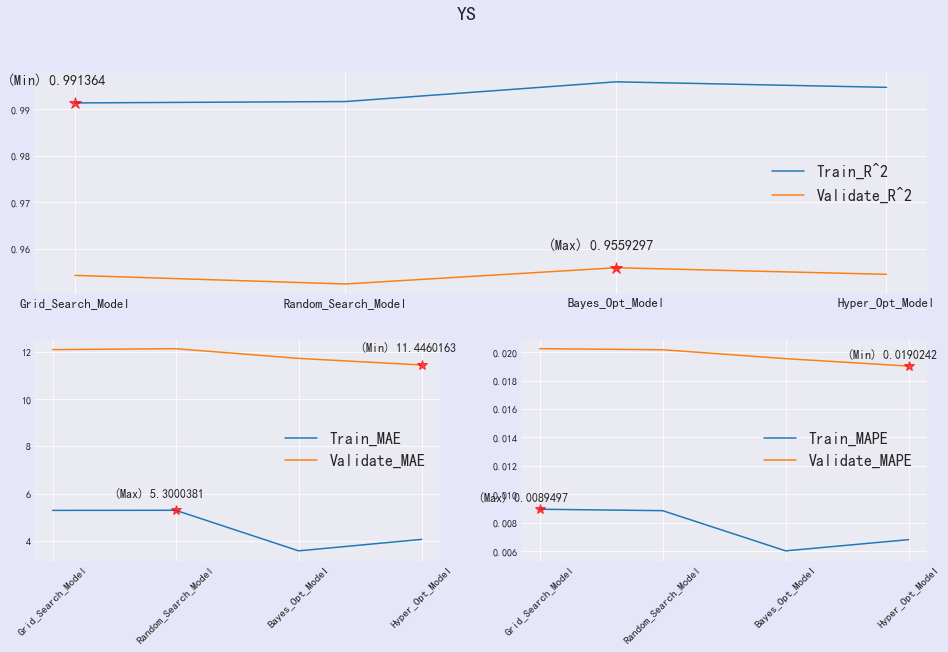

In [163]:
opt_model_comp(ys_cv_train_df, ys_cv_validation_df, "YS")

> 由表可见，在交叉验证中，表现最好的是使用贝叶斯优化得到的模型，根据R2值来看，基于GP的BayesOpt要比基于TPE的HyperOpt的要稍胜一筹，高大约0.1%，而从指标MAE和MAPE来看，HyperOpt优化得到的模型要更好，MAE比BayesOpt的要小0.3，但无论就哪个模型来看，都存在轻微的过拟合，但并不严重，因此就交叉验证中的结果来看优先选择使用贝叶斯优化得到的模型；

## 测试集上的效果对比

In [164]:
ys_test_df

,YS_Test_MAE,MAPE
Grid_Search_Model,12.356586,0.020182
Random_Search_Model,11.256978,0.018676
Bayes_Opt_Model,11.605390,0.019100
Hyper_Opt_Model,12.162080,0.020088


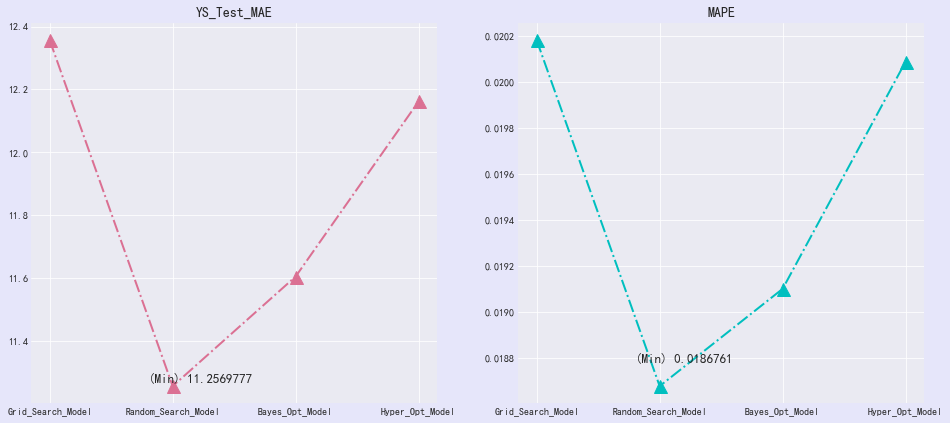

In [165]:
fig = plt.figure(figsize = (16, 7))
# 设置背景色
fig.patch.set_facecolor("lavender")
colors = ["palevioletred", "c"]

for i in range(2):
    ax = plt.subplot(1, 2, i + 1)
    ax.plot(ys_test_df.iloc[:, i], color = colors[i], linewidth = 2, marker = "^", markersize = 13, ls = "-.")
    idx_l = ys_test_df.iloc[:, i].values.tolist()
    idx = idx_l.index(min(idx_l))
    y = min(idx_l)
    d = 0.01
    if i:
        d = 0.0001
    plt.text(idx - 0.2, y + d, "(Min) " + str(round(y, 7)), fontdict = {"fontsize": 13})
    ax.set_title(ys_test_df.columns[i], fontsize = 14)
plt.show()

> 由表可见，在交叉验证中表现良好的贝叶斯优化得到的模型并没有表现得最佳，反而是使用随机搜索得到的模型，MAE比BayesOpt得到的模型还要小0.35左右，也只有其一个的MAPE要比0.019还要小，因此就验证集来看的话，随机搜索得到的模型显然就是最佳选择；

## 预测情况对比

In [166]:
predict_df = pd.DataFrame(y_test)
predict_df.columns = ["YS_Y_True"]
for model, label in zip([grid_search_xgb, random_search_xgb, bayes_xgb, hyperopt_xgb],
                       ["Grid_Model_Pred", "Random_Model_Pred", "Bayes_Model_Pred", "Hyperopt_Model_Pred"]):
    predict_df[label] = np.round(model.predict(x_test), 1)

predict_df

,YS_Y_True,Grid_Model_Pred,Random_Model_Pred,Bayes_Model_Pred,Hyperopt_Model_Pred
0,648.000000,641.000000,643.599976,643.500000,640.000000
1,679.000000,674.400024,676.299988,676.400024,674.000000
2,677.000000,675.500000,677.900024,680.299988,677.200012
3,692.000000,710.599976,703.599976,698.299988,700.700012
4,636.500000,619.500000,633.000000,631.900024,631.400024
...,...,...,...,...,...
75,651.000000,671.599976,670.900024,668.299988,671.599976
76,614.500000,614.400024,617.099976,616.700012,615.000000
77,573.203333,561.799988,574.000000,574.400024,576.299988
78,705.643333,683.700012,686.700012,685.000000,684.599976


In [167]:
for i, label in enumerate(["(Grid) Abs_Error", "(Random) Abs_Error", "(Bayes) Abs_Error", "(Hyper) Abs_Error"]):
    predict_df[label] = abs(predict_df.iloc[:, 0] - predict_df.iloc[:, i + 1])
predict_df

,YS_Y_True,Grid_Model_Pred,Random_Model_Pred,Bayes_Model_Pred,Hyperopt_Model_Pred,(Grid) Abs_Error,(Random) Abs_Error,(Bayes) Abs_Error,(Hyper) Abs_Error
0,648.000000,641.000000,643.599976,643.500000,640.000000,7.000000,4.400024,4.500000,8.000000
1,679.000000,674.400024,676.299988,676.400024,674.000000,4.599976,2.700012,2.599976,5.000000
2,677.000000,675.500000,677.900024,680.299988,677.200012,1.500000,0.900024,3.299988,0.200012
3,692.000000,710.599976,703.599976,698.299988,700.700012,18.599976,11.599976,6.299988,8.700012
4,636.500000,619.500000,633.000000,631.900024,631.400024,17.000000,3.500000,4.599976,5.099976
...,...,...,...,...,...,...,...,...,...
75,651.000000,671.599976,670.900024,668.299988,671.599976,20.599976,19.900024,17.299988,20.599976
76,614.500000,614.400024,617.099976,616.700012,615.000000,0.099976,2.599976,2.200012,0.500000
77,573.203333,561.799988,574.000000,574.400024,576.299988,11.403346,0.796667,1.196691,3.096654
78,705.643333,683.700012,686.700012,685.000000,684.599976,21.943321,18.943321,20.643333,21.043358


In [168]:
predict_error_df = predict_df.iloc[:, 5:]
predict_error_df

,(Grid) Abs_Error,(Random) Abs_Error,(Bayes) Abs_Error,(Hyper) Abs_Error
0,7.000000,4.400024,4.500000,8.000000
1,4.599976,2.700012,2.599976,5.000000
2,1.500000,0.900024,3.299988,0.200012
3,18.599976,11.599976,6.299988,8.700012
4,17.000000,3.500000,4.599976,5.099976
...,...,...,...,...
75,20.599976,19.900024,17.299988,20.599976
76,0.099976,2.599976,2.200012,0.500000
77,11.403346,0.796667,1.196691,3.096654
78,21.943321,18.943321,20.643333,21.043358


In [169]:
predict_error_df.describe().T

,count,mean,std,min,25%,50%,75%,max
(Grid) Abs_Error,80.0,12.361325,10.921591,0.099976,4.444161,9.091679,18.747485,49.779976
(Random) Abs_Error,80.0,11.261326,10.876662,0.299988,3.133739,7.580000,15.050003,51.358667
(Bayes) Abs_Error,80.0,11.601236,10.656063,0.099976,3.394101,9.321648,16.350824,47.958642
(Hyper) Abs_Error,80.0,12.163992,11.735387,0.099976,3.600006,8.860012,16.872485,52.180000


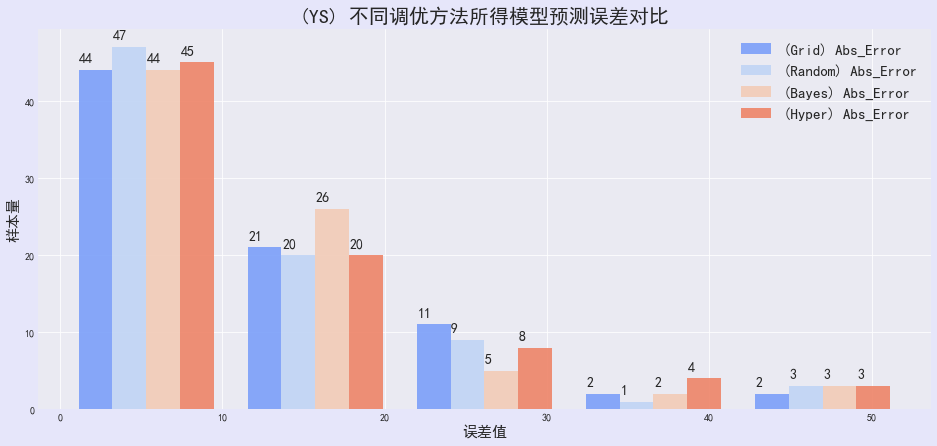

In [170]:
fig = plt.figure(figsize = (16, 7))
fig.patch.set_facecolor("lavender")
current_palette = sns.color_palette("coolwarm", 4)

plt.hist(predict_error_df
         , bins = 5
         , label = predict_error_df.columns
         , alpha = .9
         , color = current_palette)
# 标注数据
axes = plt.gca()
for ax in axes.patches:
    if ax.get_height() > 0:
        x, y = ax.get_x(), ax.get_height()
        plt.text(x + 0.05, y + 1, str(int(y)), fontdict = {"size": 14})

plt.xlabel("误差值", fontsize = 15)
plt.ylabel("样本量", fontsize = 15)
plt.title("(YS) 不同调优方法所得模型预测误差对比", fontsize = 20)
plt.legend(fontsize = 15)

plt.show()

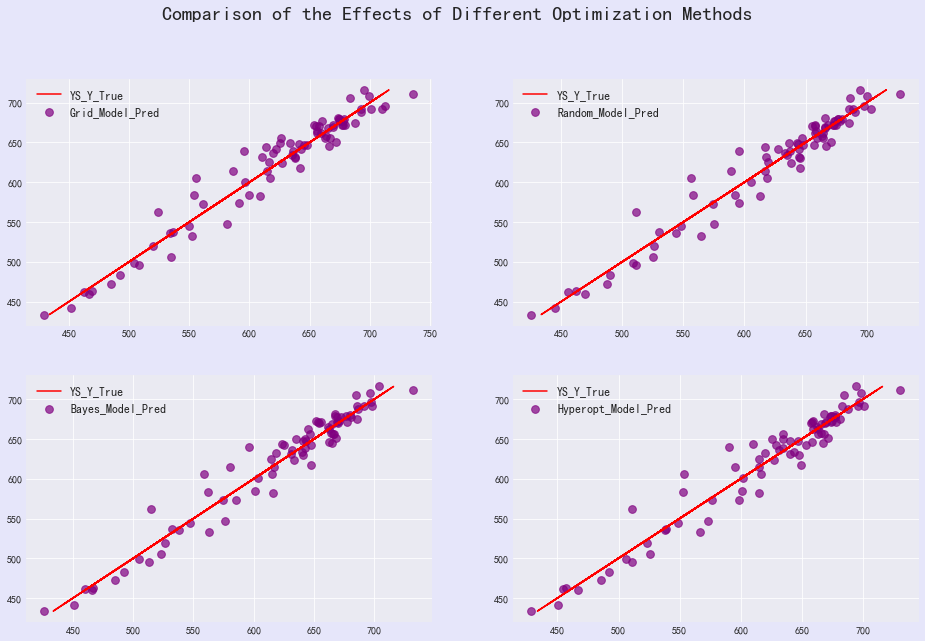

In [171]:
fig = plt.figure(figsize = (16, 10))
fig.patch.set_facecolor("lavender")

for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    ax.scatter(x = predict_df.iloc[:, i + 1]
               , y = predict_df.iloc[:, 0]
               , color = "purple"
               , alpha = .7
               , s = 60
               , label = predict_df.columns[i + 1])
    ax.plot(predict_df.iloc[:, 0]
            , predict_df.iloc[:, 0]
            , color = "red"
            , label = predict_df.columns[0])
    ax.legend(fontsize = 12)
    #ax.set_xticks([])
    #ax.set_yticks([])
plt.suptitle("Comparison of the Effects of Different Optimization Methods", fontsize = 20)

plt.show()

In [172]:
colors = ["red", "peachpuff", "plum", "lightcoral"]
traces = []

fig = make_subplots(2, 2, subplot_titles = predict_error_df.columns)

for i in range(4):
    # 创建图表对象
    trace = go.Scatter(y = predict_error_df.iloc[:, i]
                      , mode = "markers"
                      , marker = dict(size = predict_error_df.iloc[:, i])
                      , showlegend = False)
    traces.append(trace)
# 创建布局对象

# 整合图表对象与布局对象
#fig = go.Figure(data = traces, layout = layout)
fig.append_trace(traces[0], 1, 1)
fig.append_trace(traces[1], 1, 2)
fig.append_trace(traces[2], 2, 1)
fig.append_trace(traces[3], 2, 2)
#layout = go.Layout(title = "不同优化方法所得模型预测误差对比")
fig.update_layout(title = {"text": "(YS) 不同优化方法所得模型预测误差对比"
                          , "x": 0.5 # 坐标轴的长度视为1
                          , "xanchor": "center"
                          , "yanchor": "top"}
                 , height = 600
                 , width = 900)
#fig.update_xaxes(visible = False)
#fig.update_yaxes(visible = False)

fig.show()

> 由表所见，在交叉验证中表现最好的是HyperOpt和BayesOpt优化得到的模型，但在测试集中，表现最好的是随机搜索调参得到的模型，其次是BayesOpt，而训练集与测试集之比为8：2，因此对于在测试集上表现相近的模型，或是差别不太大，更倾向于在交叉验证中表现得更好的，即使其在测试集上相较于其它模型表现效果可能稍差，因此综合来看，最终选择BayesOpt优化所得模型；

In [173]:
pyo.plot(fig, filename = "(YS) 不同优化方法所得模型预测误差对比.html")

'(YS) 不同优化方法所得模型预测误差对比.html'

# 模型保存

In [174]:
path = r"C:\Users\Research Center\Desktop\learning\PW770建模\对标签YS&IACS建模分析\2.建模\ys_xgb.dat"
joblib.dump(bayes_xgb, path)

['C:\\Users\\Research Center\\Desktop\\learning\\PW770建模\\对标签YS&IACS建模分析\\2.建模\\ys_xgb.dat']

In [178]:
path = r"C:\Users\Research Center\Desktop\learning\PW770建模\对标签YS&IACS建模分析\2.建模\ys_xgb.pkl"
pickle.dump(bayes_xgb, open(path, "wb"))